In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import AgglomerativeClustering, SpectralClustering, KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from nltk.corpus import stopwords
from gensim.models import CoherenceModel, LdaModel, LsiModel, HdpModel, Phrases
from gensim.utils import simple_preprocess
from gensim.corpora import Dictionary

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
all_racers = pd.read_csv('./RaceRaves_data/Racers_All.csv')
all_racers = all_racers.drop('Unnamed: 0', axis=1)
all_racers.head()

racer_id           location   state  region         since_date  \
0  090775candice        Anaheim, CA      CA      US  Raving since 2017   
1     16490derek     Wilmot, Canada  Canada  Non-US  Raving since 2017   
2        18anjel          Chino, CA      CA      US  Raving since 2016   
3     1FlyMother  Port Allegany, PA      PA      US  Raving since 2017   
4  1ladybugangel         Oxnard, CA      CA      US  Raving since 2017   

       affiliations                   last active  \
0               NaN             active 1 year ago   
1               NaN   active 4 months, 1 week ago   
2  ['Half Fanatic']   active 2 years, 1 month ago   
3               NaN           active 8 months ago   
4               NaN  active 4 months, 3 weeks ago   

                                               clubs       rave_race  \
0                                                 []             NaN   
1                                                 []             NaN   
2                                                 []             NaN   
3                                                 []             NaN   
4  ['Twisted Trail Runners and  Twisted Trail run...  Spacerock 2017   

                             dream_race  \
0                 Doing a spartan race.   
1                                   NaN   
2                  OC Marathon and Half   
3                                   NaN   
4  Valencia Trail Race March 31st, 2018   

                                         run_because  \
0  I want to show people if you believe in yourse...   
1                                                NaN   
2          My family runs. We run as a family hobby.   
3                                                NaN   
4  It makes me feel like I am alive and living in...   

                                          past_races  \
0  {'Tustin Hangar Half Marathon & 5K': {'name': ...   
1  {'Hamilton Marathon Road2Hope': {'name': 'Hami...   
2  {'Surf City Marathon & Half Marathon': {'name'...   
3  {'Presque Isle Half Marathon': {'name': 'Presq...   
4  {'SPACEROCK Trail Race': {'name': 'SPACEROCK T...   

                                             reviews  
0  {'Tustin Hangar Half Marathon & 5K': [{'race_n...  
1  {'Hamilton Marathon Road2Hope': [{'race_name':...  
2  {'Surf City Marathon & Half Marathon': [{'race...  
3  {'Presque Isle Half Marathon': [{'race_name': ...  
4  {'SPACEROCK Trail Race': [{'race_name': 'SPACE...

In [3]:
all_racers.shape

(2010, 13)

In [4]:
all_racers = all_racers.drop_duplicates(subset=['racer_id'])
all_racers = all_racers.reset_index(drop=True)
all_racers.shape

(2010, 13)

In [5]:
all_racers['racer_id'].to_csv('./RaceRaves_data/Unique_RacerIDs.csv', index=False)

In [6]:
all_racers['affiliations'] = all_racers['affiliations'].fillna('[]')
all_racers = all_racers.fillna('None')
all_racers.head()

racer_id           location   state  region         since_date  \
0  090775candice        Anaheim, CA      CA      US  Raving since 2017   
1     16490derek     Wilmot, Canada  Canada  Non-US  Raving since 2017   
2        18anjel          Chino, CA      CA      US  Raving since 2016   
3     1FlyMother  Port Allegany, PA      PA      US  Raving since 2017   
4  1ladybugangel         Oxnard, CA      CA      US  Raving since 2017   

       affiliations                   last active  \
0                []             active 1 year ago   
1                []   active 4 months, 1 week ago   
2  ['Half Fanatic']   active 2 years, 1 month ago   
3                []           active 8 months ago   
4                []  active 4 months, 3 weeks ago   

                                               clubs       rave_race  \
0                                                 []            None   
1                                                 []            None   
2                                                 []            None   
3                                                 []            None   
4  ['Twisted Trail Runners and  Twisted Trail run...  Spacerock 2017   

                             dream_race  \
0                 Doing a spartan race.   
1                                  None   
2                  OC Marathon and Half   
3                                  None   
4  Valencia Trail Race March 31st, 2018   

                                         run_because  \
0  I want to show people if you believe in yourse...   
1                                               None   
2          My family runs. We run as a family hobby.   
3                                               None   
4  It makes me feel like I am alive and living in...   

                                          past_races  \
0  {'Tustin Hangar Half Marathon & 5K': {'name': ...   
1  {'Hamilton Marathon Road2Hope': {'name': 'Hami...   
2  {'Surf City Marathon & Half Marathon': {'name'...   
3  {'Presque Isle Half Marathon': {'name': 'Presq...   
4  {'SPACEROCK Trail Race': {'name': 'SPACEROCK T...   

                                             reviews  
0  {'Tustin Hangar Half Marathon & 5K': [{'race_n...  
1  {'Hamilton Marathon Road2Hope': [{'race_name':...  
2  {'Surf City Marathon & Half Marathon': [{'race...  
3  {'Presque Isle Half Marathon': [{'race_name': ...  
4  {'SPACEROCK Trail Race': [{'race_name': 'SPACE...

In [7]:
all_racers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2010 entries, 0 to 2009
Data columns (total 13 columns):
racer_id        2010 non-null object
location        2010 non-null object
state           2010 non-null object
region          2010 non-null object
since_date      2010 non-null object
affiliations    2010 non-null object
last active     2010 non-null object
clubs           2010 non-null object
rave_race       2010 non-null object
dream_race      2010 non-null object
run_because     2010 non-null object
past_races      2010 non-null object
reviews         2010 non-null object
dtypes: object(13)
memory usage: 204.2+ KB


In [8]:
all_racers['affiliations'] = all_racers['affiliations'].map(literal_eval)

def fix_affiliations(list):
    new_list = []
    for item in list:
        if item == '50 states hopeful/finisher':
            new_list.append('50 states aspirant/finisher')
        elif item == 'Ironman triathlete':
            new_list.append('Ironman')
        elif item == 'Seven Continents Club member':
            new_list.append('Seven Continents Club')
        else:
            new_list.append(item)
    return new_list

all_racers['affiliations'] = all_racers['affiliations'].map(fix_affiliations)

all_racers['clubs'] = all_racers['clubs'].map(lambda x: str(x).replace(';', "','"))
all_racers['clubs'] = all_racers['clubs'].map(lambda x: '[]' if x == 'None' else x)
all_racers['clubs'] = all_racers['clubs'].map(literal_eval)

all_racers.head(10)

racer_id                 location   state  region         since_date  \
0  090775candice              Anaheim, CA      CA      US  Raving since 2017   
1     16490derek           Wilmot, Canada  Canada  Non-US  Raving since 2017   
2        18anjel                Chino, CA      CA      US  Raving since 2016   
3     1FlyMother        Port Allegany, PA      PA      US  Raving since 2017   
4  1ladybugangel               Oxnard, CA      CA      US  Raving since 2017   
5     2tallfritz               Auburn, IN      IN      US  Raving since 2014   
6       428lyman  International Falls, MN      MN      US  Raving since 2017   
7      42kCookie                Tracy, CA      CA      US  Raving since 2015   
8     42kStraley           Shell Knob, MO      MO      US  Raving since 2017   
9         42kman         Breckenridge, MN      MN      US  Raving since 2017   

                                        affiliations  \
0                                                 []   
1                                                 []   
2                                     [Half Fanatic]   
3                                                 []   
4                                                 []   
5     [Marathon Maniac, 50 states aspirant/finisher]   
6                                                 []   
7                                     [Half Fanatic]   
8                      [50 states aspirant/finisher]   
9  [Boston Marathon finisher, 50 states aspirant/...   

                    last active  \
0             active 1 year ago   
1   active 4 months, 1 week ago   
2   active 2 years, 1 month ago   
3           active 8 months ago   
4  active 4 months, 3 weeks ago   
5  active 3 years, 4 months ago   
6          active 10 months ago   
7   active 6 months, 1 week ago   
8            active 1 month ago   
9    active 1 year, 1 month ago   

                                               clubs             rave_race  \
0                                                 []                  None   
1                                                 []                  None   
2                                                 []                  None   
3                                                 []                  None   
4  [Twisted Trail Runners and  Twisted Trail runn...        Spacerock 2017   
5                                                 []  Little Rock Marathon   
6                                                 []                  None   
7                      [Mountain House Running Club]                  None   
8                                                 []                  None   
9                                                 []                  None   

                             dream_race  \
0                 Doing a spartan race.   
1                                  None   
2                  OC Marathon and Half   
3                                  None   
4  Valencia Trail Race March 31st, 2018   
5                 Silver Falls Marathon   
6                                  None   
7        Escape from Alcatraz Triathlon   
8                                  None   
9                      THE WORLD MAJORS   

                                         run_because  \
0  I want to show people if you believe in yourse...   
1                                               None   
2          My family runs. We run as a family hobby.   
3                                               None   
4  It makes me feel like I am alive and living in...   
5           It keeps me (somewhat) sane and healthy.   
6                                               None   
7                                             I can.   
8                                               None   
9  I CAN!!!! I LOVE THE FEELING OF DOING SOMETHIN...   

                                          past_races  \
0  {'Tustin Hangar Half Marathon & 5K': {'name': ...   
1  {'Hamilton Marathon Road2Hope': {'name': 'Hami...   
2  {'S

In [9]:
affiliation_dummies = pd.get_dummies(pd.DataFrame(all_racers['affiliations'].tolist()).stack()).sum(level=0)
all_racers = pd.merge(left=all_racers, right=affiliation_dummies,
                      left_index=True, right_index=True, how='left')
all_racers = all_racers.drop('affiliations', axis=1)
all_racers = all_racers.fillna(0)
all_racers.head()

racer_id           location   state  region         since_date  \
0  090775candice        Anaheim, CA      CA      US  Raving since 2017   
1     16490derek     Wilmot, Canada  Canada  Non-US  Raving since 2017   
2        18anjel          Chino, CA      CA      US  Raving since 2016   
3     1FlyMother  Port Allegany, PA      PA      US  Raving since 2017   
4  1ladybugangel         Oxnard, CA      CA      US  Raving since 2017   

                    last active  \
0             active 1 year ago   
1   active 4 months, 1 week ago   
2   active 2 years, 1 month ago   
3           active 8 months ago   
4  active 4 months, 3 weeks ago   

                                               clubs       rave_race  \
0                                                 []            None   
1                                                 []            None   
2                                                 []            None   
3                                                 []            None   
4  [Twisted Trail Runners and  Twisted Trail runn...  Spacerock 2017   

                             dream_race  \
0                 Doing a spartan race.   
1                                  None   
2                  OC Marathon and Half   
3                                  None   
4  Valencia Trail Race March 31st, 2018   

                                         run_because  \
0  I want to show people if you believe in yourse...   
1                                               None   
2          My family runs. We run as a family hobby.   
3                                               None   
4  It makes me feel like I am alive and living in...   

                                          past_races  \
0  {'Tustin Hangar Half Marathon & 5K': {'name': ...   
1  {'Hamilton Marathon Road2Hope': {'name': 'Hami...   
2  {'Surf City Marathon & Half Marathon': {'name'...   
3  {'Presque Isle Half Marathon': {'name': 'Presq...   
4  {'SPACEROCK Trail Race': {'name': 'SPACEROCK T...   

                                             reviews  100 Half Marathons Club  \
0  {'Tustin Hangar Half Marathon & 5K': [{'race_n...                      0.0   
1  {'Hamilton Marathon Road2Hope': [{'race_name':...                      0.0   
2  {'Surf City Marathon & Half Marathon': [{'race...                      0.0   
3  {'Presque Isle Half Marathon': [{'race_name': ...                      0.0   
4  {'SPACEROCK Trail Race': [{'race_name': 'SPACE...                      0.0   

   50 states aspirant/finisher  Boston Marathon finisher  Half Fanatic  \
0                          0.0                       0.0           0.0   
1                          0.0                       0.0           0.0   
2                          0.0                       0.0           1.0   
3                          0.0                       0.0           0.0   
4                          0.0                       0.0           0.0   

   Ironman  Marathon Maniac  Seven Continents Club  
0      0.0              0.0                    0.0  
1      0.0              0.0                    0.0  
2      0.0              0.0                    0.0  
3      0.0              0.0                    0.0  
4      0.0              0.0                    0.0

In [10]:
clubs = []
for i in range(len(all_racers)):
    club_list = all_racers.iloc[i]['clubs']
    if club_list != []:
        for j in range(len(club_list)):
            clubs.append(club_list[j])
clubs_df = pd.DataFrame(clubs, columns=['club'])
clubs_df['club'].value_counts().head()

A Snail's Pace                 14
AREC                           13
Marathon Maniacs                8
A Snail's Pace Running Club     7
Half Fanatics                   6
Name: club, dtype: int64

In [11]:
race_review_df = pd.DataFrame()
for i in range(len(all_racers)):
    try:
        review_dict = literal_eval(all_racers['reviews'].iloc[i])
        for key, value in review_dict.items():
            new_row = pd.DataFrame(value[0], index = [key])
            new_row['racer_id'] = all_racers.iloc[i]['racer_id']
            race_review_df = pd.concat([race_review_df, new_row])
    except:
        continue
race_review_df = race_review_df.reset_index(drop=True)
race_review_df.head()

date  diff_rating        distance  overall_rating  prod_rating  \
0  Mar 15, 2017          3.0             5K              4.0          4.0   
1   Feb 7, 2017          5.0  Half Marathon              5.0          5.0   
2  Nov 17, 2017          4.0       Marathon              5.0          5.0   
3  Feb 13, 2016          1.0  Half Marathon              5.0          4.0   
4  Feb 13, 2016          3.0            10K              3.0          4.0   

                            race_name  scenery_rating  swag_rating  \
0    Tustin Hangar Half Marathon & 5K             4.0          4.0   
1  Surf City Marathon & Half Marathon             5.0          5.0   
2         Hamilton Marathon Road2Hope             4.0          3.0   
3  Surf City Marathon & Half Marathon             5.0          4.0   
4                     Mission Inn Run             4.0          2.0   

                                                text  \
0   Have to do it again next year. My daughter an...   
1   For my first half marathon I would love to sa...   
2   Hamilton is an intimate race gathering with a...   
3   The most stand-out, amazing part of this race...   
4   For the price you pay for this run, it is wor...   

                                      title             type       racer_id  
0   It was amazing to see inside the hanger  First-timer '17  090775candice  
1          This was my first half marathon.  First-timer '17  090775candice  
2                     Canada's top marathon  First-timer '17     16490derek  
3  A summary of California life in one race  First-timer '16        18anjel  
4                        Good for the money  First-timer '15        18anjel

In [12]:
race_review_df.shape

(6414, 12)

In [13]:
distances = race_review_df['distance'].value_counts()[race_review_df['distance'].value_counts() > 20].index
distances

Index(['Half Marathon ', 'Marathon ', '5K ', '10K ', '50K ', '10 Miler ',
       '15K ', '12K ', '5 Miler ', '50 Miler ', 'Marathon Relay ',
       'Half Marathon Relay ', '25K ', '4 Miler ', '8K '],
      dtype='object')

In [14]:
def create_distance_trunc(distance):
    if distance in distances:
        return distance
    else:
        return 'Other'

race_review_df['distance_trunc'] = race_review_df['distance'].map(create_distance_trunc)
race_review_df.head()

date  diff_rating        distance  overall_rating  prod_rating  \
0  Mar 15, 2017          3.0             5K              4.0          4.0   
1   Feb 7, 2017          5.0  Half Marathon              5.0          5.0   
2  Nov 17, 2017          4.0       Marathon              5.0          5.0   
3  Feb 13, 2016          1.0  Half Marathon              5.0          4.0   
4  Feb 13, 2016          3.0            10K              3.0          4.0   

                            race_name  scenery_rating  swag_rating  \
0    Tustin Hangar Half Marathon & 5K             4.0          4.0   
1  Surf City Marathon & Half Marathon             5.0          5.0   
2         Hamilton Marathon Road2Hope             4.0          3.0   
3  Surf City Marathon & Half Marathon             5.0          4.0   
4                     Mission Inn Run             4.0          2.0   

                                                text  \
0   Have to do it again next year. My daughter an...   
1   For my first half marathon I would love to sa...   
2   Hamilton is an intimate race gathering with a...   
3   The most stand-out, amazing part of this race...   
4   For the price you pay for this run, it is wor...   

                                      title             type       racer_id  \
0   It was amazing to see inside the hanger  First-timer '17  090775candice   
1          This was my first half marathon.  First-timer '17  090775candice   
2                     Canada's top marathon  First-timer '17     16490derek   
3  A summary of California life in one race  First-timer '16        18anjel   
4                        Good for the money  First-timer '15        18anjel   

   distance_trunc  
0             5K   
1  Half Marathon   
2       Marathon   
3  Half Marathon   
4            10K

In [15]:
race_review_df['distance_trunc'].value_counts()

Half Marathon           2907
Marathon                1334
5K                       691
10K                      553
Other                    404
50K                      131
10 Miler                  85
15K                       79
12K                       55
5 Miler                   35
50 Miler                  29
Marathon Relay            24
Half Marathon Relay       23
25K                       22
8K                        21
4 Miler                   21
Name: distance_trunc, dtype: int64

In [16]:
race_review_df['racer_id'].value_counts().describe(percentiles=[.25, .5, .6, .7, .8, .9, .95])


count    2009.000000
mean        3.192633
std         6.181616
min         1.000000
25%         1.000000
50%         1.000000
60%         2.000000
70%         2.000000
80%         3.000000
90%         7.000000
95%        13.000000
max        88.000000
Name: racer_id, dtype: float64

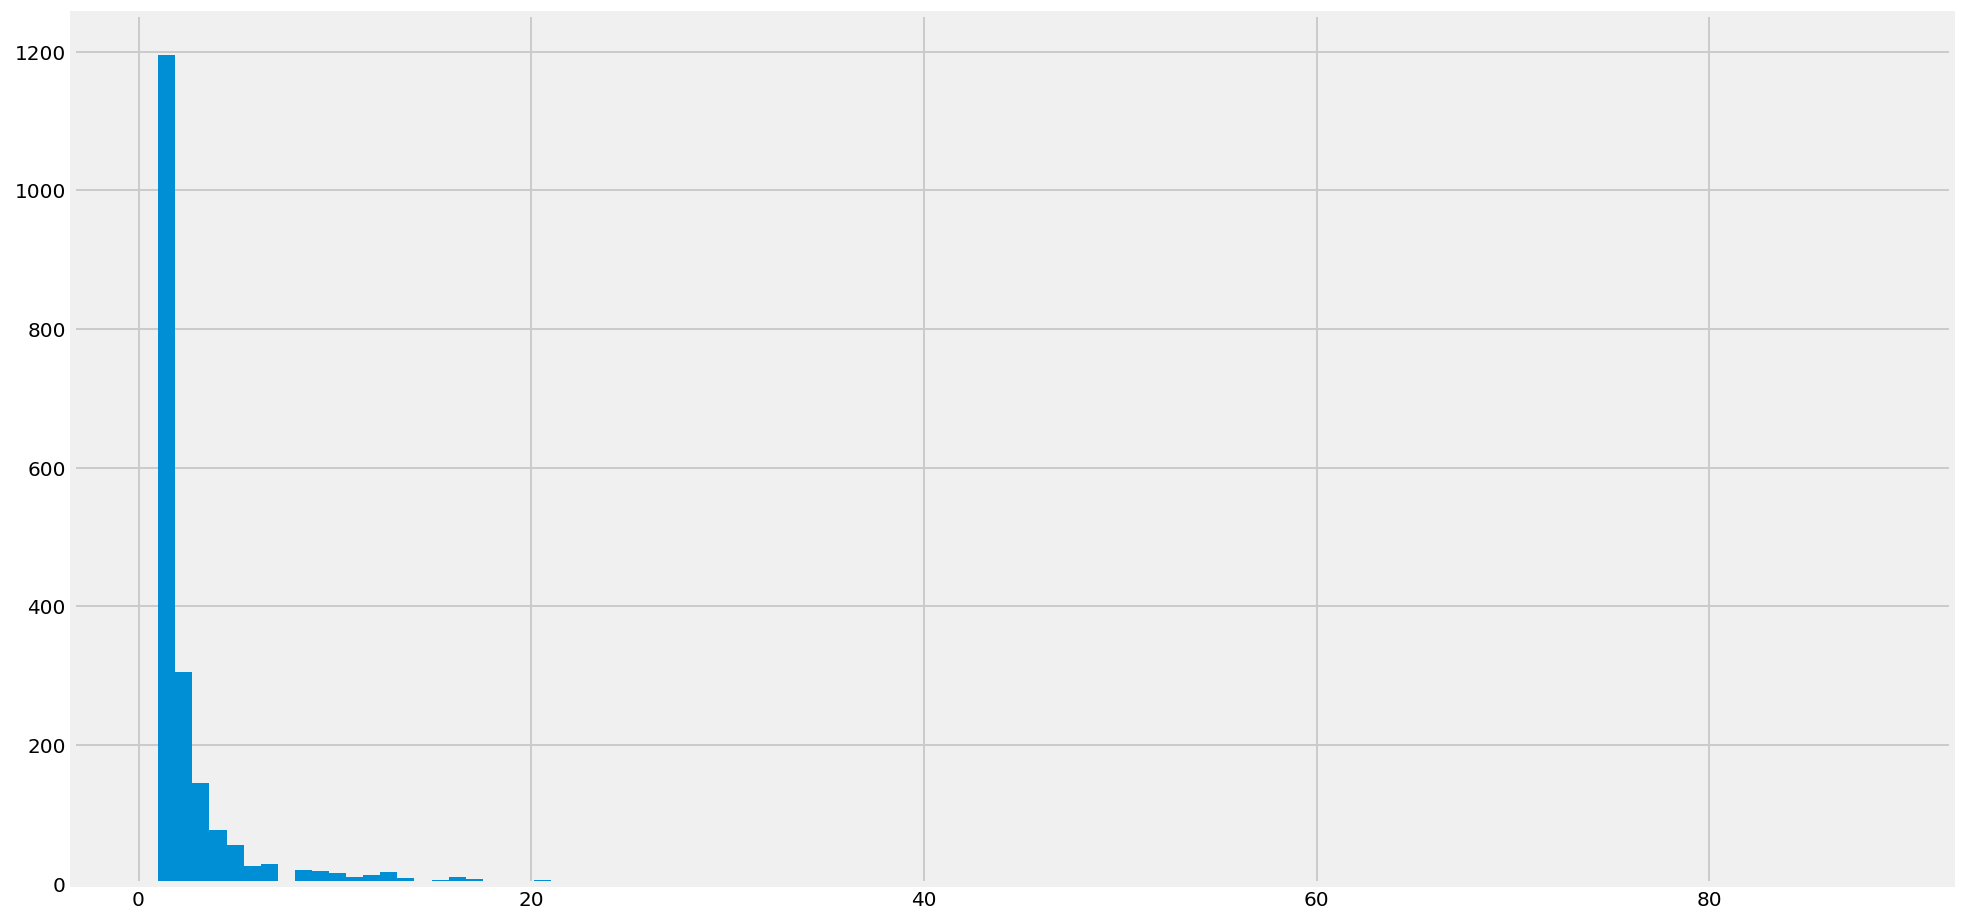

In [17]:
plt.figure(figsize=(15, 8))
plt.hist(race_review_df['racer_id'].value_counts(), bins=100);

In [18]:
ratings = ['overall_rating', 'diff_rating', 'scenery_rating', 'prod_rating', 'swag_rating']
race_review_df[ratings].describe(percentiles=[0.05, 0.1, 0.2, 0.25, 0.5, 0.75]).T

count      mean       std  min   5%  10%  20%  25%  50%  75%  \
overall_rating  6414.0  4.222638  0.868931  1.0  3.0  3.0  4.0  4.0  4.0  5.0   
diff_rating     6414.0  2.917992  1.198709  1.0  1.0  1.0  2.0  2.0  3.0  4.0   
scenery_rating  6414.0  3.919395  1.065991  1.0  2.0  2.0  3.0  3.0  4.0  5.0   
prod_rating     6414.0  4.216869  0.970429  1.0  2.0  3.0  4.0  4.0  4.0  5.0   
swag_rating     6414.0  3.873558  1.098491  1.0  2.0  2.0  3.0  3.0  4.0  5.0   

                max  
overall_rating  5.0  
diff_rating     5.0  
scenery_rating  5.0  
prod_rating     5.0  
swag_rating     5.0

In [19]:
race_review_df[ratings].corr()

overall_rating  diff_rating  scenery_rating  prod_rating  \
overall_rating        1.000000     0.156160        0.483673     0.694811   
diff_rating           0.156160     1.000000        0.332853     0.126685   
scenery_rating        0.483673     0.332853        1.000000     0.328325   
prod_rating           0.694811     0.126685        0.328325     1.000000   
swag_rating           0.523347     0.113269        0.253896     0.533458   

                swag_rating  
overall_rating     0.523347  
diff_rating        0.113269  
scenery_rating     0.253896  
prod_rating        0.533458  
swag_rating        1.000000

In [20]:
race_review_df['year'] = race_review_df['date'].map(lambda x: str(x)[-4:])
race_review_df['year'].value_counts().sort_index()

2014     223
2015     904
2016    1940
2017    2725
2018     622
Name: year, dtype: int64

In [21]:
race_ratings = race_review_df[['race_name', 'racer_id', 'overall_rating']]
race_pivot = race_ratings.pivot(index='racer_id', columns='race_name')
# race_pivot = race_pivot.reset_index()
race_pivot = race_pivot.fillna(0.0)

In [22]:
race_pivot.shape

(2009, 2103)

In [23]:
race_pivot.head()

overall_rating                 \
race_name     1/2 Way to Christmas Half 10K on the Bay   
racer_id                                                 
090775candice                       0.0            0.0   
16490derek                          0.0            0.0   
18anjel                             0.0            0.0   
1FlyMother                          0.0            0.0   
1ladybugangel                       0.0            0.0   

                                                                              \
race_name     20 Mile Drop & 10 Mile Drop 305 Half Marathon 3M Half Marathon   
racer_id                                                                       
090775candice                         0.0               0.0              0.0   
16490derek                            0.0               0.0              0.0   
18anjel                               0.0               0.0              0.0   
1FlyMother                            0.0               0.0              0.0   
1ladybugangel                         0.0               0.0              0.0   

                               \
race_name     4 Miles 4 Water   
racer_id                        
090775candice             0.0   
16490derek                0.0   
18anjel                   0.0   
1FlyMother                0.0   
1ladybugangel             0.0   

                                                                   \
race_name     5-3-1 Run! July 4th Woodland Schools Foundation Run   
racer_id                                                            
090775candice                                                0.0    
16490derek                                                   0.0    
18anjel                                                      0.0    
1FlyMother                                                   0.0    
1ladybugangel                                                0.0    

                                                          \
race_name     5K Chilly Chili Race 6 Stones Run For Hope   
racer_id                                                   
090775candice                  0.0                   0.0   
16490derek                     0.0                   0.0   
18anjel                        0.0                   0.0   
1FlyMother                     0.0                   0.0   
1ladybugangel                  0.0                   0.0   

                                                            \
race_name     7 Bridges Marathon & 4 Bridges Half Marathon   
racer_id                                                     
090775candice                                          0.0   
16490derek                                             0.0   
18anjel                                                0.0   
1FlyMother                                             0.0   
1ladybugangel                                          0.0   

                             ...                                     \
race_name                    ...                Zoom Ayala Cove Run   
racer_id                     ...                                      
090775candice                ...                                0.0   
16490derek                   ...                                0.0   
18anjel                      ...                                0.0   
1FlyMother                   ...                                0.0   
1ladybugangel                ...                                0.0   

                                                                             \
race_name     Zoom Point Pinole Zoom Quarry Lakes (Summer) Zoom Turkey Trot   
racer_id                                                                      
090775candice               0.0                        0.0              0.0   
16490derek                  0.0                        0.0              0.0   
18anjel                     0.0                        0.0              0.0   
1FlyMother                  0.0                        0.0              0.0   
1

In [24]:
race_pivot[race_pivot['overall_rating'] > 0]['overall_rating'].count().sum()

6414

In [25]:
ratings2 = ratings + ['distance_trunc']
race_review_df[ratings2].groupby('distance_trunc')['prod_rating'].describe()

count      mean       std  min  25%  50%  75%  max
distance_trunc                                                           
10 Miler                85.0  4.223529  0.943354  1.0  4.0  4.0  5.0  5.0
10K                    553.0  4.206148  1.016618  1.0  4.0  5.0  5.0  5.0
12K                     55.0  4.272727  0.932034  2.0  4.0  5.0  5.0  5.0
15K                     79.0  4.189873  0.848467  2.0  4.0  4.0  5.0  5.0
25K                     22.0  4.318182  0.779888  3.0  4.0  4.5  5.0  5.0
4 Miler                 21.0  4.333333  0.658281  3.0  4.0  4.0  5.0  5.0
5 Miler                 35.0  3.857143  1.191708  1.0  3.0  4.0  5.0  5.0
50 Miler                29.0  4.379310  0.862463  1.0  4.0  5.0  5.0  5.0
50K                    131.0  4.297710  0.883130  1.0  4.0  4.0  5.0  5.0
5K                     691.0  4.043415  1.056860  1.0  3.0  4.0  5.0  5.0
8K                      21.0  4.238095  0.768424  3.0  4.0  4.0  5.0  5.0
Half Marathon         2907.0  4.216718  0.962023  1.0  4.0  4.0  5.0  5.0
Half Marathon Relay     23.0  4.260870  1.053884  1.0  4.0  5.0  5.0  5.0
Marathon              1334.0  4.282609  0.924963  1.0  4.0  5.0  5.0  5.0
Marathon Relay          24.0  4.250000  0.846990  2.0  4.0  4.0  5.0  5.0
Other                  404.0  4.284653  1.008973  1.0  4.0  5.0  5.0  5.0

In [26]:
X = race_review_df[['diff_rating', 'scenery_rating', 'prod_rating', 'swag_rating']]
y = race_review_df['overall_rating']

In [27]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X, y)
print(lr.score(X, y))
print(lr.coef_)

0.5802681984348301
[-0.01546927  0.22589542  0.45506066  0.14577905]


/Users/dwayne/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [28]:
lr.intercept_

0.898788868063749

In [29]:
predictions = lr.predict(X)
predictions

array([4.15932157, 4.95511815, 4.4531339 , ..., 3.46289621, 4.17479084,
       4.35427844])

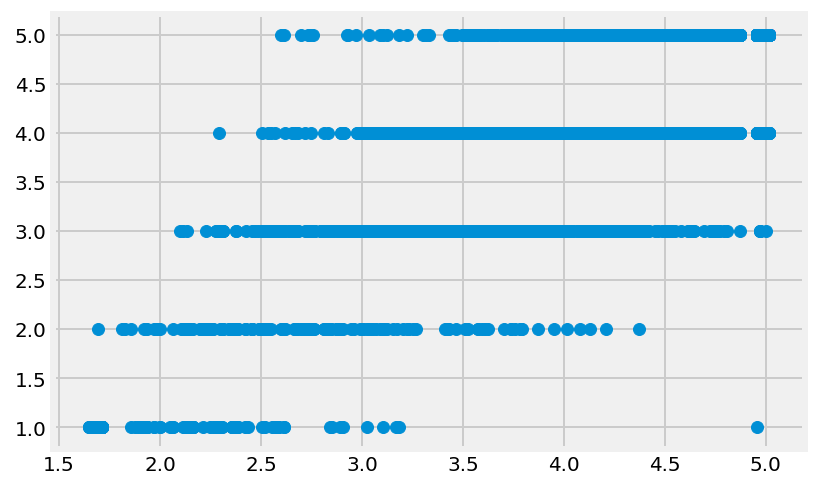

In [30]:
plt.scatter(predictions, y)

In [31]:
race_review_df.head()

date  diff_rating        distance  overall_rating  prod_rating  \
0  Mar 15, 2017          3.0             5K              4.0          4.0   
1   Feb 7, 2017          5.0  Half Marathon              5.0          5.0   
2  Nov 17, 2017          4.0       Marathon              5.0          5.0   
3  Feb 13, 2016          1.0  Half Marathon              5.0          4.0   
4  Feb 13, 2016          3.0            10K              3.0          4.0   

                            race_name  scenery_rating  swag_rating  \
0    Tustin Hangar Half Marathon & 5K             4.0          4.0   
1  Surf City Marathon & Half Marathon             5.0          5.0   
2         Hamilton Marathon Road2Hope             4.0          3.0   
3  Surf City Marathon & Half Marathon             5.0          4.0   
4                     Mission Inn Run             4.0          2.0   

                                                text  \
0   Have to do it again next year. My daughter an...   
1   For my first half marathon I would love to sa...   
2   Hamilton is an intimate race gathering with a...   
3   The most stand-out, amazing part of this race...   
4   For the price you pay for this run, it is wor...   

                                      title             type       racer_id  \
0   It was amazing to see inside the hanger  First-timer '17  090775candice   
1          This was my first half marathon.  First-timer '17  090775candice   
2                     Canada's top marathon  First-timer '17     16490derek   
3  A summary of California life in one race  First-timer '16        18anjel   
4                        Good for the money  First-timer '15        18anjel   

   distance_trunc  year  
0             5K   2017  
1  Half Marathon   2017  
2       Marathon   2017  
3  Half Marathon   2016  
4            10K   2016

In [32]:
fix_word_dict = {
    'station': 'stations',
    'water': 'aid',
    'stops': 'stations',
    'tech': 'technical',
    'way': 'course',
    'pick': 'pickup',
    'started': 'start',
    'starts': 'start',
    'participants': 'finishers',
    'running': 'run',
    'runners': 'run',
    'walkers': 'walk',
    'finisher': 'finishers',
    'finishes': 'finish',
    'take': 'takes'
}
def fix_words(word):
    try:
        return fix_word_dict[word]
    except:
        return word

reviews = list(race_review_df['text'])
for i in range(len(reviews)):
    review_split = reviews[i].split(" ")
    review_fixed = [fix_words(''.join(e for e in word if e.isalnum())) for word in review_split]
    review_joined = " ".join(review_fixed)
    reviews[i] = review_joined
race_review_df['text'] = reviews

In [33]:
my_stopwords = stopwords.words('english') + \
              ['10k', '5k', 'marathon', 'becaus', 'mile', 'join', 'ultra', \
               '000', '5', '10', '13', '15', '20', '26', '30', '50', '100', \
               '500', '00', '12', '24', '25', '31', '42', '195', '25k', '50k', '131', '262']

In [34]:
review_vect = TfidfVectorizer(ngram_range=(2, 2), stop_words=my_stopwords, min_df=25, max_df=0.3)
X = review_vect.fit_transform(race_review_df['text'])

review_vect_df = pd.DataFrame(X.toarray(), columns=review_vect.get_feature_names())
review_vect_names = review_vect.get_feature_names()
review_vect_df.head()

able run  age group  ahead time  aid aid  aid bottle  aid bottles  \
0       0.0        0.0         0.0      0.0         0.0          0.0   
1       0.0        0.0         0.0      0.0         0.0          0.0   
2       0.0        0.0         0.0      0.0         0.0          0.0   
3       0.0        0.0         0.0      0.0         0.0          0.0   
4       0.0        0.0         0.0      0.0         0.0          0.0   

   aid gatorade  aid sports  aid stations  aid stop    ...      year course  \
0           0.0         0.0           0.0       0.0    ...              0.0   
1           0.0         0.0           0.0       0.0    ...              0.0   
2           0.0         0.0           0.0       0.0    ...              0.0   
3           0.0         0.0           0.0       0.0    ...              0.0   
4           0.0         0.0           0.0       0.0    ...              0.0   

   year race  year ran  year run  year since  year year  years ago  \
0        0.0       0.0       0.0         0.0        0.0   0.000000   
1        0.0       0.0       0.0         0.0        0.0   0.507339   
2        0.0       0.0       0.0         0.0        0.0   0.000000   
3        0.0       0.0       0.0         0.0        0.0   0.000000   
4        0.0       0.0       0.0         0.0        0.0   0.000000   

   years race  youre looking  youre run  
0         0.0            0.0        0.0  
1         0.0            0.0        0.0  
2         0.0            0.0        0.0  
3         0.0            0.0        0.0  
4         0.0            0.0        0.0  

[5 rows x 768 columns]

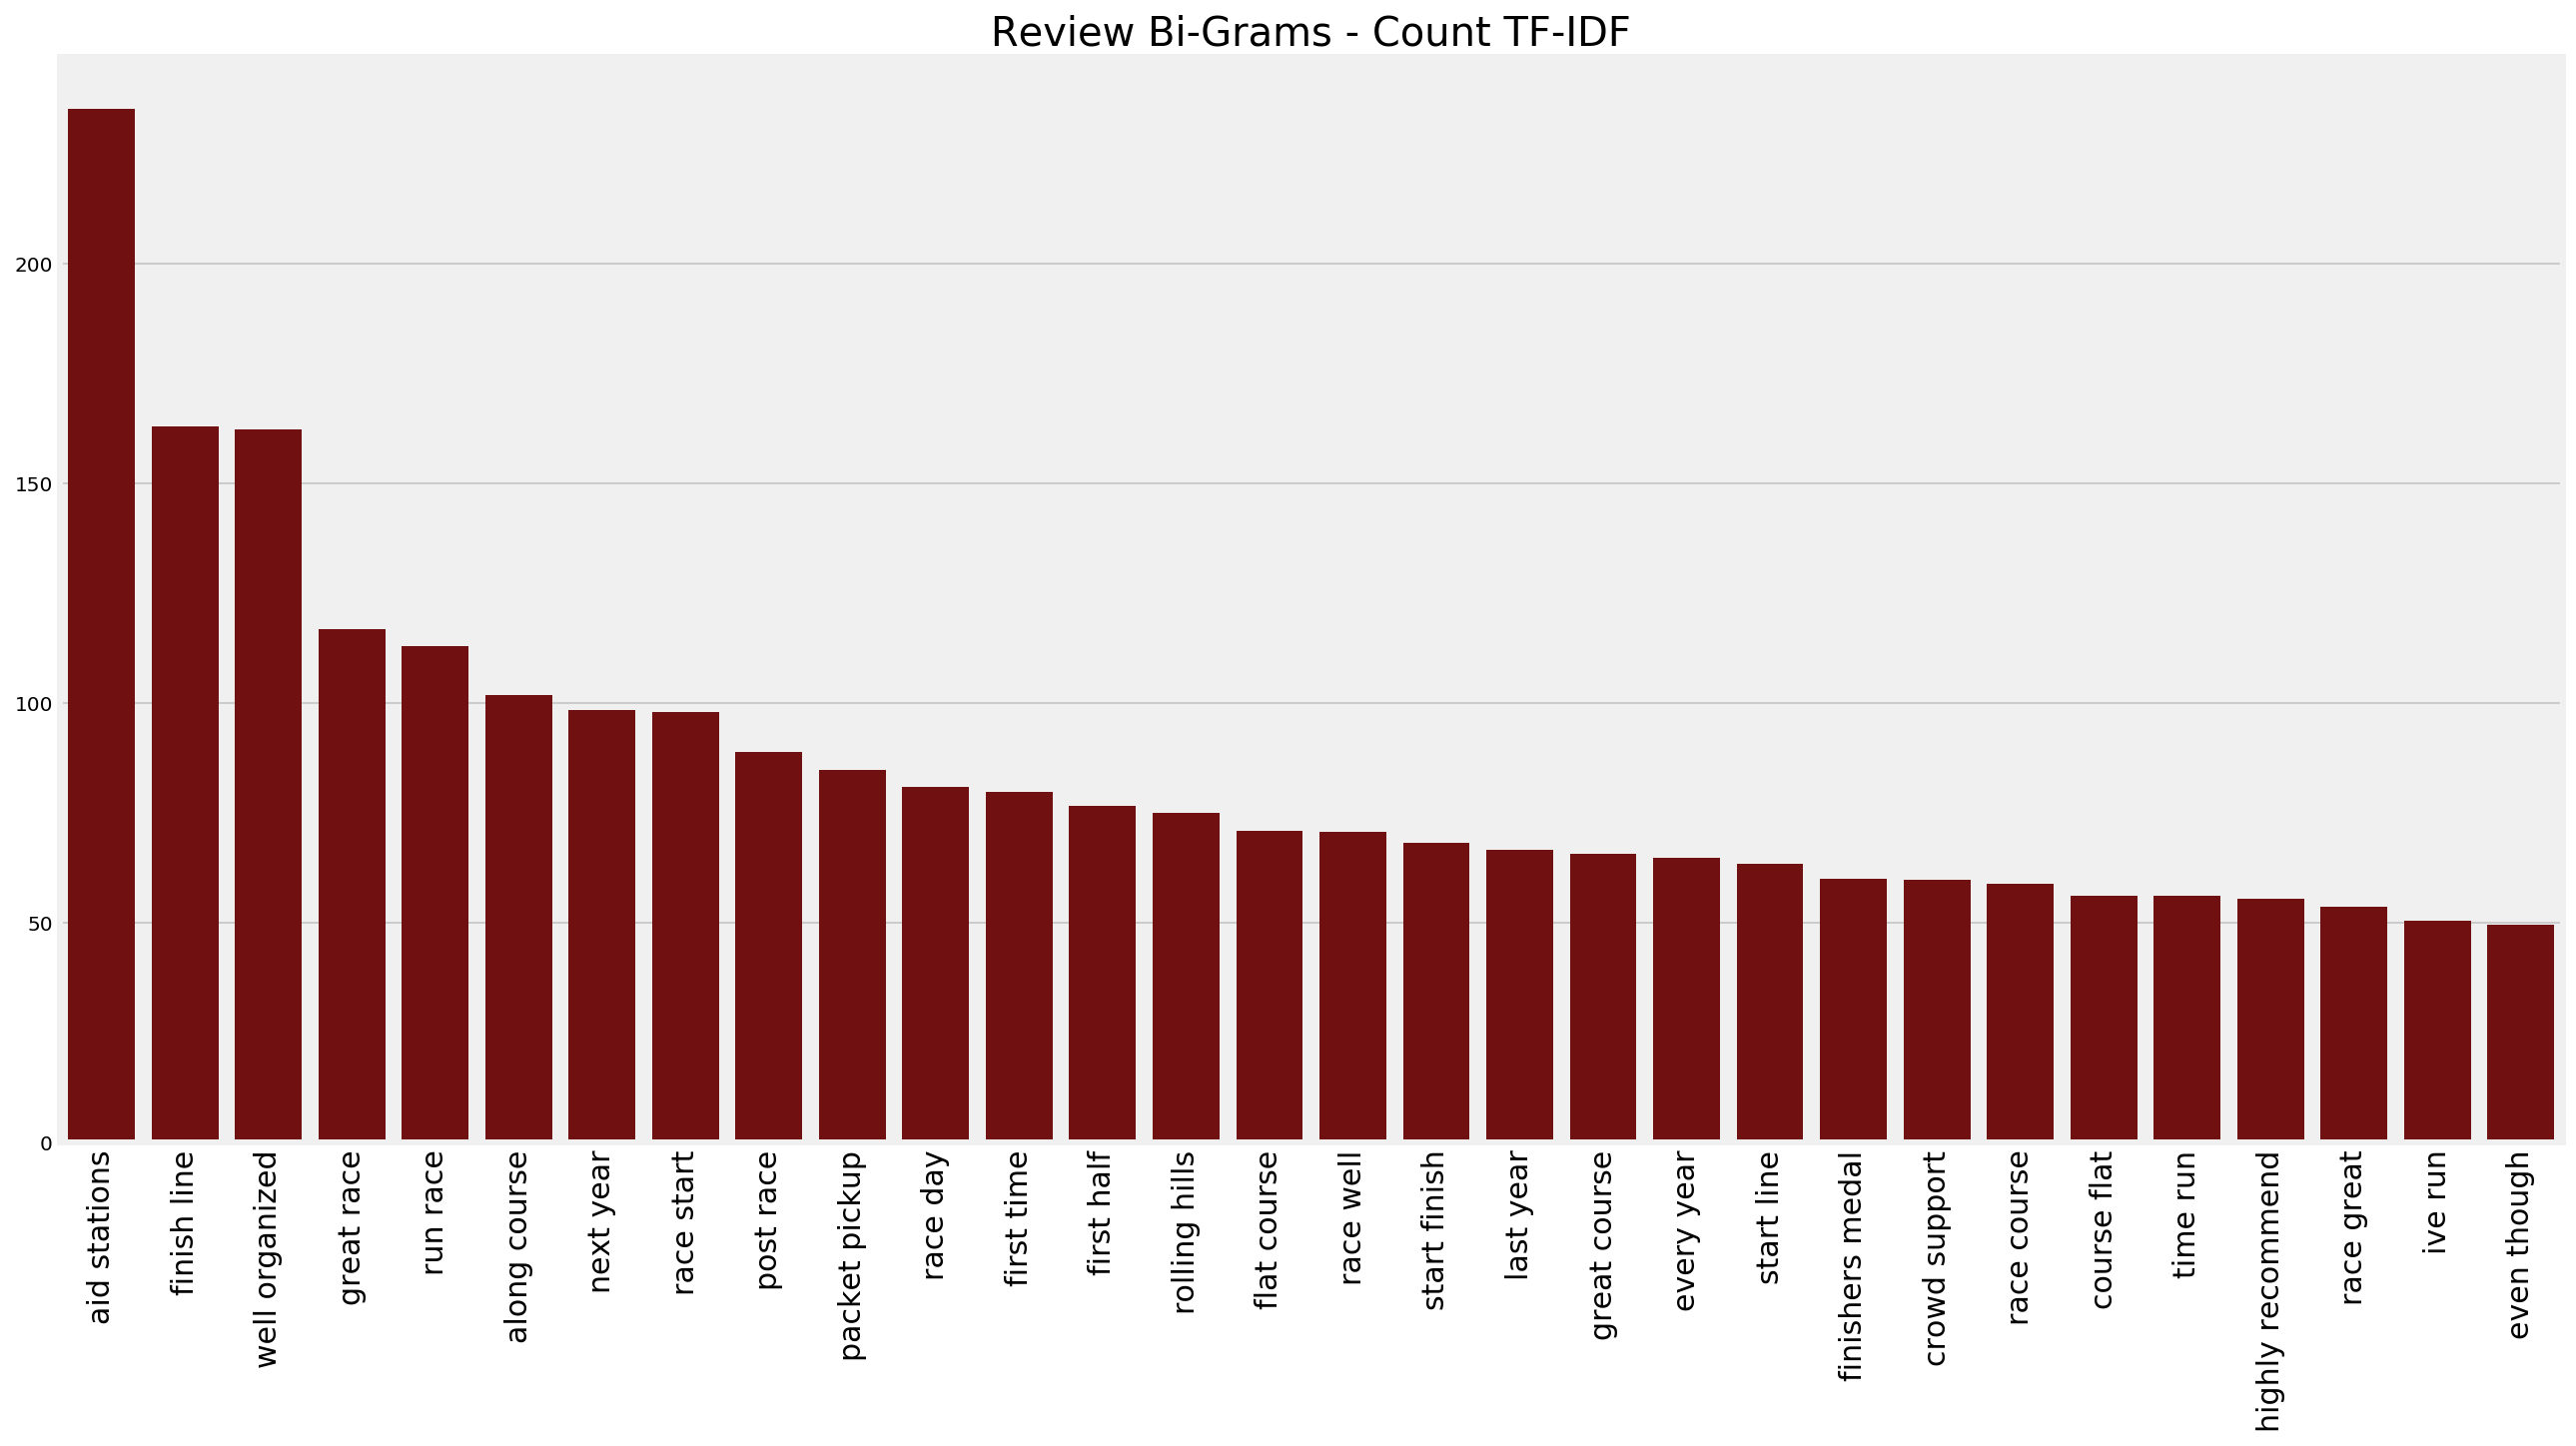

In [35]:
review_vect_df_sum = review_vect_df.sum(axis=0)
review_vect_top30 = review_vect_df_sum.sort_values(ascending=False).head(30)
plt.figure(figsize=(20, 10))
bigram_plot = sns.barplot(review_vect_top30.index, review_vect_top30.values, color='maroon')
bigram_plot.set_title("Review Bi-Grams - Count TF-IDF", fontsize=20)
bigram_plot.set_xticklabels(labels=review_vect_top30.index, rotation=90, fontsize=15);

In [36]:
races_01 = pd.read_csv('./RaceRaves_data/Races_Jun2017.csv')
races_02 = pd.read_csv('./RaceRaves_data/Races_Jul2017.csv')
races_03 = pd.read_csv('./RaceRaves_data/Races_Aug2017.csv')
races_04 = pd.read_csv('./RaceRaves_data/Races_Sep2017.csv')
races_05 = pd.read_csv('./RaceRaves_data/Races_Oct2017.csv')
races_06 = pd.read_csv('./RaceRaves_data/Races_Nov2017.csv')
races_07 = pd.read_csv('./RaceRaves_data/Races_Dec2017.csv')
races_08 = pd.read_csv('./RaceRaves_data/Races_Jan2018.csv')
races_09 = pd.read_csv('./RaceRaves_data/Races_Feb2018.csv')
races_10 = pd.read_csv('./RaceRaves_data/Races_Mar2018.csv')
races_11 = pd.read_csv('./RaceRaves_data/Races_Apr2018.csv')
races_12 = pd.read_csv('./RaceRaves_data/Races_May2018.csv')
all_races = pd.concat([races_01, races_02, races_03, races_04, races_05, races_06,
                       races_07, races_08, races_09, races_10, races_11, races_12])
all_races = all_races.drop('Unnamed: 0', axis=1)
all_races = all_races.reset_index()
all_races.head()

index                                          name  \
0      0  1/2 Sauer 1/2 Kraut Marathon & Half Marathon   
1      1                                50 Yard Finish   
2      2                  AF Canyon Run Against Cancer   
3      3                                      Ahrathon   
4      4        Akron Marathon Race Series 8K & 1-Mile   

                          location    state  region   latitude   longitude  \
0                 Philadelphia, PA       PA      US  40.064667  -75.039211   
1                 Orchard Park, NY       NY      US  42.773266  -78.785857   
2                        Provo, UT       UT      US  40.467662 -111.655065   
3  Bad Neuenahr-Ahrweiler, Germany  Germany  Non-US  50.542630    7.130743   
4                        Akron, OH       OH      US  41.071917  -81.509730   

           date                                          distances  \
0   Jun 4, 2017        ['Marathon, Marathon Relay, Half Marathon']   
1  Jun 24, 2017                                   ['5K, Kids Run']   
2  Jun 23, 2018               ['Half Marathon, 10K, 5K, Kids Run']   
3  Jun 16, 2018  ['Marathon, Half Marathon, Half Marathon Relay...   
4  Jun 30, 2018                                    ['8K, 1 Miler']   

    course type     ...       \
0  Road (Paved)     ...        
1  Road (Paved)     ...        
2  Road (Paved)     ...        
3  Road (Paved)     ...        
4  Road (Paved)     ...        

                                       weather_year5  \
0  {'year': '2017', 'conditions': 'partly-cloudy-...   
1  {'year': '2017', 'conditions': 'rain', 'high':...   
2  {'year': '2017', 'conditions': 'clear-day', 'h...   
3  {'year': '2017', 'conditions': 'partly-cloudy-...   
4  {'year': '2017', 'conditions': 'rain', 'high':...   

                                       weather_year4  \
0  {'year': '2016', 'conditions': 'partly-cloudy-...   
1  {'year': '2016', 'conditions': 'partly-cloudy-...   
2  {'year': '2016', 'conditions': 'clear-day', 'h...   
3  {'year': '2016', 'conditions': 'rain', 'high':...   
4  {'year': '2016', 'conditions': 'partly-cloudy-...   

                                       weather_year3  \
0  {'year': '2015', 'conditions': 'partly-cloudy-...   
1  {'year': '2015', 'conditions': 'partly-cloudy-...   
2  {'year': '2015', 'conditions': 'clear-day', 'h...   
3  {'year': '2015', 'conditions': 'partly-cloudy-...   
4  {'year': '2015', 'conditions': 'rain', 'high':...   

                                       weather_year2  \
0  {'year': '2014', 'conditions': 'partly-cloudy-...   
1  {'year': '2014', 'conditions': 'rain', 'high':...   
2  {'year': '2014', 'conditions': 'clear-day', 'h...   
3  {'year': '2014', 'conditions': 'partly-cloudy-...   
4  {'year': '2014', 'conditions': 'partly-cloudy-...   

                                       weather_year1 overall_rating  \
0  {'year': '2013', 'conditions': 'clear-day', 'h...            0.0   
1  {'year': '2013', 'conditions': 'partly-cloudy-...            0.0   
2  {'year': '2013', 'conditions': 'clear-day', 'h...            5.0   
3  {'year': '2013', 'conditions': 'partly-cloudy-...            5.0   
4  {'year': '2013', 'conditions': 'partly-cloudy-...            0.0   

  diff_rating scenery_rating  prod_rating  swag_rating  
0         0.0            0.0          0.0          0.0  
1         0.0            0.0          0.0          0.0  
2         1.0            5.0          5.0          5.0  
3         4.0            5.0          5.0          4.0  
4         0.0            0.0          0.0          0.0  

[5 rows x 23 columns]

In [37]:
all_races['description'].head()

0     This year some big city Marathons will cost y...
1     The 50 Yard Finish 5K race will began at 9:00...
2     The AF Canyon Run Against Cancer is a premier...
3     From the starting point in the Dahliengarten,...
4     Kick off the Akron Children’s Hospital Akron ...
Name: description, dtype: object

In [38]:
descriptions = list(all_races['description'])
for i in range(len(descriptions)):
    try:
        description_split = descriptions[i].split(" ")
        description_fixed = [fix_words(''.join(e for e in word if e.isalnum())) for word in description_split]
        description_joined = " ".join(description_fixed)
        descriptions[i] = description_joined
    except:
        continue
all_races['description'] = descriptions

In [39]:
race_desc = all_races[['name', 'description']].dropna()
desc_vect = TfidfVectorizer(ngram_range=(2, 2), stop_words=my_stopwords, min_df=25, max_df=0.3)

X = desc_vect.fit_transform(race_desc['description'])

desc_vect_df = pd.DataFrame(X.toarray(), columns=desc_vect.get_feature_names())
desc_vect_names = desc_vect.get_feature_names()
desc_vect_df.head()

accurately measured  age division  age group  age groups  ages abilities  \
0                  0.0           0.0        0.0         0.0             0.0   
1                  0.0           0.0        0.0         0.0             0.0   
2                  0.0           0.0        0.0         0.0             0.0   
3                  0.0           0.0        0.0         0.0             0.0   
4                  0.0           0.0        0.0         0.0             0.0   

   aid aid  aid bottle  aid gatorade  aid station  aid stations    ...      \
0      0.0         0.0           0.0          0.0      0.317087    ...       
1      0.0         0.0           0.0          0.0      0.000000    ...       
2      0.0         0.0           0.0          0.0      0.000000    ...       
3      0.0         0.0           0.0          0.0      0.000000    ...       
4      0.0         0.0           0.0          0.0      0.000000    ...       

   year race  year run  year year  years ago  years event  years old  \
0        0.0       0.0        0.0        0.0          0.0        0.0   
1        0.0       0.0        0.0        0.0          0.0        0.0   
2        0.0       0.0        0.0        0.0          0.0        0.0   
3        0.0       0.0        0.0        0.0          0.0        0.0   
4        0.0       0.0        0.0        0.0          0.0        0.0   

   years race  youll enjoy  youll get  youll run  
0         0.0          0.0        0.0        0.0  
1         0.0          0.0        0.0        0.0  
2         0.0          0.0        0.0        0.0  
3         0.0          0.0        0.0        0.0  
4         0.0          0.0        0.0        0.0  

[5 rows x 676 columns]

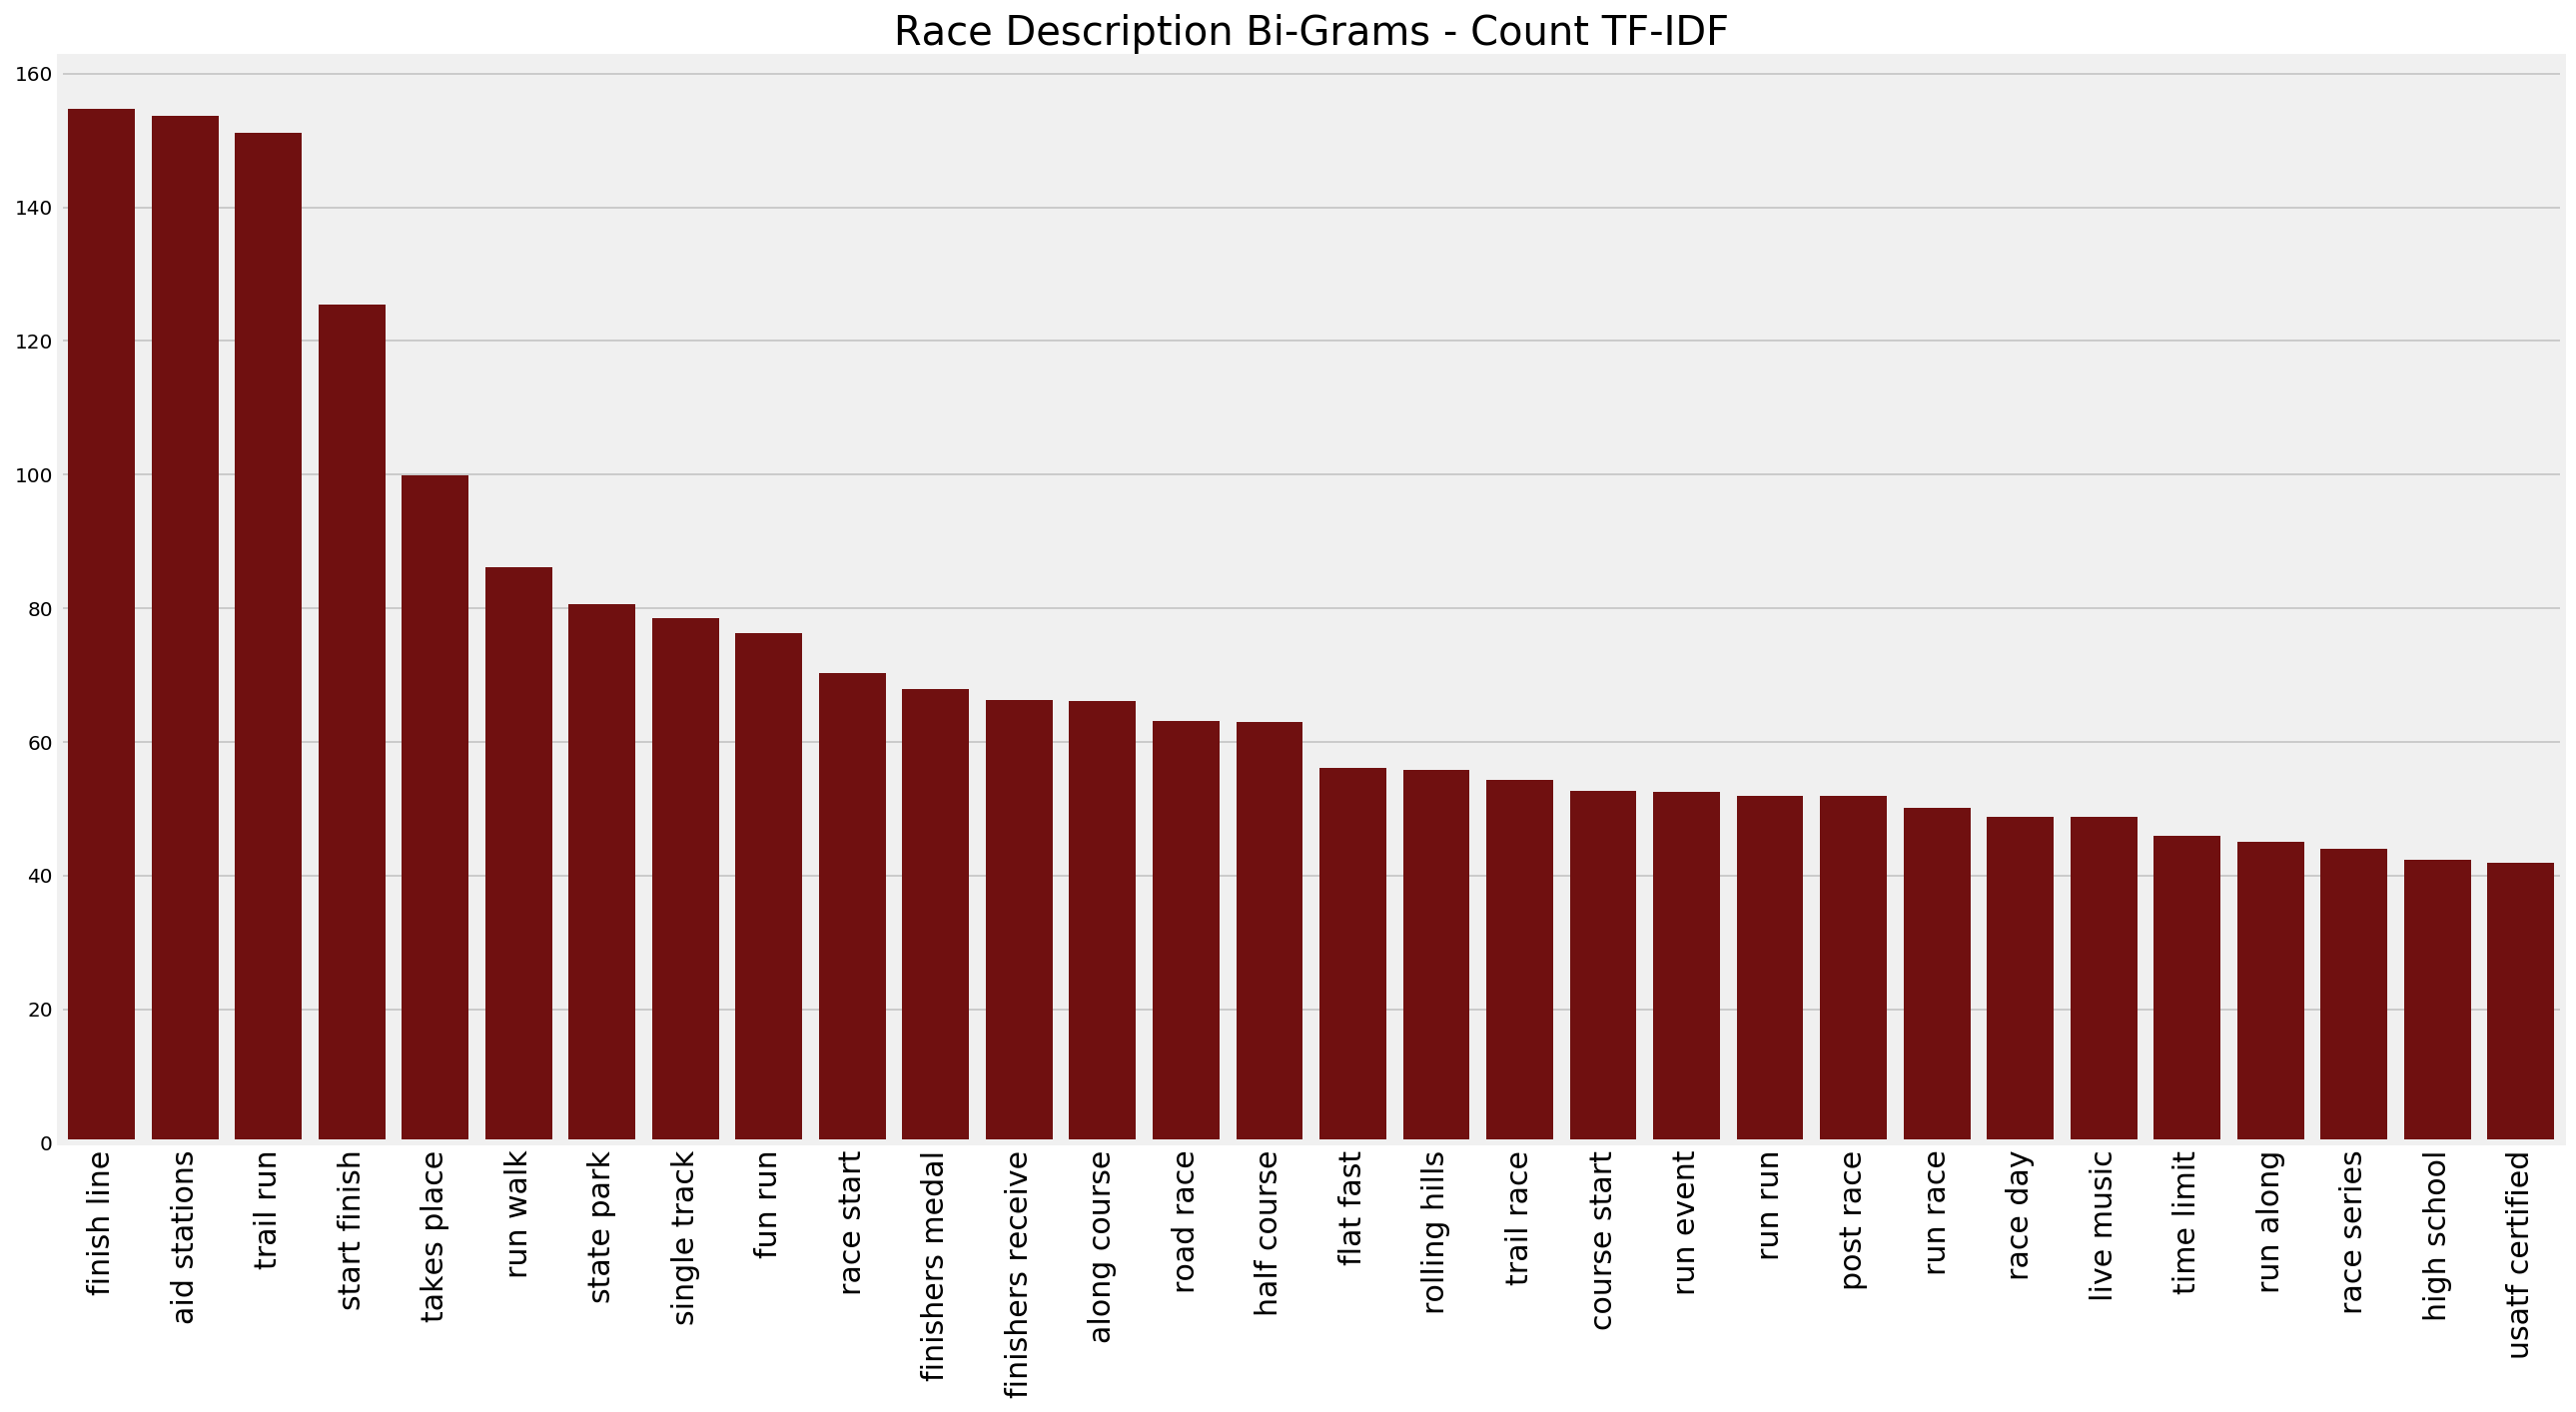

In [40]:
desc_vect_df_sum = desc_vect_df.sum(axis=0)
desc_vect_top30 = desc_vect_df_sum.sort_values(ascending=False).head(30)
plt.figure(figsize=(20, 10))
bigram_plot = sns.barplot(desc_vect_top30.index, desc_vect_top30.values, color='maroon')
bigram_plot.set_title("Race Description Bi-Grams - Count TF-IDF", fontsize=20)
bigram_plot.set_xticklabels(labels=desc_vect_top30.index, rotation=90, fontsize=15);

In [41]:
# lda = LatentDirichletAllocation(n_components=8, random_state=242, learning_method='batch', max_iter=100)
# lda.fit(desc_vect_df)

In [42]:
# def print_top_words(model, feature_names, n_top_words):
#     for topic_idx, topic in enumerate(model.components_):
#         message = "Topic #%d:\n" % topic_idx
#         message += "\n".join([feature_names[i] + ' (' + str(round(topic[i],0)) + ')'
#                              for i in topic.argsort()[:-n_top_words - 1:-1]])
#         print(message)
#         print()

# vect_feature_names = vect.get_feature_names()
# print_top_words(lda, vect_feature_names, 20)

In [43]:
# topic_columns = ['Topic_{}'.format(i) for i in range(lda.components_.shape[0])]
# df_topics = pd.DataFrame(lda.transform(desc_vect_df), columns=topic_columns)
# df_topics.describe().T

In [44]:
# df_topics['Max_Topic'] = df_topics.idxmax(axis=1)   
# df_topics.head()

In [45]:
# df_topics['Max_Topic'].value_counts()

In [46]:
# df_topics.groupby('Max_Topic')[topic_columns].mean()

In [47]:
# ratings_plus_name = ratings + ['name']
# race_ratings = all_races[ratings_plus_name]
# race_ratings = race_ratings[race_ratings['overall_rating'] > 0]
# race_ratings.head()

In [48]:
# race_topics = pd.concat([race_desc, df_topics], axis=1)
# race_topics.head()

In [49]:
# topic_ratings = pd.merge(left=race_topics, right=race_ratings, on='name')
# topic_ratings.head()

In [50]:
# topic_ratings.groupby('Max_Topic')[ratings].describe().T

In [51]:
lda = LatentDirichletAllocation(n_components=15, random_state=18, learning_method='batch', max_iter=100)
review_vect_lda = lda.fit(review_vect_df)

In [52]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d:\n" % topic_idx
        message += "\n".join([feature_names[i] + ' (' + str(round(topic[i],0)) + ')'
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
        print()

print_top_words(lda, review_vect_names, 20)

Topic #0:
age group (26.0)
run race (24.0)
good race (24.0)
well run (19.0)
awesome race (19.0)
course hilly (18.0)
ive run (18.0)
wine country (16.0)
overall good (16.0)
wine tasting (15.0)
previous years (14.0)
race every (14.0)
cant beat (14.0)
make sure (13.0)
group awards (13.0)
pr course (13.0)
new york (12.0)
race support (12.0)
made race (12.0)
forward run (12.0)

Topic #1:
mostly flat (34.0)
vacation races (28.0)
flat course (26.0)
course mostly (26.0)
aid stations (22.0)
crowd support (21.0)
along river (20.0)
entire race (18.0)
run along (17.0)
along course (16.0)
beautiful scenery (16.0)
challenging course (15.0)
first race (15.0)
stations every (15.0)
course pretty (15.0)
course along (13.0)
support along (13.0)
whole course (13.0)
pretty flat (13.0)
prior race (12.0)

Topic #2:
time run (38.0)
first time (37.0)
great time (35.0)
relatively flat (26.0)
long beach (21.0)
scenery beautiful (17.0)
time race (16.0)
course relatively (16.0)
good time (15.0)
beautiful course (15

In [53]:
topic_columns = ['Topic_{}'.format(i) for i in range(lda.components_.shape[0])]
review_topics = pd.DataFrame(lda.transform(review_vect_df), columns=topic_columns)
review_topics.describe().T

count      mean       std       min       25%       50%       75%  \
Topic_0   6414.0  0.061465  0.119379  0.008102  0.017649  0.022253  0.028132   
Topic_1   6414.0  0.067436  0.129625  0.007913  0.017703  0.022287  0.033333   
Topic_2   6414.0  0.062522  0.116947  0.008313  0.017721  0.022290  0.033333   
Topic_3   6414.0  0.069440  0.133860  0.007912  0.018340  0.022308  0.033333   
Topic_4   6414.0  0.062333  0.118165  0.008506  0.017913  0.022288  0.028533   
Topic_5   6414.0  0.060179  0.115675  0.007912  0.017624  0.022254  0.028163   
Topic_6   6414.0  0.061428  0.116604  0.008102  0.017655  0.022267  0.028489   
Topic_7   6414.0  0.068058  0.130771  0.007912  0.017829  0.022303  0.033333   
Topic_8   6414.0  0.065062  0.128123  0.007912  0.017771  0.022271  0.028141   
Topic_9   6414.0  0.061486  0.117208  0.007912  0.017714  0.022272  0.028321   
Topic_10  6414.0  0.078471  0.144559  0.007913  0.018385  0.022395  0.033333   
Topic_11  6414.0  0.063743  0.126435  0.007912  0.017685  0.022259  0.028080   
Topic_12  6414.0  0.072429  0.137260  0.008102  0.018314  0.022339  0.033333   
Topic_13  6414.0  0.079679  0.143651  0.008102  0.018450  0.022443  0.033333   
Topic_14  6414.0  0.066269  0.126225  0.008314  0.017788  0.022289  0.033333   

               max  
Topic_0   0.772493  
Topic_1   0.778738  
Topic_2   0.775496  
Topic_3   0.864289  
Topic_4   0.764530  
Topic_5   0.789091  
Topic_6   0.755534  
Topic_7   0.771377  
Topic_8   0.797609  
Topic_9   0.761885  
Topic_10  0.794719  
Topic_11  0.809906  
Topic_12  0.793913  
Topic_13  0.815895  
Topic_14  0.815267

In [54]:
review_topics['Max_Topic'] = review_topics.idxmax(axis=1)   
review_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995  0.608067   
1  0.022384  0.022384  0.022384  0.022384  0.022384  0.022384  0.022384   
2  0.020694  0.020694  0.020694  0.020694  0.020694  0.020694  0.020694   
3  0.020749  0.020749  0.020749  0.020749  0.020749  0.020749  0.020749   
4  0.021746  0.346840  0.021746  0.021746  0.021746  0.370461  0.021747   

    Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
0  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995   
1  0.022384  0.022384  0.022384  0.022384  0.022384  0.686629  0.022384   
2  0.020694  0.200708  0.020694  0.020694  0.020694  0.530270  0.020694   
3  0.020749  0.709514  0.020749  0.020749  0.020749  0.020749  0.020749   
4  0.021746  0.021746  0.021746  0.021746  0.021746  0.021746  0.021746   

   Topic_14 Max_Topic  
0  0.027995   Topic_6  
1  0.022384  Topic_12  
2  0.020694  Topic_12  
3  0.020749   Topic_8  
4  0.021746   Topic_5

In [55]:
review_topics['Max_Topic'].value_counts()

Topic_0     613
Topic_13    589
Topic_10    543
Topic_12    474
Topic_3     452
Topic_7     428
Topic_14    417
Topic_1     412
Topic_8     393
Topic_11    385
Topic_4     367
Topic_2     355
Topic_6     334
Topic_9     330
Topic_5     322
Name: Max_Topic, dtype: int64

In [56]:
review_topics.groupby('Max_Topic')[topic_columns].mean()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
Max_Topic                                                               
Topic_0    0.311030  0.049073  0.051818  0.048867  0.047070  0.051407   
Topic_1    0.038365  0.501915  0.039800  0.031005  0.035070  0.041236   
Topic_10   0.033702  0.034007  0.034595  0.040301  0.035238  0.034774   
Topic_11   0.037808  0.035353  0.037799  0.030308  0.038618  0.034285   
Topic_12   0.029845  0.037090  0.036467  0.039295  0.033810  0.030689   
Topic_13   0.032057  0.041520  0.037100  0.038563  0.036312  0.034857   
Topic_14   0.037437  0.031326  0.036167  0.036674  0.032261  0.036637   
Topic_2    0.033580  0.039480  0.471832  0.033548  0.039445  0.048158   
Topic_3    0.029720  0.034553  0.038359  0.497543  0.037258  0.028643   
Topic_4    0.039220  0.035436  0.038973  0.035905  0.475697  0.040447   
Topic_5    0.043035  0.035877  0.038891  0.033252  0.035481  0.490870   
Topic_6    0.034505  0.035594  0.035886  0.034586  0.039073  0.035548   
Topic_7    0.035574  0.035408  0.038543  0.030793  0.036811  0.034657   
Topic_8    0.034999  0.037471  0.035031  0.038123  0.033700  0.030395   
Topic_9    0.036854  0.037970  0.034491  0.036609  0.038585  0.040759   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
Max_Topic                                                               
Topic_0    0.047285  0.050852  0.046687  0.050948  0.048176  0.048767   
Topic_1    0.033903  0.037594  0.034572  0.034876  0.039654  0.033696   
Topic_10   0.034413  0.032819  0.037489  0.038832  0.497331  0.034931   
Topic_11   0.035122  0.032089  0.033079  0.034579  0.038046  0.505927   
Topic_12   0.038980  0.034616  0.031177  0.039319  0.033232  0.034080   
Topic_13   0.036554  0.040548  0.036460  0.036892  0.041781  0.033972   
Topic_14   0.042601  0.035746  0.036884  0.038168  0.038573  0.031092   
Topic_2    0.038102  0.039498  0.040981  0.036472  0.037253  0.032962   
Topic_3    0.034435  0.032789  0.033881  0.036969  0.043296  0.036351   
Topic_4    0.045225  0.031801  0.034515  0.035275  0.043276  0.034946   
Topic_5    0.039461  0.042245  0.034624  0.033442  0.034879  0.033592   
Topic_6    0.481109  0.035708  0.033825  0.038581  0.035590  0.039390   
Topic_7    0.038972  0.499454  0.035849  0.037527  0.038938  0.032482   
Topic_8    0.038234  0.033247  0.504670  0.033810  0.040972  0.029166   
Topic_9    0.031139  0.035196  0.033528  0.492381  0.035574  0.036054   

           Topic_12  Topic_13  Topic_14  
Max_Topic                                
Topic_0    0.049620  0.050463  0.047939  
Topic_1    0.033230  0.035450  0.029633  
Topic_10   0.033617  0.040130  0.037822  
Topic_11   0.039511  0.036193  0.031283  
Topic_12   0.502736  0.041157  0.037508  
Topic_13   0.037060  0.476609  0.039715  
Topic_14   0.038887  0.043062  0.484485  
Topic_2    0.040338  0.037584  0.030767  
Topic_3    0.033825  0.042455  0.039925  
Topic_4    0.035546  0.037561  0.036178  
Topic_5    0.037852  0.033502  0.032998  
Topic_6    0.039097  0.038811  0.042700  
Topic_7    0.037040  0.035093  0.032860  
Topic_8    0.038759  0.035189  0.036235  
Topic_9    0.035330  0.038459  0.037071

In [57]:
ratings_plus_name = ratings + ['race_name']
race_ratings = race_review_df[ratings_plus_name]
# race_ratings = race_ratings[race_ratings['overall_rating'] > 0]
race_ratings = race_ratings.reset_index(drop=True)
race_ratings.head()

overall_rating  diff_rating  scenery_rating  prod_rating  swag_rating  \
0             4.0          3.0             4.0          4.0          4.0   
1             5.0          5.0             5.0          5.0          5.0   
2             5.0          4.0             4.0          5.0          3.0   
3             5.0          1.0             5.0          4.0          4.0   
4             3.0          3.0             4.0          4.0          2.0   

                            race_name  
0    Tustin Hangar Half Marathon & 5K  
1  Surf City Marathon & Half Marathon  
2         Hamilton Marathon Road2Hope  
3  Surf City Marathon & Half Marathon  
4                     Mission Inn Run

In [58]:
race_topics = pd.concat([race_ratings, review_topics['Max_Topic']], axis=1)
race_topics.head()

overall_rating  diff_rating  scenery_rating  prod_rating  swag_rating  \
0             4.0          3.0             4.0          4.0          4.0   
1             5.0          5.0             5.0          5.0          5.0   
2             5.0          4.0             4.0          5.0          3.0   
3             5.0          1.0             5.0          4.0          4.0   
4             3.0          3.0             4.0          4.0          2.0   

                            race_name Max_Topic  
0    Tustin Hangar Half Marathon & 5K   Topic_6  
1  Surf City Marathon & Half Marathon  Topic_12  
2         Hamilton Marathon Road2Hope  Topic_12  
3  Surf City Marathon & Half Marathon   Topic_8  
4                     Mission Inn Run   Topic_5

In [59]:
race_topics.groupby('Max_Topic')[ratings].describe().T

Max_Topic                Topic_0     Topic_1    Topic_10    Topic_11  \
overall_rating count  613.000000  412.000000  543.000000  385.000000   
               mean     4.146819    4.296117    4.296501    4.314286   
               std      0.909990    0.807317    0.786490    0.821222   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    4.000000    4.000000    4.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  613.000000  412.000000  543.000000  385.000000   
               mean     2.969005    2.847087    2.928177    2.911688   
               std      1.206201    1.207606    1.176491    1.195693   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.000000    2.000000    2.000000    2.000000   
               50%      3.000000    3.000000    3.000000    3.000000   
               75%      4.000000    4.000000    4.000000    4.000000   
               max      5.000000    5.000000    5.000000    5.000000   
scenery_rating count  613.000000  412.000000  543.000000  385.000000   
               mean     3.856444    3.995146    3.924494    3.919481   
               std      1.127035    1.048682    1.036158    1.066175   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.000000    3.000000    3.000000    3.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
prod_rating    count  613.000000  412.000000  543.000000  385.000000   
               mean     4.141925    4.300971    4.314917    4.337662   
               std      1.013514    0.947117    0.893962    0.872174   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    4.000000    4.000000    4.000000   
               50%      4.000000    5.000000    5.000000    5.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
swag_rating    count  613.000000  412.000000  543.000000  385.000000   
               mean     3.849918    3.917476    3.935543    3.914286   
               std      1.129081    1.066173    1.073622    1.038543   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.000000    3.000000    3.000000    3.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   

Max_Topic               Topic_12    Topic_13    Topic_14     Topic_2  \
overall_rating count  474.000000  589.000000  417.000000  355.000000   
               mean     4.234177    3.930390    4.196643    4.211268   
               std      0.823808    0.996717    0.817294    0.838944   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    3.000000    4.000000    4.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  474.000000  589.000000  417.000000  355.000000   
               mean     2.854430    2.808149    2.889688    2.785915   
               std      1.238013    1.184739    1.152887    1.114529   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.000000    2.000000    2.000000    2.000000   
               50%      3.000000    3.0

In [60]:
# race_review_text = race_review_df['text']
# race_review_matrix = race_review_text.as_matrix()
# race_review_preprocessed = []
# for i in range(len(race_review_matrix)):
#     preprocessed = simple_preprocess(race_review_matrix[i], deacc=True)
#     new_row = []
#     for j in range(len(preprocessed)):
#         if preprocessed[j] not in my_stopwords:
#             new_row.append(preprocessed[j])
#         else:
#             continue
#     race_review_preprocessed.append(new_row)
# race_review_preprocessed[0:5]

In [61]:
# dictionary = Dictionary(race_review_preprocessed)
# corpus = [dictionary.doc2bow(text) for text in race_review_preprocessed]

In [62]:
# ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, random_state=33, )

In [63]:
# ldamodel.show_topics()

In [64]:
# race_desc_text = race_desc['description']
# race_desc_matrix = race_desc_text.as_matrix()
# race_desc_preprocessed = []
# for i in range(len(race_desc_matrix)):
#     preprocessed = simple_preprocess(race_desc_matrix[i], deacc=True)
#     new_row = []
#     for j in range(len(preprocessed)):
#         if preprocessed[j] not in my_stopwords:
#             new_row.append(preprocessed[j])
#         else:
#             continue
#     race_desc_preprocessed.append(new_row)
# race_desc_preprocessed[0:5]

In [65]:
# dictionary = Dictionary(race_desc_preprocessed)
# corpus = [dictionary.doc2bow(text) for text in race_desc_preprocessed]

In [66]:
# ldamodel = LdaModel(corpus=corpus, num_topics=10, id2word=dictionary, random_state=33, )

In [67]:
# ldamodel.show_topics()

In [68]:
race_review_df['high_overall'] = race_review_df['overall_rating'].map(lambda x: 1 if x > 4 else 0)
race_review_df['high_overall'].mean()

0.4471468662301216

In [69]:
y = race_review_df['high_overall']

In [70]:
X_train, X_test, y_train, y_test = train_test_split(review_vect_df, y, stratify=y, random_state=53)

In [71]:
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

nb = MultinomialNB(fit_prior=False, alpha=0.2)
nb.fit(X_train, y_train)
print('Multinomial Score:', nb.score(X_train, y_train))

Multinomial Score: 0.7166320166320166


In [72]:
nb.score(X_test, y_test)

0.6452618453865336

In [73]:
race_review_df['race_name'].unique().shape

(2103,)

In [74]:
review_vect_df2 = review_vect.transform(race_review_df['text'])
review_topics = pd.DataFrame(lda.transform(review_vect_df2), columns=topic_columns)
review_topics.describe().T

count      mean       std       min       25%       50%       75%  \
Topic_0   6414.0  0.061465  0.119379  0.008102  0.017649  0.022253  0.028132   
Topic_1   6414.0  0.067436  0.129625  0.007913  0.017703  0.022287  0.033333   
Topic_2   6414.0  0.062522  0.116947  0.008313  0.017721  0.022290  0.033333   
Topic_3   6414.0  0.069440  0.133860  0.007912  0.018340  0.022308  0.033333   
Topic_4   6414.0  0.062333  0.118165  0.008506  0.017913  0.022288  0.028533   
Topic_5   6414.0  0.060179  0.115675  0.007912  0.017624  0.022254  0.028163   
Topic_6   6414.0  0.061428  0.116604  0.008102  0.017655  0.022267  0.028489   
Topic_7   6414.0  0.068058  0.130771  0.007912  0.017829  0.022303  0.033333   
Topic_8   6414.0  0.065062  0.128123  0.007912  0.017771  0.022271  0.028141   
Topic_9   6414.0  0.061486  0.117208  0.007912  0.017714  0.022272  0.028321   
Topic_10  6414.0  0.078471  0.144559  0.007913  0.018385  0.022395  0.033333   
Topic_11  6414.0  0.063743  0.126435  0.007912  0.017685  0.022259  0.028080   
Topic_12  6414.0  0.072429  0.137260  0.008102  0.018314  0.022339  0.033333   
Topic_13  6414.0  0.079679  0.143651  0.008102  0.018450  0.022443  0.033333   
Topic_14  6414.0  0.066269  0.126225  0.008314  0.017788  0.022289  0.033333   

               max  
Topic_0   0.772493  
Topic_1   0.778738  
Topic_2   0.775496  
Topic_3   0.864289  
Topic_4   0.764530  
Topic_5   0.789091  
Topic_6   0.755534  
Topic_7   0.771377  
Topic_8   0.797609  
Topic_9   0.761885  
Topic_10  0.794719  
Topic_11  0.809906  
Topic_12  0.793913  
Topic_13  0.815895  
Topic_14  0.815267

In [75]:
review_topics['Max_Topic'] = review_topics.idxmax(axis=1)   
review_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995  0.608067   
1  0.022384  0.022384  0.022384  0.022384  0.022384  0.022384  0.022384   
2  0.020694  0.020694  0.020694  0.020694  0.020694  0.020694  0.020694   
3  0.020749  0.020749  0.020749  0.020749  0.020749  0.020749  0.020749   
4  0.021746  0.346840  0.021746  0.021746  0.021746  0.370461  0.021747   

    Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
0  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995   
1  0.022384  0.022384  0.022384  0.022384  0.022384  0.686629  0.022384   
2  0.020694  0.200708  0.020694  0.020694  0.020694  0.530270  0.020694   
3  0.020749  0.709514  0.020749  0.020749  0.020749  0.020749  0.020749   
4  0.021746  0.021746  0.021746  0.021746  0.021746  0.021746  0.021746   

   Topic_14 Max_Topic  
0  0.027995   Topic_6  
1  0.022384  Topic_12  
2  0.020694  Topic_12  
3  0.020749   Topic_8  
4  0.021746   Topic_5

In [76]:
review_topics['Max_Topic'].value_counts()

Topic_0     613
Topic_13    589
Topic_10    543
Topic_12    474
Topic_3     452
Topic_7     428
Topic_14    417
Topic_1     412
Topic_8     393
Topic_11    385
Topic_4     367
Topic_2     355
Topic_6     334
Topic_9     330
Topic_5     322
Name: Max_Topic, dtype: int64

In [77]:
review_topics.groupby('Max_Topic')[topic_columns].mean()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
Max_Topic                                                               
Topic_0    0.311030  0.049073  0.051818  0.048867  0.047070  0.051407   
Topic_1    0.038365  0.501915  0.039800  0.031005  0.035070  0.041236   
Topic_10   0.033702  0.034007  0.034595  0.040301  0.035238  0.034774   
Topic_11   0.037808  0.035353  0.037799  0.030308  0.038618  0.034285   
Topic_12   0.029845  0.037090  0.036467  0.039295  0.033810  0.030689   
Topic_13   0.032057  0.041520  0.037100  0.038563  0.036312  0.034857   
Topic_14   0.037437  0.031326  0.036167  0.036674  0.032261  0.036637   
Topic_2    0.033580  0.039480  0.471832  0.033548  0.039445  0.048158   
Topic_3    0.029720  0.034553  0.038359  0.497543  0.037258  0.028643   
Topic_4    0.039220  0.035436  0.038973  0.035905  0.475697  0.040447   
Topic_5    0.043035  0.035877  0.038891  0.033252  0.035481  0.490870   
Topic_6    0.034505  0.035594  0.035886  0.034586  0.039073  0.035548   
Topic_7    0.035574  0.035408  0.038543  0.030793  0.036811  0.034657   
Topic_8    0.034999  0.037471  0.035031  0.038123  0.033700  0.030395   
Topic_9    0.036854  0.037970  0.034491  0.036609  0.038585  0.040759   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
Max_Topic                                                               
Topic_0    0.047285  0.050852  0.046687  0.050948  0.048176  0.048767   
Topic_1    0.033903  0.037594  0.034572  0.034876  0.039654  0.033696   
Topic_10   0.034413  0.032819  0.037489  0.038832  0.497331  0.034931   
Topic_11   0.035122  0.032089  0.033079  0.034579  0.038046  0.505927   
Topic_12   0.038980  0.034616  0.031177  0.039319  0.033232  0.034080   
Topic_13   0.036554  0.040548  0.036460  0.036892  0.041781  0.033972   
Topic_14   0.042601  0.035746  0.036884  0.038168  0.038573  0.031092   
Topic_2    0.038102  0.039498  0.040981  0.036472  0.037253  0.032962   
Topic_3    0.034435  0.032789  0.033881  0.036969  0.043296  0.036351   
Topic_4    0.045225  0.031801  0.034515  0.035275  0.043276  0.034946   
Topic_5    0.039461  0.042245  0.034624  0.033442  0.034879  0.033592   
Topic_6    0.481109  0.035708  0.033825  0.038581  0.035590  0.039390   
Topic_7    0.038972  0.499454  0.035849  0.037527  0.038938  0.032482   
Topic_8    0.038234  0.033247  0.504670  0.033810  0.040972  0.029166   
Topic_9    0.031139  0.035196  0.033528  0.492381  0.035574  0.036054   

           Topic_12  Topic_13  Topic_14  
Max_Topic                                
Topic_0    0.049620  0.050463  0.047939  
Topic_1    0.033230  0.035450  0.029633  
Topic_10   0.033617  0.040130  0.037822  
Topic_11   0.039511  0.036193  0.031283  
Topic_12   0.502736  0.041157  0.037508  
Topic_13   0.037060  0.476609  0.039715  
Topic_14   0.038887  0.043062  0.484485  
Topic_2    0.040338  0.037584  0.030767  
Topic_3    0.033825  0.042455  0.039925  
Topic_4    0.035546  0.037561  0.036178  
Topic_5    0.037852  0.033502  0.032998  
Topic_6    0.039097  0.038811  0.042700  
Topic_7    0.037040  0.035093  0.032860  
Topic_8    0.038759  0.035189  0.036235  
Topic_9    0.035330  0.038459  0.037071

In [78]:
ratings_plus_name = ratings + ['race_name']
race_ratings = race_review_df[ratings_plus_name]
race_ratings = race_ratings.reset_index(drop=True)
race_ratings.head()

overall_rating  diff_rating  scenery_rating  prod_rating  swag_rating  \
0             4.0          3.0             4.0          4.0          4.0   
1             5.0          5.0             5.0          5.0          5.0   
2             5.0          4.0             4.0          5.0          3.0   
3             5.0          1.0             5.0          4.0          4.0   
4             3.0          3.0             4.0          4.0          2.0   

                            race_name  
0    Tustin Hangar Half Marathon & 5K  
1  Surf City Marathon & Half Marathon  
2         Hamilton Marathon Road2Hope  
3  Surf City Marathon & Half Marathon  
4                     Mission Inn Run

In [79]:
race_topics = pd.concat([race_ratings, review_topics['Max_Topic']], axis=1)
race_topics.head()

overall_rating  diff_rating  scenery_rating  prod_rating  swag_rating  \
0             4.0          3.0             4.0          4.0          4.0   
1             5.0          5.0             5.0          5.0          5.0   
2             5.0          4.0             4.0          5.0          3.0   
3             5.0          1.0             5.0          4.0          4.0   
4             3.0          3.0             4.0          4.0          2.0   

                            race_name Max_Topic  
0    Tustin Hangar Half Marathon & 5K   Topic_6  
1  Surf City Marathon & Half Marathon  Topic_12  
2         Hamilton Marathon Road2Hope  Topic_12  
3  Surf City Marathon & Half Marathon   Topic_8  
4                     Mission Inn Run   Topic_5

In [80]:
race_topics.groupby('Max_Topic')[ratings].describe().T

Max_Topic                Topic_0     Topic_1    Topic_10    Topic_11  \
overall_rating count  613.000000  412.000000  543.000000  385.000000   
               mean     4.146819    4.296117    4.296501    4.314286   
               std      0.909990    0.807317    0.786490    0.821222   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    4.000000    4.000000    4.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  613.000000  412.000000  543.000000  385.000000   
               mean     2.969005    2.847087    2.928177    2.911688   
               std      1.206201    1.207606    1.176491    1.195693   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.000000    2.000000    2.000000    2.000000   
               50%      3.000000    3.000000    3.000000    3.000000   
               75%      4.000000    4.000000    4.000000    4.000000   
               max      5.000000    5.000000    5.000000    5.000000   
scenery_rating count  613.000000  412.000000  543.000000  385.000000   
               mean     3.856444    3.995146    3.924494    3.919481   
               std      1.127035    1.048682    1.036158    1.066175   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.000000    3.000000    3.000000    3.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
prod_rating    count  613.000000  412.000000  543.000000  385.000000   
               mean     4.141925    4.300971    4.314917    4.337662   
               std      1.013514    0.947117    0.893962    0.872174   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    4.000000    4.000000    4.000000   
               50%      4.000000    5.000000    5.000000    5.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
swag_rating    count  613.000000  412.000000  543.000000  385.000000   
               mean     3.849918    3.917476    3.935543    3.914286   
               std      1.129081    1.066173    1.073622    1.038543   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.000000    3.000000    3.000000    3.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   

Max_Topic               Topic_12    Topic_13    Topic_14     Topic_2  \
overall_rating count  474.000000  589.000000  417.000000  355.000000   
               mean     4.234177    3.930390    4.196643    4.211268   
               std      0.823808    0.996717    0.817294    0.838944   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    3.000000    4.000000    4.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  474.000000  589.000000  417.000000  355.000000   
               mean     2.854430    2.808149    2.889688    2.785915   
               std      1.238013    1.184739    1.152887    1.114529   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.000000    2.000000    2.000000    2.000000   
               50%      3.000000    3.0

In [81]:
all_racers.head()

racer_id           location   state  region         since_date  \
0  090775candice        Anaheim, CA      CA      US  Raving since 2017   
1     16490derek     Wilmot, Canada  Canada  Non-US  Raving since 2017   
2        18anjel          Chino, CA      CA      US  Raving since 2016   
3     1FlyMother  Port Allegany, PA      PA      US  Raving since 2017   
4  1ladybugangel         Oxnard, CA      CA      US  Raving since 2017   

                    last active  \
0             active 1 year ago   
1   active 4 months, 1 week ago   
2   active 2 years, 1 month ago   
3           active 8 months ago   
4  active 4 months, 3 weeks ago   

                                               clubs       rave_race  \
0                                                 []            None   
1                                                 []            None   
2                                                 []            None   
3                                                 []            None   
4  [Twisted Trail Runners and  Twisted Trail runn...  Spacerock 2017   

                             dream_race  \
0                 Doing a spartan race.   
1                                  None   
2                  OC Marathon and Half   
3                                  None   
4  Valencia Trail Race March 31st, 2018   

                                         run_because  \
0  I want to show people if you believe in yourse...   
1                                               None   
2          My family runs. We run as a family hobby.   
3                                               None   
4  It makes me feel like I am alive and living in...   

                                          past_races  \
0  {'Tustin Hangar Half Marathon & 5K': {'name': ...   
1  {'Hamilton Marathon Road2Hope': {'name': 'Hami...   
2  {'Surf City Marathon & Half Marathon': {'name'...   
3  {'Presque Isle Half Marathon': {'name': 'Presq...   
4  {'SPACEROCK Trail Race': {'name': 'SPACEROCK T...   

                                             reviews  100 Half Marathons Club  \
0  {'Tustin Hangar Half Marathon & 5K': [{'race_n...                      0.0   
1  {'Hamilton Marathon Road2Hope': [{'race_name':...                      0.0   
2  {'Surf City Marathon & Half Marathon': [{'race...                      0.0   
3  {'Presque Isle Half Marathon': [{'race_name': ...                      0.0   
4  {'SPACEROCK Trail Race': [{'race_name': 'SPACE...                      0.0   

   50 states aspirant/finisher  Boston Marathon finisher  Half Fanatic  \
0                          0.0                       0.0           0.0   
1                          0.0                       0.0           0.0   
2                          0.0                       0.0           1.0   
3                          0.0                       0.0           0.0   
4                          0.0                       0.0           0.0   

   Ironman  Marathon Maniac  Seven Continents Club  
0      0.0              0.0                    0.0  
1      0.0              0.0                    0.0  
2      0.0              0.0                    0.0  
3      0.0              0.0                    0.0  
4      0.0              0.0                    0.0

In [82]:
all_racers.columns

Index(['racer_id', 'location', 'state', 'region', 'since_date', 'last active',
       'clubs', 'rave_race', 'dream_race', 'run_because', 'past_races',
       'reviews', '100 Half Marathons Club', '50 states aspirant/finisher',
       'Boston Marathon finisher', 'Half Fanatic', 'Ironman',
       'Marathon Maniac', 'Seven Continents Club'],
      dtype='object')

In [83]:
race_review_df.head(10)

date  diff_rating        distance  overall_rating  prod_rating  \
0  Mar 15, 2017          3.0             5K              4.0          4.0   
1   Feb 7, 2017          5.0  Half Marathon              5.0          5.0   
2  Nov 17, 2017          4.0       Marathon              5.0          5.0   
3  Feb 13, 2016          1.0  Half Marathon              5.0          4.0   
4  Feb 13, 2016          3.0            10K              3.0          4.0   
5  Feb 13, 2016          1.0             5K              4.0          4.0   
6  Jul 20, 2017          1.0  Half Marathon              4.0          3.0   
7  Oct 25, 2017          4.0            10K              5.0          5.0   
8  Nov 13, 2014          5.0       Marathon              3.0          5.0   
9  Nov 14, 2014          5.0       Marathon              5.0          5.0   

                            race_name  scenery_rating  swag_rating  \
0    Tustin Hangar Half Marathon & 5K             4.0          4.0   
1  Surf City Marathon & Half Marathon             5.0          5.0   
2         Hamilton Marathon Road2Hope             4.0          3.0   
3  Surf City Marathon & Half Marathon             5.0          4.0   
4                     Mission Inn Run             4.0          2.0   
5        OC Marathon Running Festival             2.0          2.0   
6          Presque Isle Half Marathon             5.0          1.0   
7                SPACEROCK Trail Race             5.0          4.0   
8               Bobcat Trail Marathon             3.0          3.0   
9     Dances With Dirt – Devil’s Lake             5.0          4.0   

                                                text  \
0   Have to do it again next year My daughter and...   
1   For my first half marathon I would love to sa...   
2   Hamilton is an intimate race gathering with a...   
3   The most standout amazing part of this race w...   
4   For the price you pay for this run it is wort...   
5   My favorite part about this run is the weathe...   
6   Ive run this several times and Ill probably r...   
7   Medal is amazing aid stations stocked and ste...   
8   Great race but very technical with lots of ro...   
9   LOVED this race  Beyond difficult but the vie...   

                                      title               type       racer_id  \
0   It was amazing to see inside the hanger    First-timer '17  090775candice   
1          This was my first half marathon.    First-timer '17  090775candice   
2                     Canada's top marathon    First-timer '17     16490derek   
3  A summary of California life in one race    First-timer '16        18anjel   
4                        Good for the money    First-timer '15        18anjel   
5                          Best place to PR    First-timer '15        18anjel   
6   EXCELLENT race w/a few issues this year  Repeat Runner '17     1FlyMother   
7                Well organized perfection!    First-timer '17  1ladybugangel   
8                       Ridge Runner's Race    First-timer '14     2tallfritz   
9             So Difficult But SO Worth It!    First-timer '14     2tallfritz   

   distance_trunc  year  high_overall  
0             5K   2017             0  
1  Half Marathon   2017             1  
2       Marathon   2017             1  
3  Half Marathon   2016             1  
4            10K   2016             0  
5             5K   2016             0  
6  Half Marathon   2017             0  
7            10K   2017             1  
8       Marathon   2014             0  
9       Marathon   2014             1

In [84]:
race_review_df.columns

Index(['date', 'diff_rating', 'distance', 'overall_rating', 'prod_rating',
       'race_name', 'scenery_rating', 'swag_rating', 'text', 'title', 'type',
       'racer_id', 'distance_trunc', 'year', 'high_overall'],
      dtype='object')

In [85]:
racer_combined = {}
previous_racer = ''
for i in range(len(race_review_df)):
    current_racer = race_review_df.iloc[i]['racer_id']
    distance = race_review_df.iloc[i]['distance_trunc']
    text = race_review_df.iloc[i]['text']
    if (current_racer != previous_racer):
        # add previous racer to dictionary
        if i > 0:
            racer_combined[previous_racer] = {'racer_id': previous_racer, 'num_races': num_races, \
                                              'distances': distances, 'num_distances': len(distances), \
                                              'all_reviews': all_texts}
        # reset variables for new racer
        num_races = 1
        previous_racer = current_racer
        distances = [distance]
        all_texts = text
        if i == len(race_review_df) - 1:
            racer_combined[previous_racer] = {'racer_id': previous_racer, 'num_races': num_races, \
                                              'distances': distances, 'num_distances': len(distances), \
                                              'all_reviews': all_texts}
    else:
        num_races += 1
        if distance not in distances:
            distances.append(distance)
        all_texts + ' ' + text
        
racer_combined = pd.DataFrame.from_dict(racer_combined, orient='index')
racer_combined = racer_combined.reset_index(drop=True)
racer_combined.head()

racer_id  num_races                    distances  num_distances  \
0  090775candice          2        [5K , Half Marathon ]              2   
1     16490derek          1                  [Marathon ]              1   
2        18anjel          3  [Half Marathon , 10K , 5K ]              3   
3     1FlyMother          1             [Half Marathon ]              1   
4  1ladybugangel          1                       [10K ]              1   

                                         all_reviews  
0   Have to do it again next year My daughter and...  
1   Hamilton is an intimate race gathering with a...  
2   The most standout amazing part of this race w...  
3   Ive run this several times and Ill probably r...  
4   Medal is amazing aid stations stocked and ste...

In [86]:
racer_combined.shape

(2009, 5)

In [87]:
racer_ratings_summary = race_review_df.groupby('racer_id').mean()
racer_ratings_summary = racer_ratings_summary.reset_index()
racer_combined = pd.merge(left=racer_combined, right=racer_ratings_summary, on='racer_id')
racer_combined.head()

racer_id  num_races                    distances  num_distances  \
0  090775candice          2        [5K , Half Marathon ]              2   
1     16490derek          1                  [Marathon ]              1   
2        18anjel          3  [Half Marathon , 10K , 5K ]              3   
3     1FlyMother          1             [Half Marathon ]              1   
4  1ladybugangel          1                       [10K ]              1   

                                         all_reviews  diff_rating  \
0   Have to do it again next year My daughter and...     4.000000   
1   Hamilton is an intimate race gathering with a...     4.000000   
2   The most standout amazing part of this race w...     1.666667   
3   Ive run this several times and Ill probably r...     1.000000   
4   Medal is amazing aid stations stocked and ste...     4.000000   

   overall_rating  prod_rating  scenery_rating  swag_rating  high_overall  
0             4.5          4.5        4.500000     4.500000      0.500000  
1             5.0          5.0        4.000000     3.000000      1.000000  
2             4.0          4.0        3.666667     2.666667      0.333333  
3             4.0          3.0        5.000000     1.000000      0.000000  
4             5.0          5.0        5.000000     4.000000      1.000000

In [88]:
racer_combined.shape

(2009, 11)

In [89]:
distance_dummies = pd.get_dummies(pd.DataFrame(racer_combined['distances'].tolist()).stack()).sum(level=0)
racer_combined = pd.merge(left=racer_combined, right=distance_dummies,
                      left_index=True, right_index=True, how='left')
racer_combined = racer_combined.drop('distances', axis=1)
racer_combined = racer_combined.fillna(0)
racer_combined.head()

racer_id  num_races  num_distances  \
0  090775candice          2              2   
1     16490derek          1              1   
2        18anjel          3              3   
3     1FlyMother          1              1   
4  1ladybugangel          1              1   

                                         all_reviews  diff_rating  \
0   Have to do it again next year My daughter and...     4.000000   
1   Hamilton is an intimate race gathering with a...     4.000000   
2   The most standout amazing part of this race w...     1.666667   
3   Ive run this several times and Ill probably r...     1.000000   
4   Medal is amazing aid stations stocked and ste...     4.000000   

   overall_rating  prod_rating  scenery_rating  swag_rating  high_overall  \
0             4.5          4.5        4.500000     4.500000      0.500000   
1             5.0          5.0        4.000000     3.000000      1.000000   
2             4.0          4.0        3.666667     2.666667      0.333333   
3             4.0          3.0        5.000000     1.000000      0.000000   
4             5.0          5.0        5.000000     4.000000      1.000000   

   ...    5 Miler   50 Miler   50K   5K   8K   Half Marathon   \
0  ...           0          0     0    1    0               1   
1  ...           0          0     0    0    0               0   
2  ...           0          0     0    1    0               1   
3  ...           0          0     0    0    0               1   
4  ...           0          0     0    0    0               0   

   Half Marathon Relay   Marathon   Marathon Relay   Other  
0                     0          0                0      0  
1                     0          1                0      0  
2                     0          0                0      0  
3                     0          0                0      0  
4                     0          0                0      0  

[5 rows x 26 columns]

In [90]:
affiliations = ['100 Half Marathons Club', '50 states aspirant/finisher', 'Boston Marathon finisher', \
                'Half Fanatic', 'Ironman', 'Marathon Maniac', 'Seven Continents Club']
all_racers[affiliations].sum()

100 Half Marathons Club         40.0
50 states aspirant/finisher    178.0
Boston Marathon finisher       166.0
Half Fanatic                   223.0
Ironman                         67.0
Marathon Maniac                128.0
Seven Continents Club           39.0
dtype: float64

In [91]:
to_merge = affiliations + ['racer_id']
racer_combined = pd.merge(left=racer_combined, right=all_racers[to_merge], on='racer_id')
racer_combined.head()

racer_id  num_races  num_distances  \
0  090775candice          2              2   
1     16490derek          1              1   
2        18anjel          3              3   
3     1FlyMother          1              1   
4  1ladybugangel          1              1   

                                         all_reviews  diff_rating  \
0   Have to do it again next year My daughter and...     4.000000   
1   Hamilton is an intimate race gathering with a...     4.000000   
2   The most standout amazing part of this race w...     1.666667   
3   Ive run this several times and Ill probably r...     1.000000   
4   Medal is amazing aid stations stocked and ste...     4.000000   

   overall_rating  prod_rating  scenery_rating  swag_rating  high_overall  \
0             4.5          4.5        4.500000     4.500000      0.500000   
1             5.0          5.0        4.000000     3.000000      1.000000   
2             4.0          4.0        3.666667     2.666667      0.333333   
3             4.0          3.0        5.000000     1.000000      0.000000   
4             5.0          5.0        5.000000     4.000000      1.000000   

           ...            Marathon   Marathon Relay   Other  \
0          ...                    0                0      0   
1          ...                    1                0      0   
2          ...                    0                0      0   
3          ...                    0                0      0   
4          ...                    0                0      0   

   100 Half Marathons Club  50 states aspirant/finisher  \
0                      0.0                          0.0   
1                      0.0                          0.0   
2                      0.0                          0.0   
3                      0.0                          0.0   
4                      0.0                          0.0   

   Boston Marathon finisher  Half Fanatic  Ironman  Marathon Maniac  \
0                       0.0           0.0      0.0              0.0   
1                       0.0           0.0      0.0              0.0   
2                       0.0           1.0      0.0              0.0   
3                       0.0           0.0      0.0              0.0   
4                       0.0           0.0      0.0              0.0   

   Seven Continents Club  
0                    0.0  
1                    0.0  
2                    0.0  
3                    0.0  
4                    0.0  

[5 rows x 33 columns]

In [92]:
racer_combined.shape

(2009, 33)

In [93]:
X = review_vect.transform(racer_combined['all_reviews'])
racer_combined_vect = pd.DataFrame(X.toarray(), columns=review_vect.get_feature_names())
racer_topics = pd.DataFrame(lda.transform(racer_combined_vect), columns=topic_columns)
racer_topics.describe().T

count      mean       std       min       25%       50%       75%  \
Topic_0   2009.0  0.064972  0.124137  0.009902  0.018455  0.022436  0.033333   
Topic_1   2009.0  0.068765  0.130883  0.009902  0.018580  0.022462  0.033333   
Topic_2   2009.0  0.066617  0.122752  0.009902  0.018525  0.022457  0.033333   
Topic_3   2009.0  0.057372  0.111766  0.009902  0.018484  0.022363  0.027972   
Topic_4   2009.0  0.059836  0.116106  0.010034  0.018482  0.022410  0.028282   
Topic_5   2009.0  0.067112  0.128912  0.009902  0.018451  0.022418  0.033333   
Topic_6   2009.0  0.068211  0.129308  0.009902  0.018473  0.022459  0.033333   
Topic_7   2009.0  0.066770  0.126409  0.010037  0.018532  0.022482  0.033333   
Topic_8   2009.0  0.066013  0.131075  0.009902  0.018479  0.022408  0.028337   
Topic_9   2009.0  0.062483  0.119407  0.010035  0.018517  0.022419  0.028623   
Topic_10  2009.0  0.080677  0.149644  0.010035  0.018981  0.022617  0.033333   
Topic_11  2009.0  0.066641  0.131268  0.009902  0.018517  0.022425  0.029234   
Topic_12  2009.0  0.072289  0.138091  0.009902  0.018639  0.022535  0.033333   
Topic_13  2009.0  0.069255  0.133210  0.010405  0.018786  0.022509  0.033333   
Topic_14  2009.0  0.062985  0.121018  0.009902  0.018484  0.022408  0.028717   

               max  
Topic_0   0.755360  
Topic_1   0.778738  
Topic_2   0.743345  
Topic_3   0.753027  
Topic_4   0.764530  
Topic_5   0.751615  
Topic_6   0.745160  
Topic_7   0.763742  
Topic_8   0.782960  
Topic_9   0.761885  
Topic_10  0.773704  
Topic_11  0.809906  
Topic_12  0.765596  
Topic_13  0.815895  
Topic_14  0.815267

In [94]:
racer_topics['Max_Topic'] = racer_topics.idxmax(axis=1)
racer_topics['Max_Topic'].value_counts()

Topic_0     219
Topic_10    185
Topic_12    150
Topic_13    143
Topic_11    131
Topic_6     128
Topic_1     127
Topic_8     126
Topic_7     125
Topic_14    123
Topic_5     121
Topic_2     119
Topic_9     107
Topic_4     103
Topic_3     102
Name: Max_Topic, dtype: int64

In [95]:
racer_topics.groupby('Max_Topic')[topic_columns].mean()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
Max_Topic                                                               
Topic_0    0.295259  0.051089  0.053484  0.050908  0.048958  0.051469   
Topic_1    0.043212  0.510317  0.040417  0.031393  0.028653  0.038431   
Topic_10   0.031286  0.035549  0.035771  0.030664  0.034684  0.033014   
Topic_11   0.036646  0.031354  0.039829  0.029827  0.033655  0.039080   
Topic_12   0.028468  0.036032  0.037576  0.042343  0.031728  0.032974   
Topic_13   0.036380  0.044173  0.037923  0.033704  0.033347  0.036798   
Topic_14   0.042736  0.036932  0.035867  0.029296  0.034179  0.038154   
Topic_2    0.031198  0.039829  0.483063  0.029776  0.037338  0.048590   
Topic_3    0.034662  0.045247  0.043514  0.480252  0.036014  0.024400   
Topic_4    0.036009  0.032518  0.043053  0.034440  0.491796  0.043934   
Topic_5    0.046506  0.034750  0.037652  0.030273  0.035995  0.515846   
Topic_6    0.036146  0.038625  0.037692  0.028884  0.038651  0.037146   
Topic_7    0.044557  0.037908  0.039644  0.029609  0.037662  0.035446   
Topic_8    0.032279  0.039495  0.040281  0.037485  0.035623  0.029347   
Topic_9    0.039380  0.033970  0.036558  0.036530  0.037597  0.041600   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
Max_Topic                                                               
Topic_0    0.046707  0.053085  0.049424  0.050278  0.049200  0.052602   
Topic_1    0.030338  0.040612  0.035610  0.038012  0.036519  0.037114   
Topic_10   0.039019  0.036163  0.037521  0.041459  0.499897  0.036125   
Topic_11   0.036194  0.030247  0.027445  0.037473  0.041169  0.511331   
Topic_12   0.040135  0.034004  0.028665  0.038863  0.032381  0.034222   
Topic_13   0.032507  0.033324  0.032938  0.041025  0.035314  0.037013   
Topic_14   0.041321  0.040503  0.044616  0.037602  0.033160  0.032699   
Topic_2    0.042602  0.038360  0.038542  0.035929  0.038285  0.031876   
Topic_3    0.047915  0.030454  0.031771  0.036571  0.046456  0.040209   
Topic_4    0.037053  0.035870  0.031317  0.030214  0.045680  0.030353   
Topic_5    0.029258  0.046500  0.033419  0.031484  0.037931  0.026728   
Topic_6    0.494886  0.037691  0.033589  0.032155  0.029691  0.033931   
Topic_7    0.042825  0.495399  0.030292  0.037152  0.037677  0.031372   
Topic_8    0.040485  0.034081  0.521241  0.031632  0.029071  0.026984   
Topic_9    0.038599  0.035723  0.031594  0.496425  0.037817  0.033777   

           Topic_12  Topic_13  Topic_14  
Max_Topic                                
Topic_0    0.049348  0.048140  0.050050  
Topic_1    0.031972  0.033282  0.024117  
Topic_10   0.030235  0.039030  0.039584  
Topic_11   0.040214  0.034759  0.030778  
Topic_12   0.507833  0.034857  0.039921  
Topic_13   0.032072  0.494939  0.038544  
Topic_14   0.043019  0.031399  0.478518  
Topic_2    0.040982  0.030867  0.032762  
Topic_3    0.026737  0.040995  0.034805  
Topic_4    0.036571  0.036639  0.034554  
Topic_5    0.035173  0.030765  0.027719  
Topic_6    0.038194  0.038209  0.044510  
Topic_7    0.037154  0.034250  0.029054  
Topic_8    0.041068  0.031540  0.029387  
Topic_9    0.029093  0.039499  0.031836

In [96]:
ratings_plus_id = ratings + ['racer_id']
racer_ratings = racer_combined[ratings_plus_id]
racer_ratings = racer_ratings.reset_index(drop=True)
racer_max_topic = pd.concat([racer_ratings, racer_topics['Max_Topic']], axis=1)
racer_max_topic.groupby('Max_Topic')[ratings].describe().T

Max_Topic                Topic_0     Topic_1    Topic_10    Topic_11  \
overall_rating count  219.000000  127.000000  185.000000  131.000000   
               mean     4.295234    4.351208    4.411652    4.445728   
               std      0.902936    0.637058    0.662792    0.755519   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    4.000000    4.000000    4.000000   
               50%      4.500000    4.347826    4.500000    4.750000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  219.000000  127.000000  185.000000  131.000000   
               mean     3.153724    3.038780    3.088419    3.005761   
               std      0.938966    1.012316    0.909827    0.954688   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.500000    2.333333    2.666667    2.500000   
               50%      3.000000    3.000000    3.000000    3.000000   
               75%      4.000000    4.000000    4.000000    3.619048   
               max      5.000000    5.000000    5.000000    5.000000   
scenery_rating count  219.000000  127.000000  185.000000  131.000000   
               mean     4.105910    4.180530    4.163169    4.092590   
               std      0.964215    0.821760    0.733356    0.922363   
               min      1.000000    2.000000    2.000000    1.000000   
               25%      3.585714    3.733333    3.750000    3.500000   
               50%      4.181818    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
prod_rating    count  219.000000  127.000000  185.000000  131.000000   
               mean     4.205087    4.310913    4.384226    4.309708   
               std      0.976067    0.815731    0.766601    0.863373   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      4.000000    4.000000    4.000000    4.000000   
               50%      4.500000    4.500000    4.666667    4.500000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
swag_rating    count  219.000000  127.000000  185.000000  131.000000   
               mean     4.000714    3.970686    4.052680    3.895507   
               std      1.076823    0.916086    0.996070    1.018418   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.267857    3.500000    3.500000    3.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   

Max_Topic               Topic_12    Topic_13    Topic_14     Topic_2  \
overall_rating count  150.000000  143.000000  123.000000  119.000000   
               mean     4.458020    3.999461    4.357964    4.411276   
               std      0.641058    1.043414    0.801084    0.611843   
               min      1.500000    1.000000    1.000000    2.000000   
               25%      4.000000    3.611111    4.000000    4.000000   
               50%      4.600000    4.000000    4.500000    4.500000   
               75%      5.000000    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  150.000000  143.000000  123.000000  119.000000   
               mean     3.090095    3.036442    3.057372    3.027335   
               std      0.966370    1.063412    0.914887    0.883324   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.500000    2.450000    2.500000    2.500000   
               50%      3.000000    3.0

In [97]:
racer_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995  0.608067   
1  0.020694  0.020694  0.020694  0.020694  0.020694  0.020694  0.020694   
2  0.020749  0.020749  0.020749  0.020749  0.020749  0.020749  0.020749   
3  0.051167  0.011037  0.011037  0.103104  0.213835  0.011037  0.048583   
4  0.022776  0.443861  0.022776  0.022776  0.022776  0.022776  0.022776   

    Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
0  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995  0.027995   
1  0.020694  0.200708  0.020694  0.020694  0.020694  0.530270  0.020694   
2  0.020749  0.709514  0.020749  0.020749  0.020749  0.020749  0.020749   
3  0.011037  0.472939  0.011037  0.011037  0.011037  0.011037  0.011037   
4  0.022776  0.022776  0.022776  0.022776  0.022776  0.260052  0.022776   

   Topic_14 Max_Topic  
0  0.027995   Topic_6  
1  0.020694  Topic_12  
2  0.020749   Topic_8  
3  0.011037   Topic_8  
4  0.022776   Topic_1

In [98]:
racer_with_topics = pd.concat([racer_combined.drop('all_reviews', axis=1), \
                               racer_topics[topic_columns]], axis=1)
racer_with_topics.head()

racer_id  num_races  num_distances  diff_rating  overall_rating  \
0  090775candice          2              2     4.000000             4.5   
1     16490derek          1              1     4.000000             5.0   
2        18anjel          3              3     1.666667             4.0   
3     1FlyMother          1              1     1.000000             4.0   
4  1ladybugangel          1              1     4.000000             5.0   

   prod_rating  scenery_rating  swag_rating  high_overall  10 Miler   \
0          4.5        4.500000     4.500000      0.500000          0   
1          5.0        4.000000     3.000000      1.000000          0   
2          4.0        3.666667     2.666667      0.333333          0   
3          3.0        5.000000     1.000000      0.000000          0   
4          5.0        5.000000     4.000000      1.000000          0   

     ...      Topic_5   Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  \
0    ...     0.027995  0.608067  0.027995  0.027995  0.027995  0.027995   
1    ...     0.020694  0.020694  0.020694  0.200708  0.020694  0.020694   
2    ...     0.020749  0.020749  0.020749  0.709514  0.020749  0.020749   
3    ...     0.011037  0.048583  0.011037  0.472939  0.011037  0.011037   
4    ...     0.022776  0.022776  0.022776  0.022776  0.022776  0.022776   

   Topic_11  Topic_12  Topic_13  Topic_14  
0  0.027995  0.027995  0.027995  0.027995  
1  0.020694  0.530270  0.020694  0.020694  
2  0.020749  0.020749  0.020749  0.020749  
3  0.011037  0.011037  0.011037  0.011037  
4  0.022776  0.260052  0.022776  0.022776  

[5 rows x 47 columns]

In [99]:
sim_matrix = cosine_similarity(racer_with_topics.drop('racer_id', axis=1), racer_with_topics.drop('racer_id', axis=1))

In [100]:
print(sim_matrix.mean())
print(sim_matrix.std())

0.8813506992130523
0.1408059086550602


In [101]:
X = racer_with_topics.drop('racer_id', axis=1)

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [102]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_scaled)
racer_with_topics['kmean_clusters'] = kmeans.labels_
racer_with_topics['kmean_clusters'].value_counts()

2    1002
3     653
0     181
1     130
5      25
4      18
Name: kmean_clusters, dtype: int64

In [103]:
racer_with_topics.groupby('kmean_clusters').mean().T

kmean_clusters                      0          1         2         3  \
num_races                    3.740331  14.215385  1.637725  2.125574   
num_distances                1.430939   4.492308  1.212575  1.257274   
diff_rating                  3.182887   2.888363  3.306528  2.847969   
overall_rating               4.516637   4.187369  4.856026  3.616923   
prod_rating                  4.446857   4.184926  4.698530  3.626883   
scenery_rating               4.149518   3.888682  4.523507  3.737656   
swag_rating                  4.027995   3.757902  4.450498  3.339440   
high_overall                 0.620489   0.420554  0.864008  0.087287   
10 Miler                     0.000000   0.315385  0.006986  0.016845   
10K                          0.060773   0.661538  0.120758  0.119449   
12K                          0.005525   0.092308  0.023952  0.018377   
15K                          0.016575   0.284615  0.011976  0.009188   
25K                          0.000000   0.000000  0.000000  0.000000   
4 Miler                      0.000000   0.061538  0.004990  0.000000   
5 Miler                      0.000000   0.000000  0.000000  0.000000   
50 Miler                     0.005525   0.130769  0.001996  0.003063   
50K                          0.038674   0.184615  0.020958  0.013783   
5K                           0.055249   0.561538  0.089820  0.114855   
8K                           0.000000   0.076923  0.002994  0.003063   
Half Marathon                0.475138   0.900000  0.637725  0.624809   
Half Marathon Relay          0.016575   0.007692  0.007984  0.013783   
Marathon                     0.646409   0.561538  0.200599  0.245023   
Marathon Relay               0.000000   0.038462  0.005988  0.013783   
Other                        0.110497   0.615385  0.075848  0.061256   
100 Half Marathons Club      0.127072   0.030769  0.004990  0.007657   
50 states aspirant/finisher  0.453039   0.115385  0.028942  0.073507   
Boston Marathon finisher     0.337017   0.100000  0.052894  0.058193   
Half Fanatic                 0.469613   0.207692  0.057884  0.071975   
Ironman                      0.116022   0.015385  0.030938  0.016845   
Marathon Maniac              0.574586   0.146154  0.000998  0.003063   
Seven Continents Club        0.182320   0.030769  0.000000  0.003063   
Topic_0                      0.070032   0.048854  0.069386  0.061332   
Topic_1                      0.090366   0.048880  0.059760  0.080617   
Topic_2                      0.045915   0.067887  0.066406  0.070711   
Topic_3                      0.059470   0.067218  0.047033  0.068280   
Topic_4                      0.050075   0.054217  0.065140  0.056052   
Topic_5                      0.057087   0.079613  0.071259  0.062621   
Topic_6                      0.061600   0.066216  0.078020  0.055745   
Topic_7                      0.070521   0.054747  0.070516  0.061209   
Topic_8                      0.059334   0.074221  0.061124  0.072851   
Topic_9                      0.055153   0.065269  0.065424  0.060504   
Topic_10                     0.107131   0.065117  0.079223  0.080304   
Topic_11                     0.065367   0.062717  0.073239  0.056901   
Topic_12                     0.062330   0.079900  0.077011  0.066090   
Topic_13                     0.085671   0.084194  0.052814  0.087240   
Topic_14                     0.059948   0.080950  0.063644  0.059544   

kmean_clusters                       4          5  
num_races                    23.166667  17.720000  
num_distances                 6.055556   5.040000  
diff_rating                   2.862081   2.748444  
overall_rating                4.237230   3.794685  
prod_rating                   4.372335   3.814920  
scenery_rating                3.701645   3.431465  
swag_rating                   3.878326   3.487007  
high_overall                  0.444601   0.284744  
10 Miler                      0.388889   0.240000  
10K                           0.611111   0.560000  
12K                           0.111111   0.

In [104]:
agg = AgglomerativeClustering(n_clusters=6)
agg.fit(X)
racer_with_topics['agg_clusters'] = agg.labels_
racer_with_topics['agg_clusters'].value_counts()

5    1286
0     514
2     133
4      49
3      21
1       6
Name: agg_clusters, dtype: int64

In [105]:
racer_with_topics.groupby('agg_clusters').mean().T

agg_clusters                        0          1         2          3  \
num_races                    2.554475  66.000000  9.766917  37.000000   
num_distances                1.612840   6.166667  3.428571   6.428571   
diff_rating                  2.738790   2.334546  2.885272   2.757222   
overall_rating               3.664795   4.214012  4.152113   4.043422   
prod_rating                  3.531865   4.472654  4.191097   4.066733   
scenery_rating               3.559797   3.630639  3.852106   3.563850   
swag_rating                  3.306360   3.848000  3.791940   3.834785   
high_overall                 0.256990   0.411649  0.400640   0.321410   
10 Miler                     0.036965   0.500000  0.165414   0.380952   
10K                          0.153696   0.666667  0.443609   0.809524   
12K                          0.013619   0.000000  0.052632   0.190476   
15K                          0.029183   0.166667  0.187970   0.285714   
25K                          0.003891   0.333333  0.045113   0.190476   
4 Miler                      0.003891   0.000000  0.030075   0.095238   
5 Miler                      0.013619   0.166667  0.045113   0.333333   
50 Miler                     0.009728   0.166667  0.052632   0.190476   
50K                          0.027237   0.500000  0.120301   0.333333   
5K                           0.167315   0.666667  0.383459   0.761905   
8K                           0.003891   0.333333  0.037594   0.142857   
Half Marathon                0.665370   0.833333  0.872180   0.857143   
Half Marathon Relay          0.011673   0.000000  0.007519   0.047619   
Marathon                     0.321012   0.833333  0.586466   0.857143   
Marathon Relay               0.015564   0.000000  0.007519   0.190476   
Other                        0.136187   1.000000  0.390977   0.761905   
100 Half Marathons Club      0.009728   0.333333  0.030075   0.190476   
50 states aspirant/finisher  0.093385   0.666667  0.180451   0.285714   
Boston Marathon finisher     0.085603   0.166667  0.127820   0.095238   
Half Fanatic                 0.108949   0.166667  0.165414   0.285714   
Ironman                      0.031128   0.000000  0.037594   0.000000   
Marathon Maniac              0.068093   0.333333  0.127820   0.285714   
Seven Continents Club        0.019455   0.000000  0.045113   0.190476   
Topic_0                      0.063474   0.015734  0.037723   0.043259   
Topic_1                      0.066998   0.045842  0.066765   0.045148   
Topic_2                      0.067467   0.043016  0.083321   0.042301   
Topic_3                      0.066575   0.258732  0.049857   0.060520   
Topic_4                      0.059970   0.055166  0.046368   0.075804   
Topic_5                      0.065071   0.015734  0.063102   0.060274   
Topic_6                      0.058140   0.020318  0.052201   0.075763   
Topic_7                      0.058126   0.023311  0.059817   0.075874   
Topic_8                      0.069399   0.015734  0.064288   0.098949   
Topic_9                      0.060416   0.115810  0.075076   0.020342   
Topic_10                     0.077119   0.021457  0.079047   0.020342   
Topic_11                     0.069088   0.120749  0.060345   0.095656   
Topic_12                     0.068945   0.015734  0.088512   0.055826   
Topic_13                     0.093447   0.216931  0.094397   0.131676   
Topic_14                     0.055763   0.015734  0.079182   0.098264   
kmean_clusters               2.515564   2.666667  1.676692   2.476190   

agg_clusters                         4         5  
num_races                    20.000000  1.282271  
num_distances                 4.612245  1.112753  
diff_rating                   2.839358  3.298730  
overall_rating                4.043467  4.678331  
prod_rating                   4.047539  4.600246  
scenery_rating                3.754633  4.478681  
swag_rating                   3.725519  4.296008  
high_overall                  0.344998  0.694660  
10 Miler                      0.2653

In [106]:
print(racer_combined_vect.shape)
racer_combined_vect.head()

(2009, 768)


able run  age group  ahead time  aid aid  aid bottle  aid bottles  \
0       0.0        0.0         0.0      0.0         0.0          0.0   
1       0.0        0.0         0.0      0.0         0.0          0.0   
2       0.0        0.0         0.0      0.0         0.0          0.0   
3       0.0        0.0         0.0      0.0         0.0          0.0   
4       0.0        0.0         0.0      0.0         0.0          0.0   

   aid gatorade  aid sports  aid stations  aid stop    ...      year course  \
0           0.0         0.0      0.000000       0.0    ...              0.0   
1           0.0         0.0      0.000000       0.0    ...              0.0   
2           0.0         0.0      0.000000       0.0    ...              0.0   
3           0.0         0.0      0.094813       0.0    ...              0.0   
4           0.0         0.0      0.261957       0.0    ...              0.0   

   year race  year ran  year run  year since  year year  years ago  \
0        0.0       0.0       0.0         0.0        0.0        0.0   
1        0.0       0.0       0.0         0.0        0.0        0.0   
2        0.0       0.0       0.0         0.0        0.0        0.0   
3        0.0       0.0       0.0         0.0        0.0        0.0   
4        0.0       0.0       0.0         0.0        0.0        0.0   

   years race  youre looking  youre run  
0         0.0            0.0        0.0  
1         0.0            0.0        0.0  
2         0.0            0.0        0.0  
3         0.0            0.0        0.0  
4         0.0            0.0        0.0  

[5 rows x 768 columns]

In [107]:
print(racer_with_topics.shape)
racer_with_topics.head()

(2009, 49)


racer_id  num_races  num_distances  diff_rating  overall_rating  \
0  090775candice          2              2     4.000000             4.5   
1     16490derek          1              1     4.000000             5.0   
2        18anjel          3              3     1.666667             4.0   
3     1FlyMother          1              1     1.000000             4.0   
4  1ladybugangel          1              1     4.000000             5.0   

   prod_rating  scenery_rating  swag_rating  high_overall  10 Miler   \
0          4.5        4.500000     4.500000      0.500000          0   
1          5.0        4.000000     3.000000      1.000000          0   
2          4.0        3.666667     2.666667      0.333333          0   
3          3.0        5.000000     1.000000      0.000000          0   
4          5.0        5.000000     4.000000      1.000000          0   

       ...        Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  \
0      ...       0.027995  0.027995  0.027995  0.027995  0.027995  0.027995   
1      ...       0.020694  0.200708  0.020694  0.020694  0.020694  0.530270   
2      ...       0.020749  0.709514  0.020749  0.020749  0.020749  0.020749   
3      ...       0.011037  0.472939  0.011037  0.011037  0.011037  0.011037   
4      ...       0.022776  0.022776  0.022776  0.022776  0.022776  0.260052   

   Topic_13  Topic_14  kmean_clusters  agg_clusters  
0  0.027995  0.027995               2             5  
1  0.020694  0.020694               2             5  
2  0.020749  0.020749               3             0  
3  0.011037  0.011037               3             0  
4  0.022776  0.022776               2             5  

[5 rows x 49 columns]

In [108]:
cluster_vect = pd.concat([racer_with_topics['kmean_clusters'], racer_combined_vect], axis=1)
cluster_vect.head()

kmean_clusters  able run  age group  ahead time  aid aid  aid bottle  \
0               2       0.0        0.0         0.0      0.0         0.0   
1               2       0.0        0.0         0.0      0.0         0.0   
2               3       0.0        0.0         0.0      0.0         0.0   
3               3       0.0        0.0         0.0      0.0         0.0   
4               2       0.0        0.0         0.0      0.0         0.0   

   aid bottles  aid gatorade  aid sports  aid stations    ...      \
0          0.0           0.0         0.0      0.000000    ...       
1          0.0           0.0         0.0      0.000000    ...       
2          0.0           0.0         0.0      0.000000    ...       
3          0.0           0.0         0.0      0.094813    ...       
4          0.0           0.0         0.0      0.261957    ...       

   year course  year race  year ran  year run  year since  year year  \
0          0.0        0.0       0.0       0.0         0.0        0.0   
1          0.0        0.0       0.0       0.0         0.0        0.0   
2          0.0        0.0       0.0       0.0         0.0        0.0   
3          0.0        0.0       0.0       0.0         0.0        0.0   
4          0.0        0.0       0.0       0.0         0.0        0.0   

   years ago  years race  youre looking  youre run  
0        0.0         0.0            0.0        0.0  
1        0.0         0.0            0.0        0.0  
2        0.0         0.0            0.0        0.0  
3        0.0         0.0            0.0        0.0  
4        0.0         0.0            0.0        0.0  

[5 rows x 769 columns]

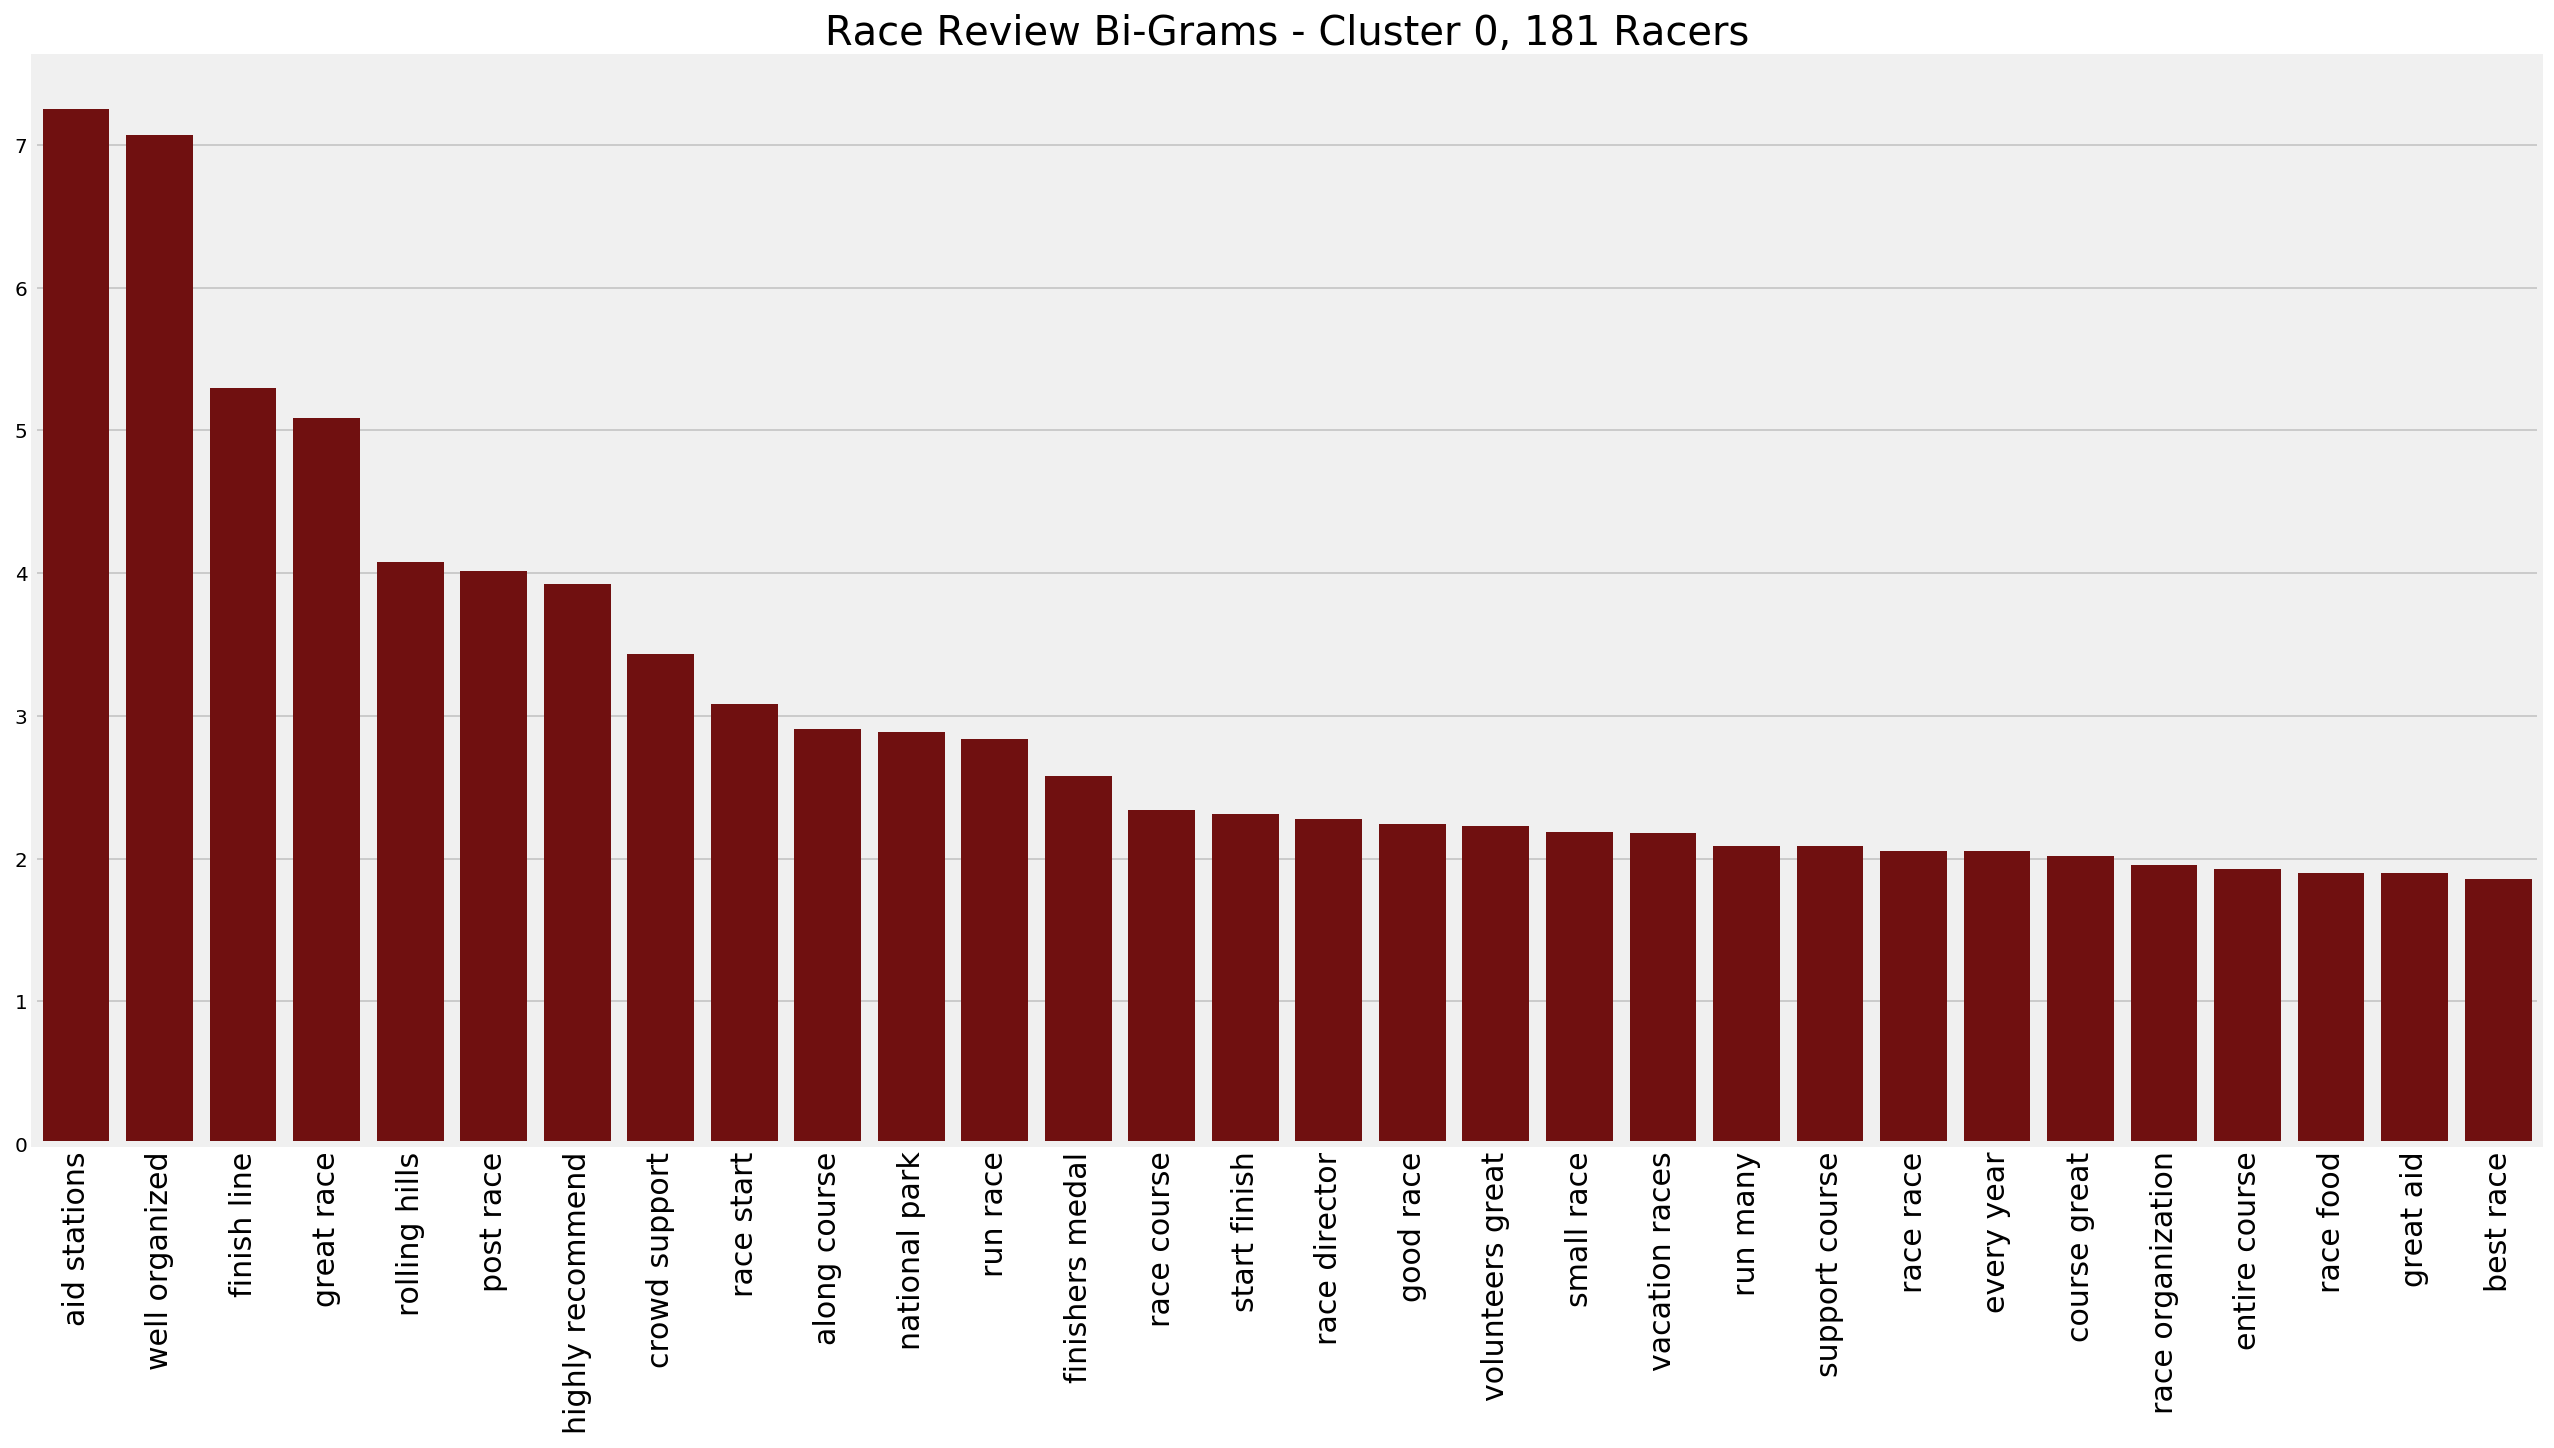

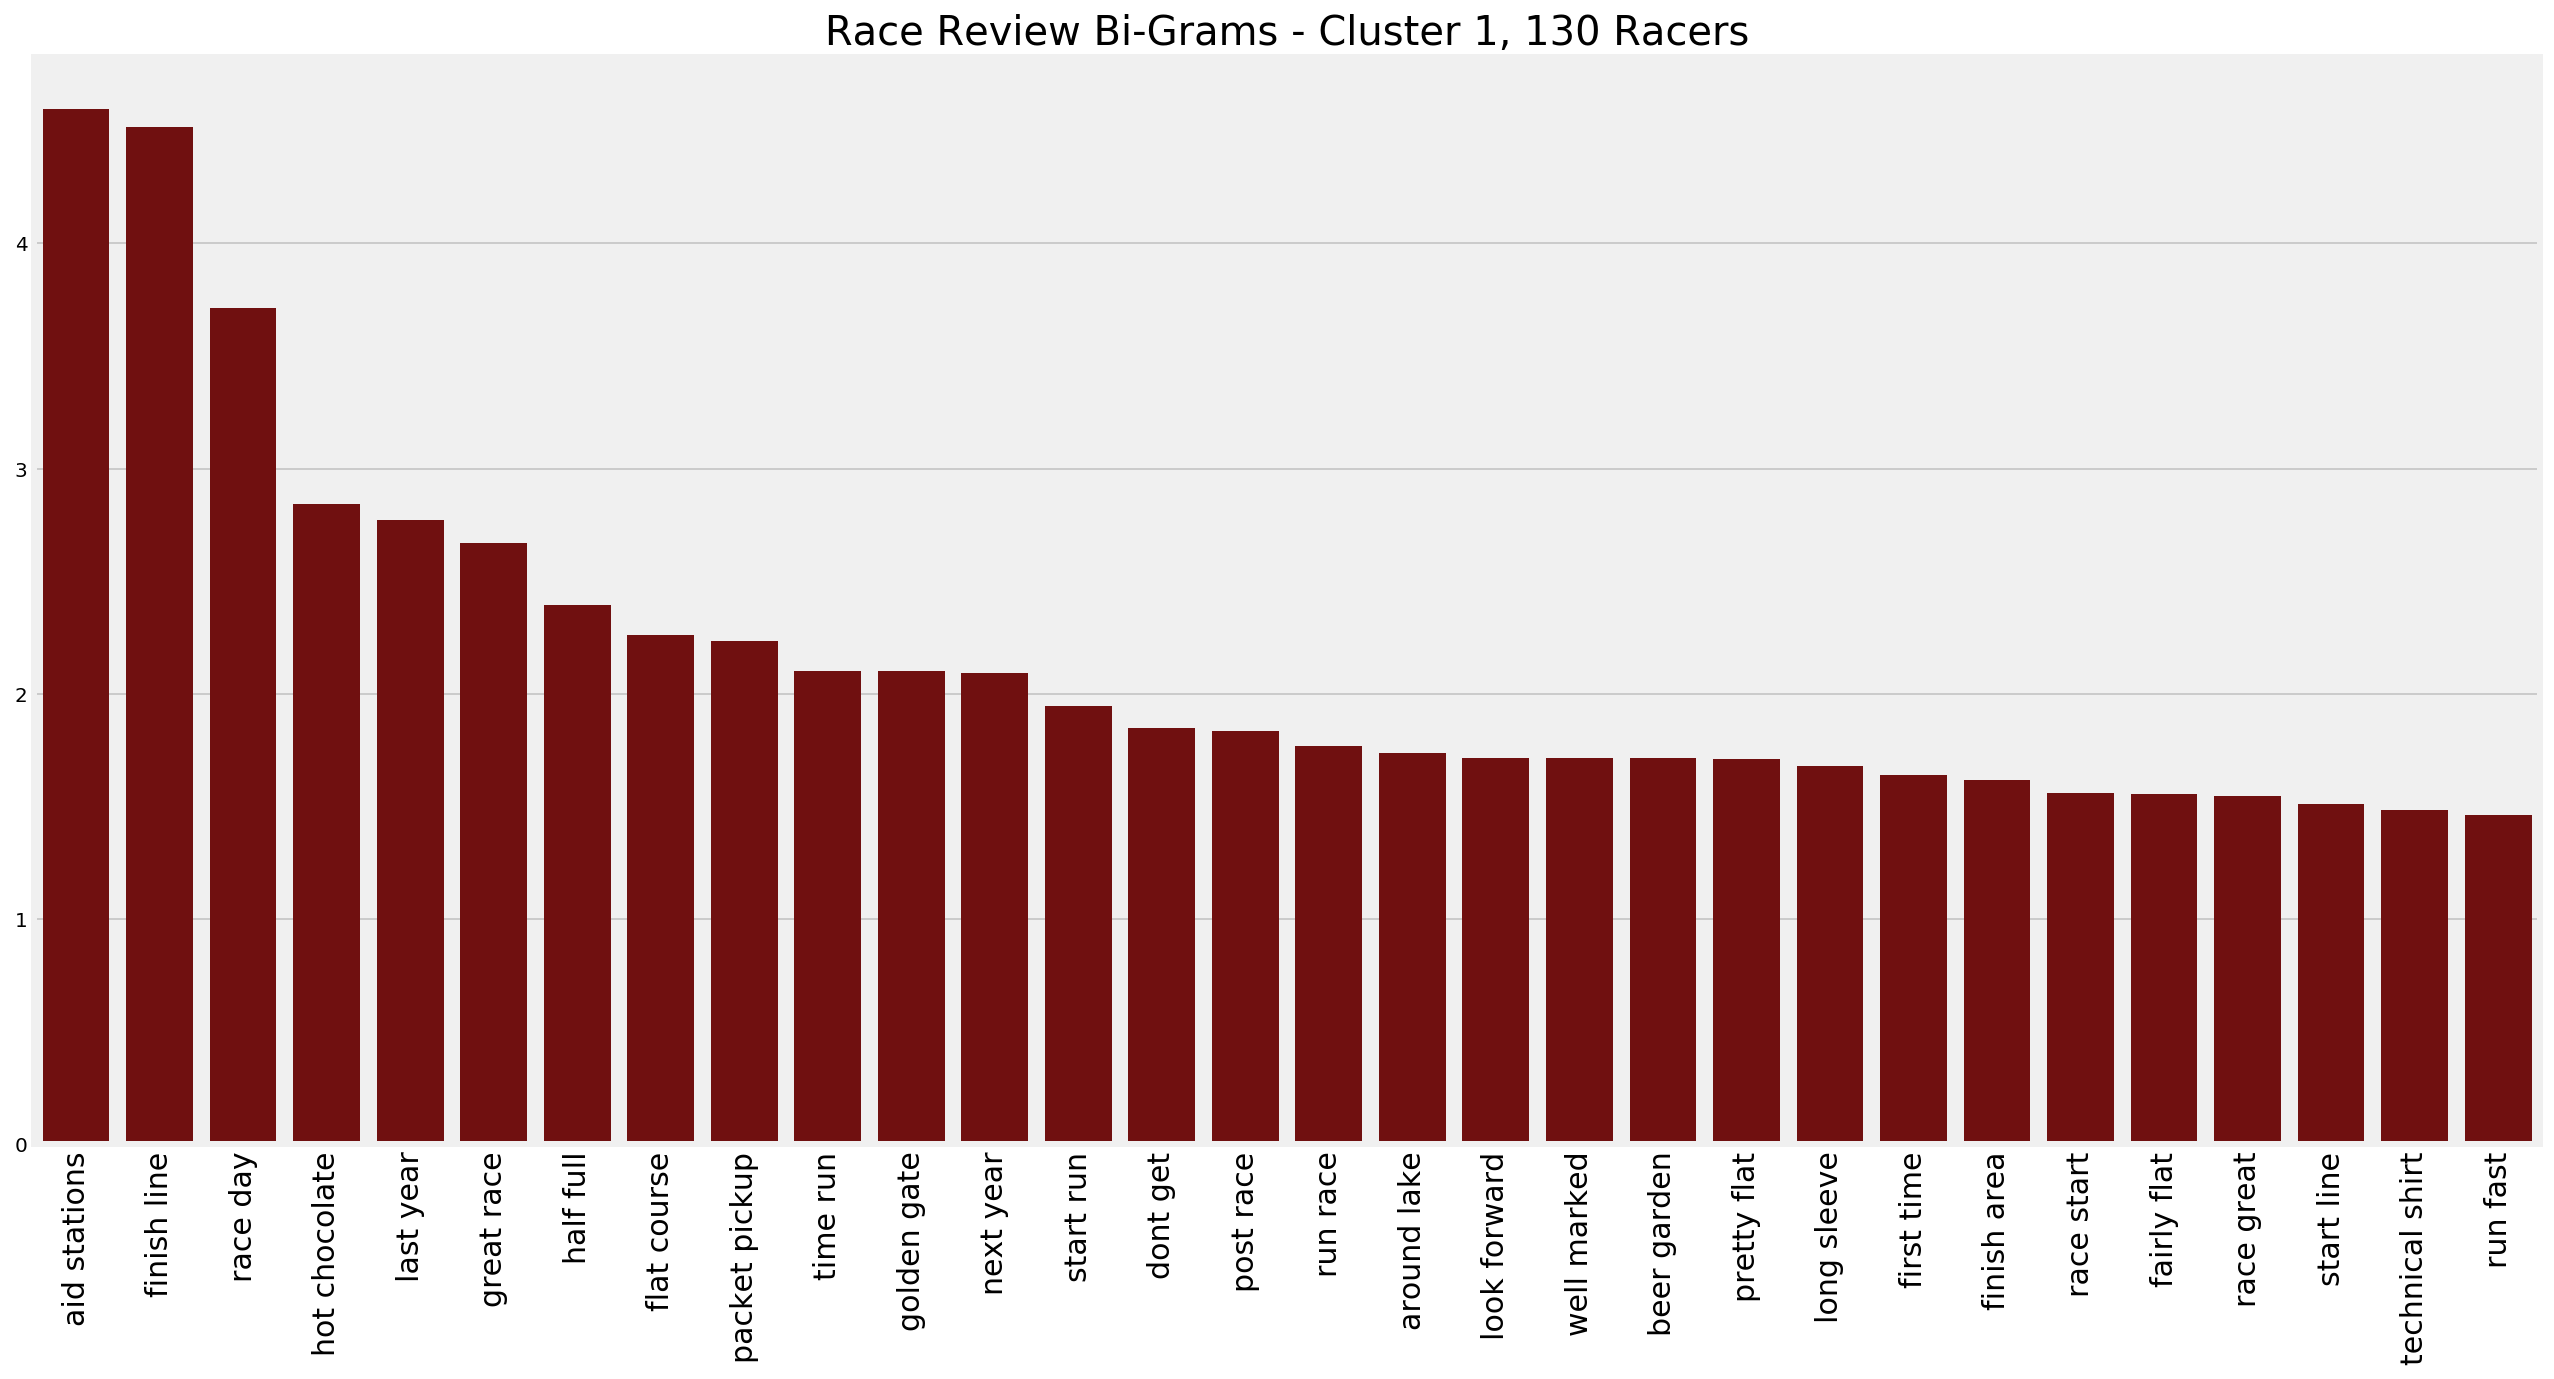

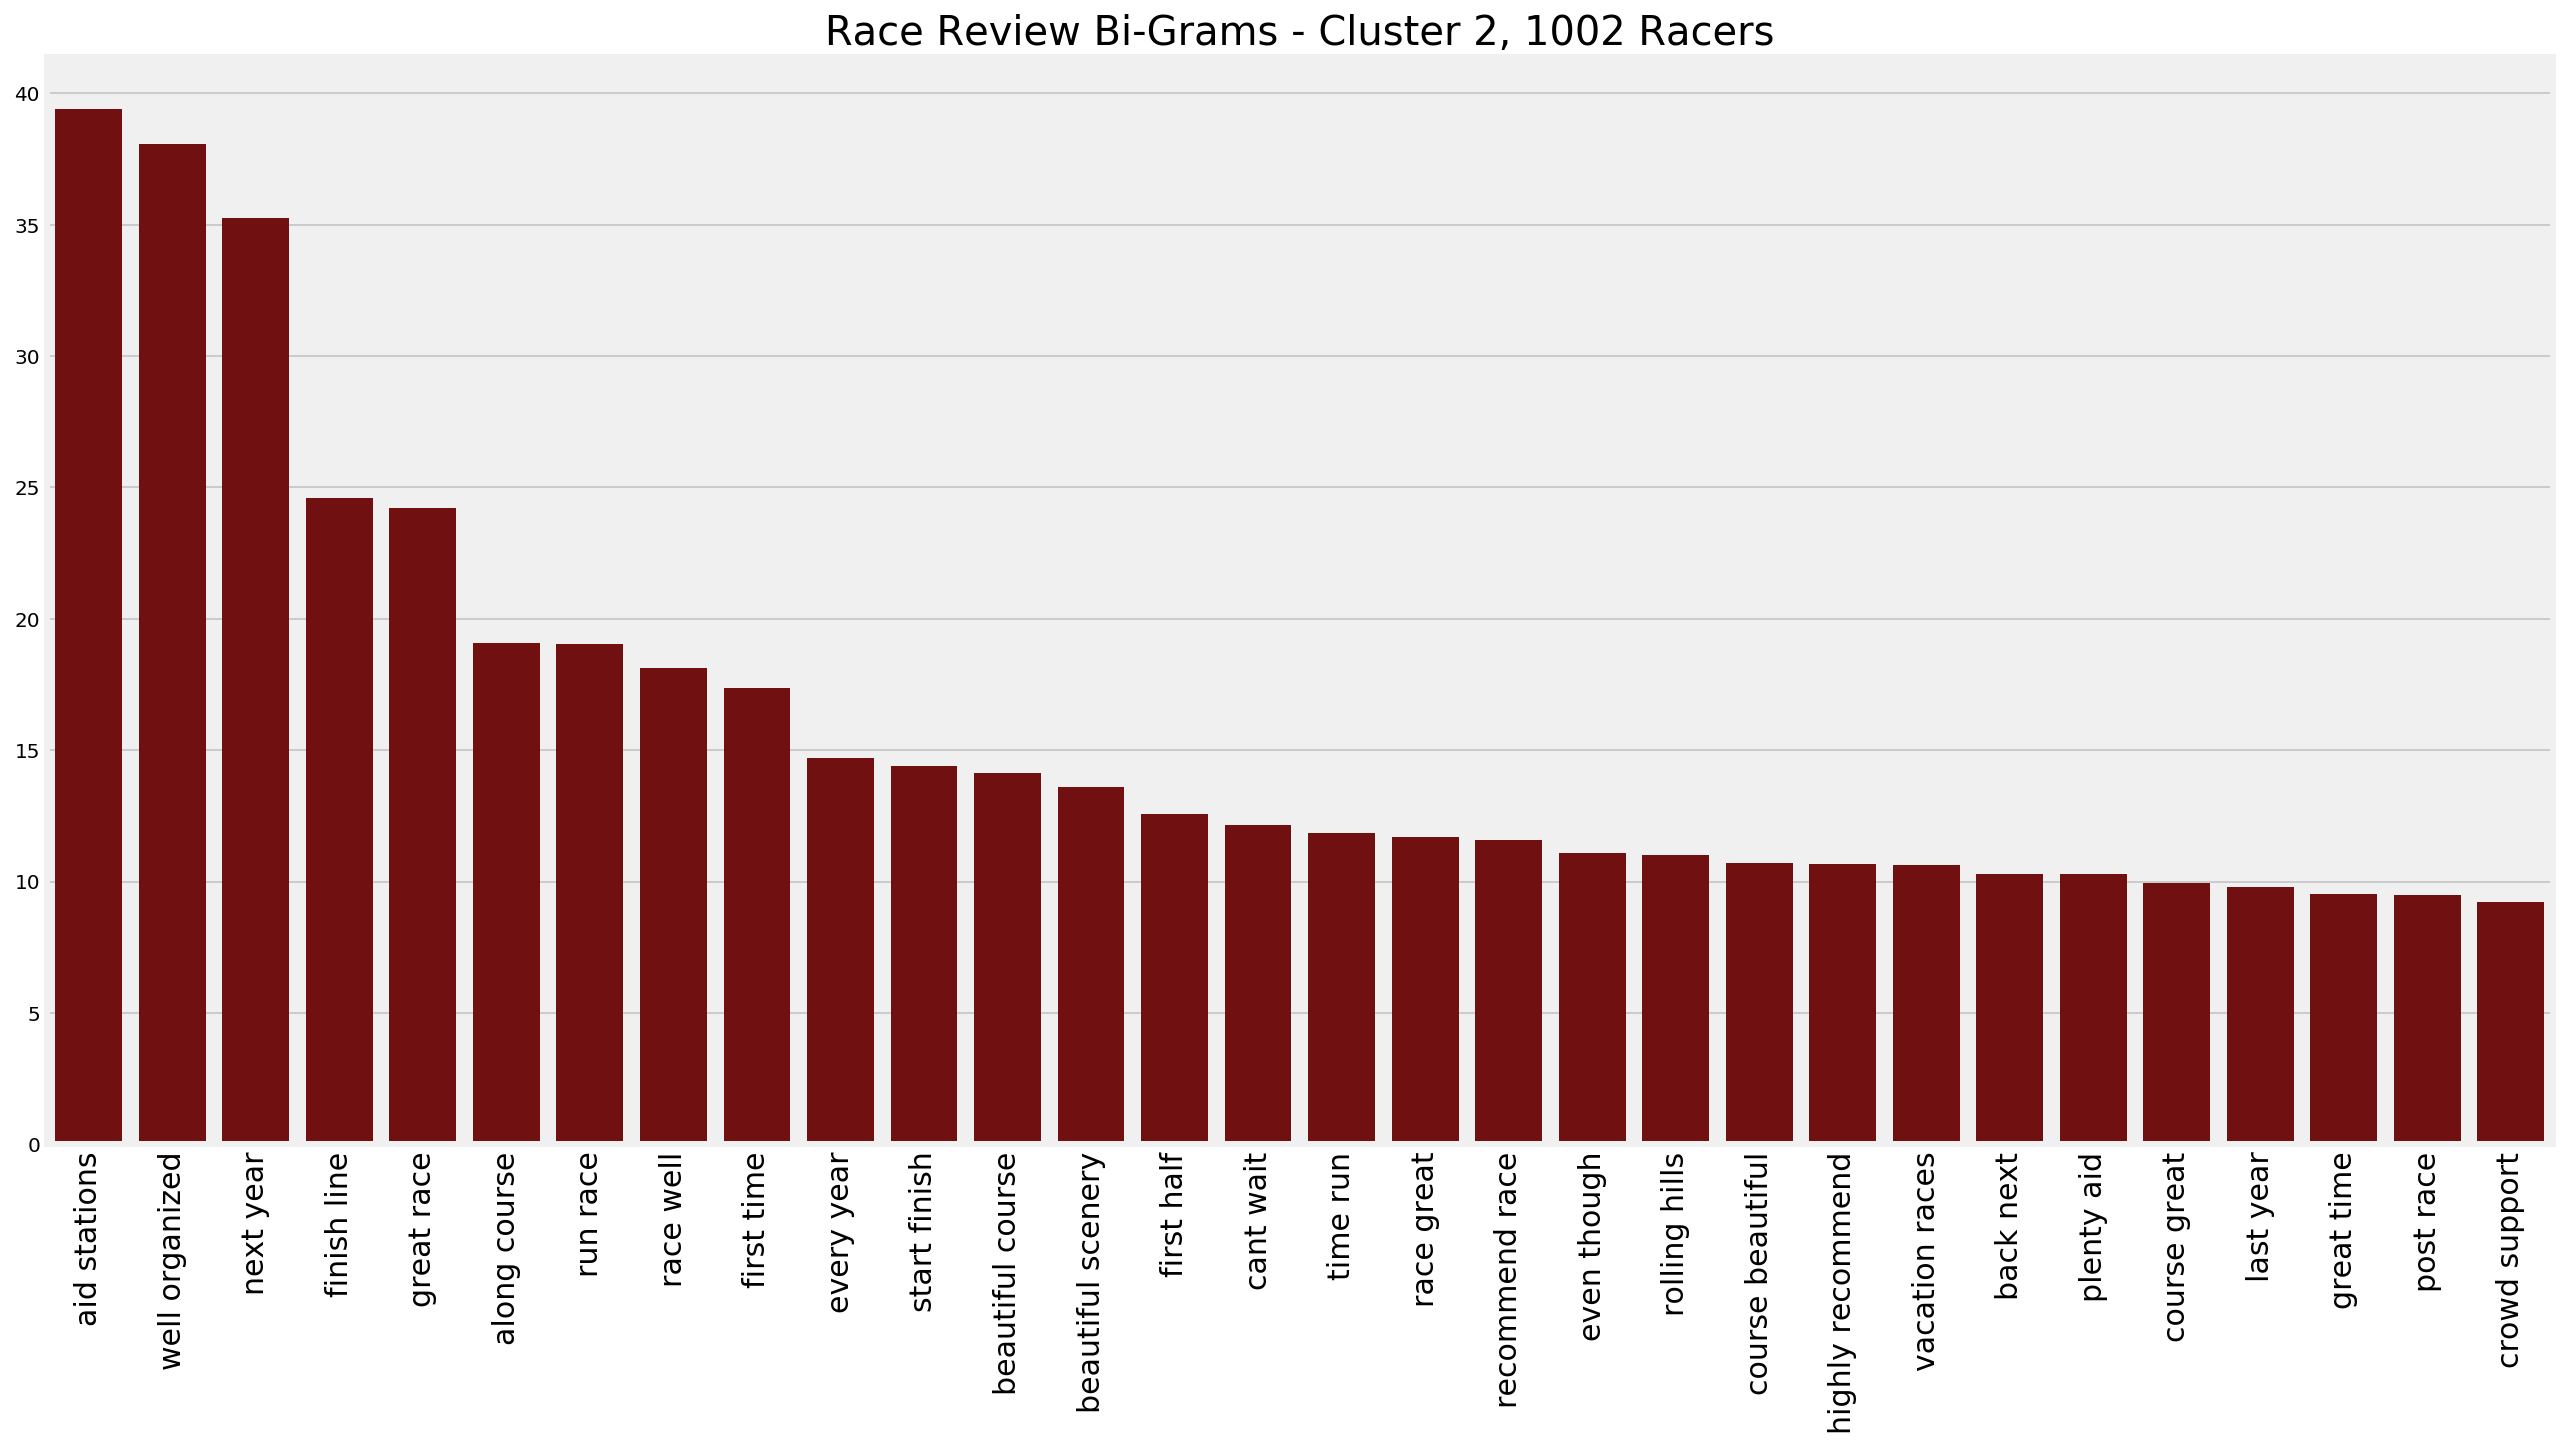

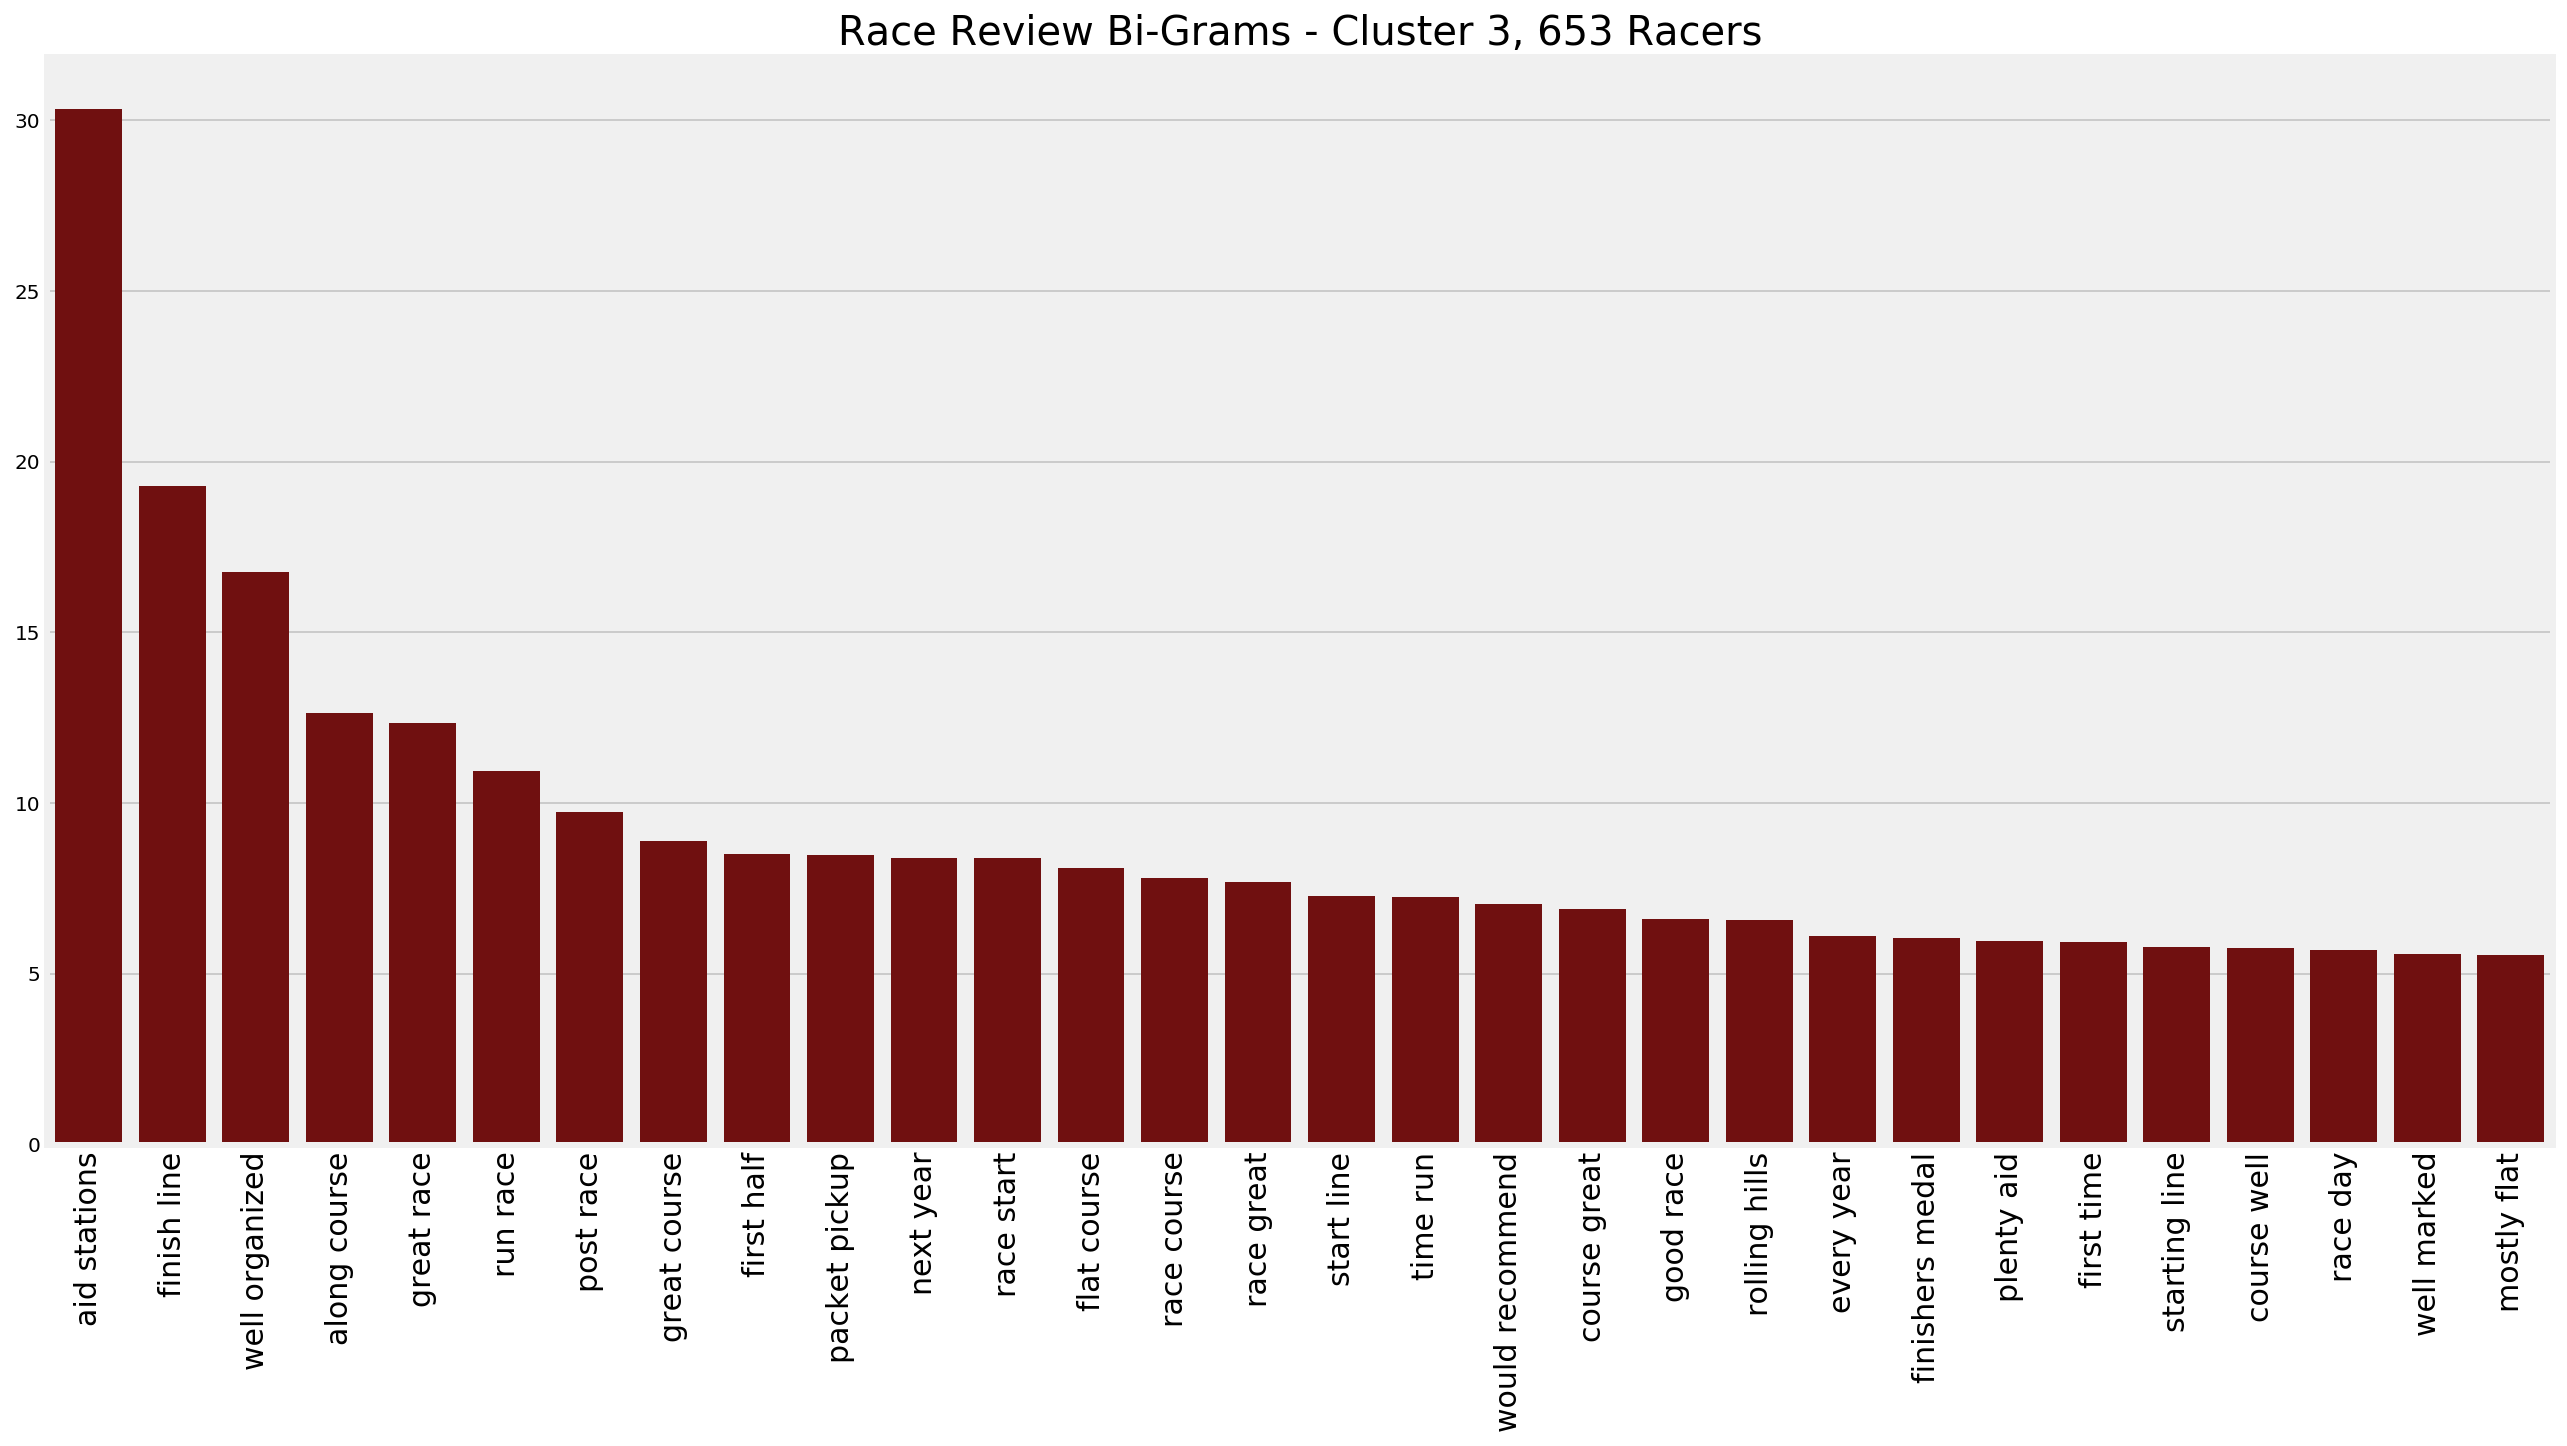

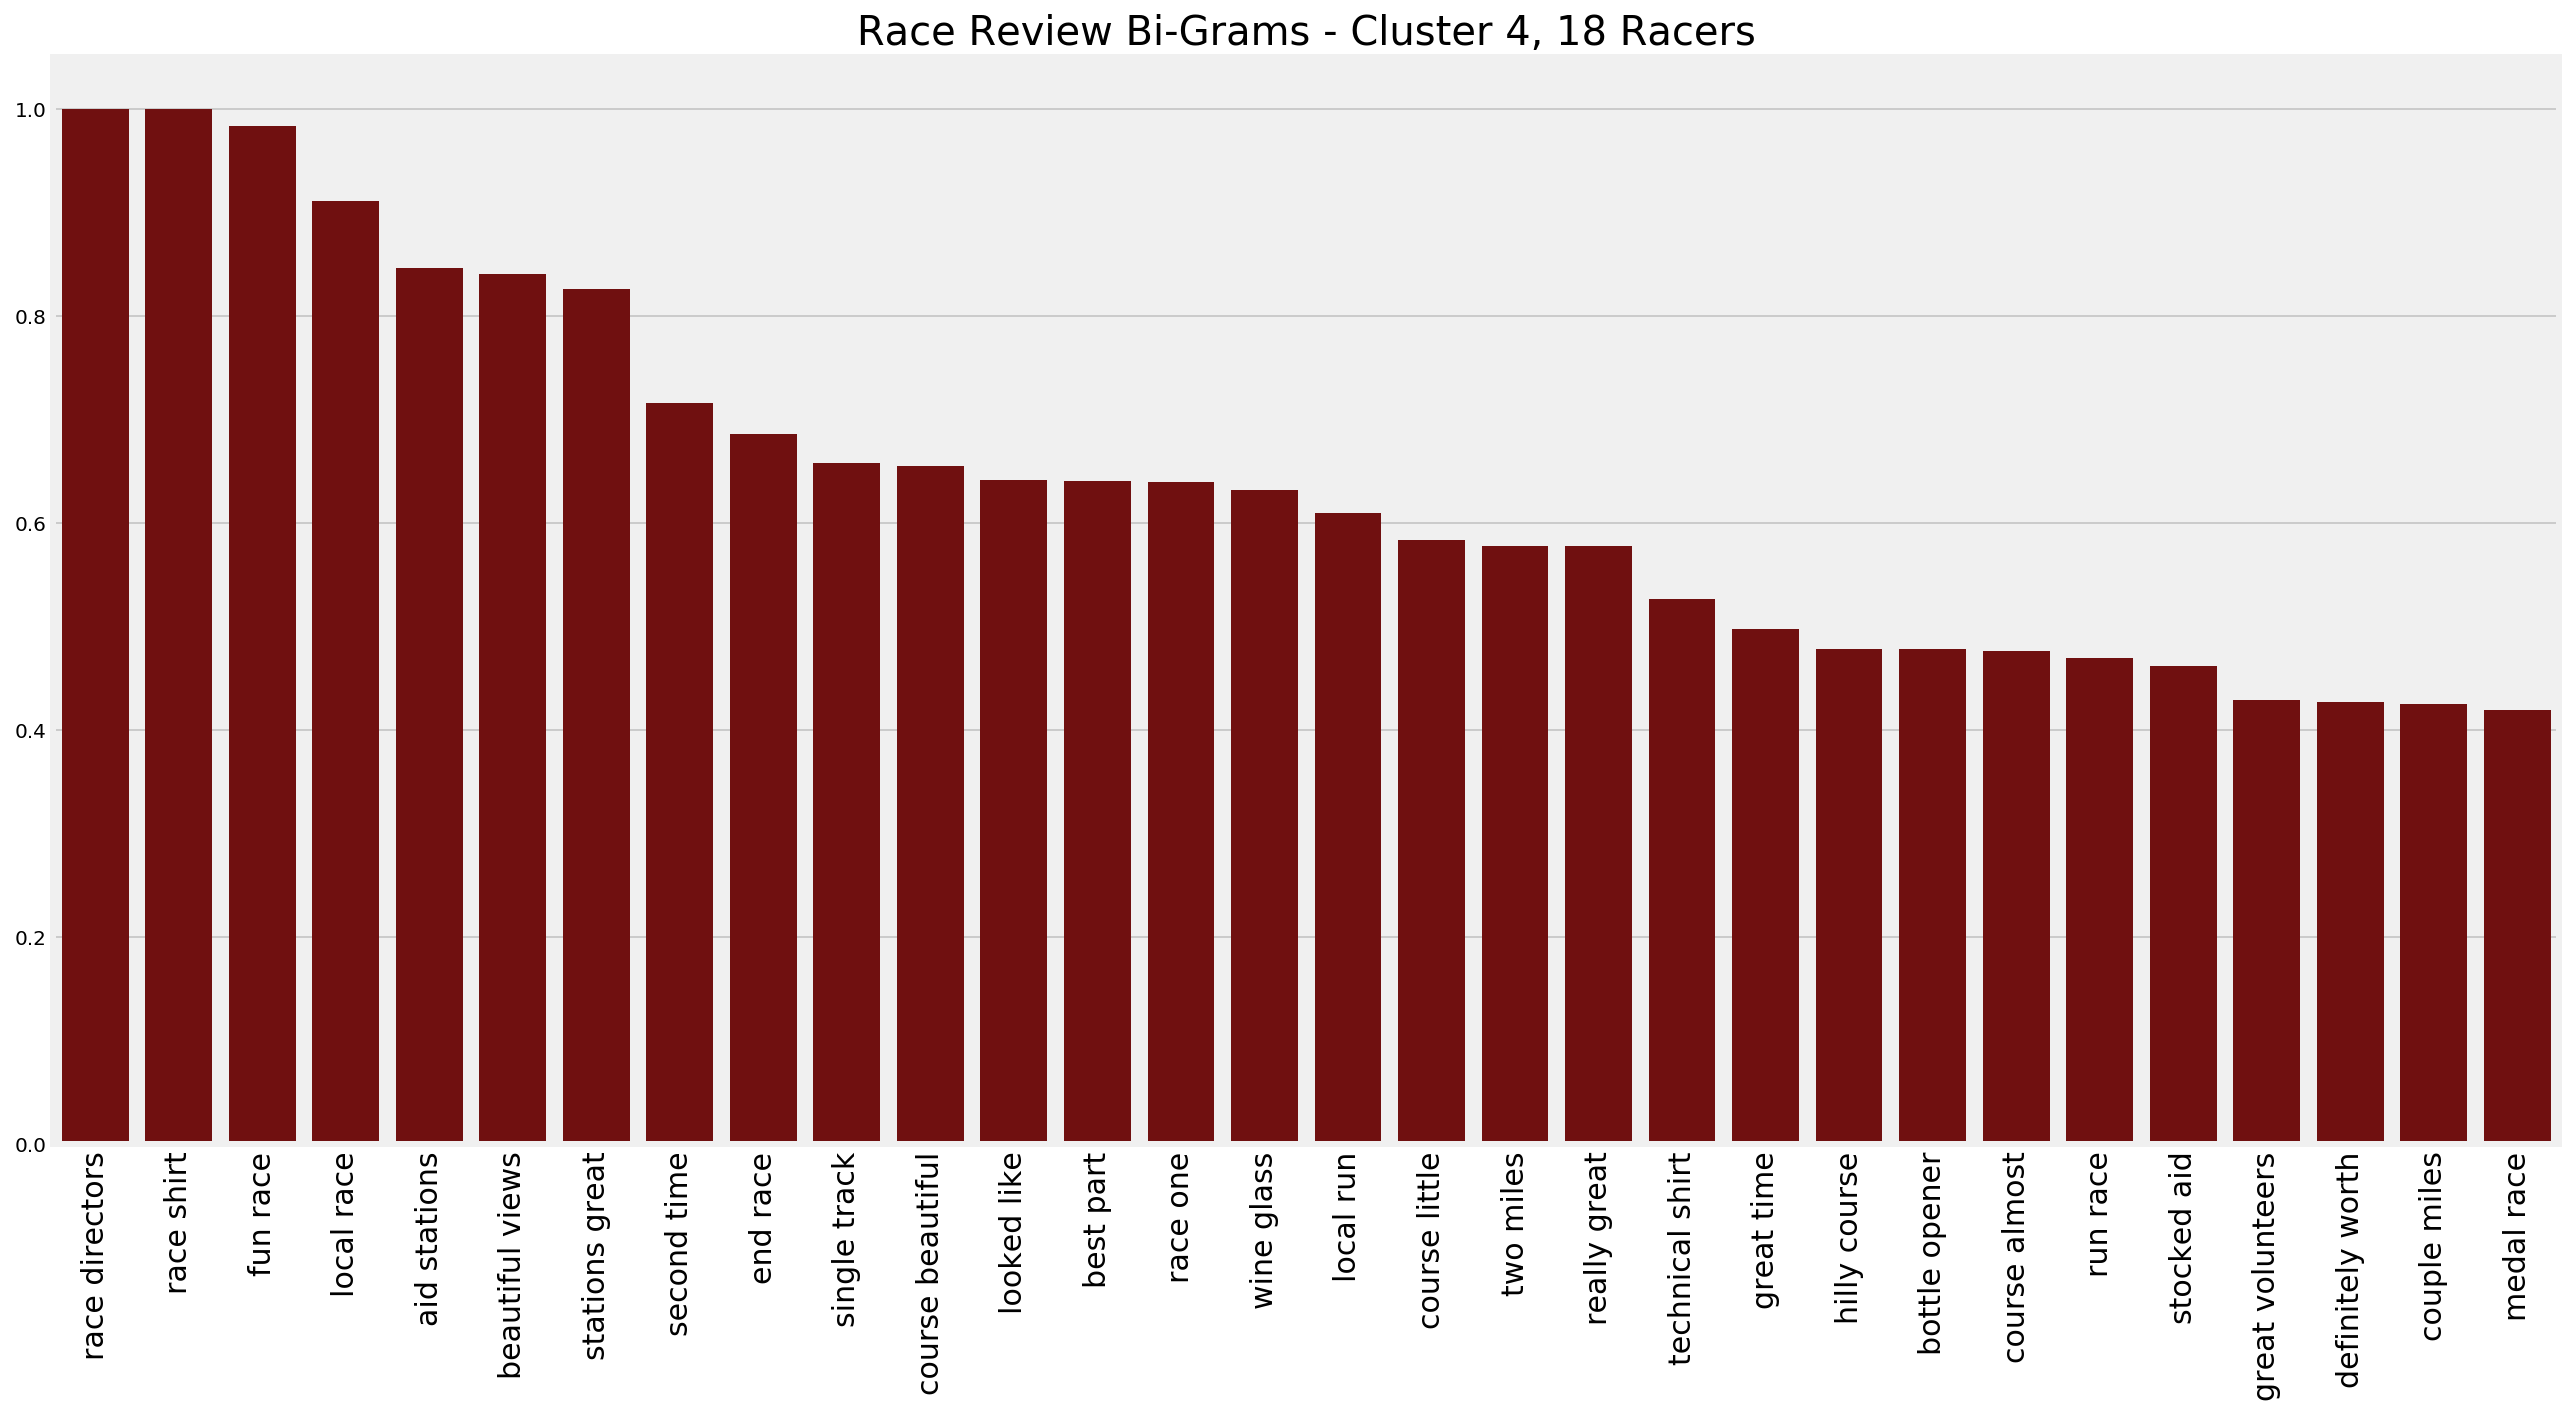

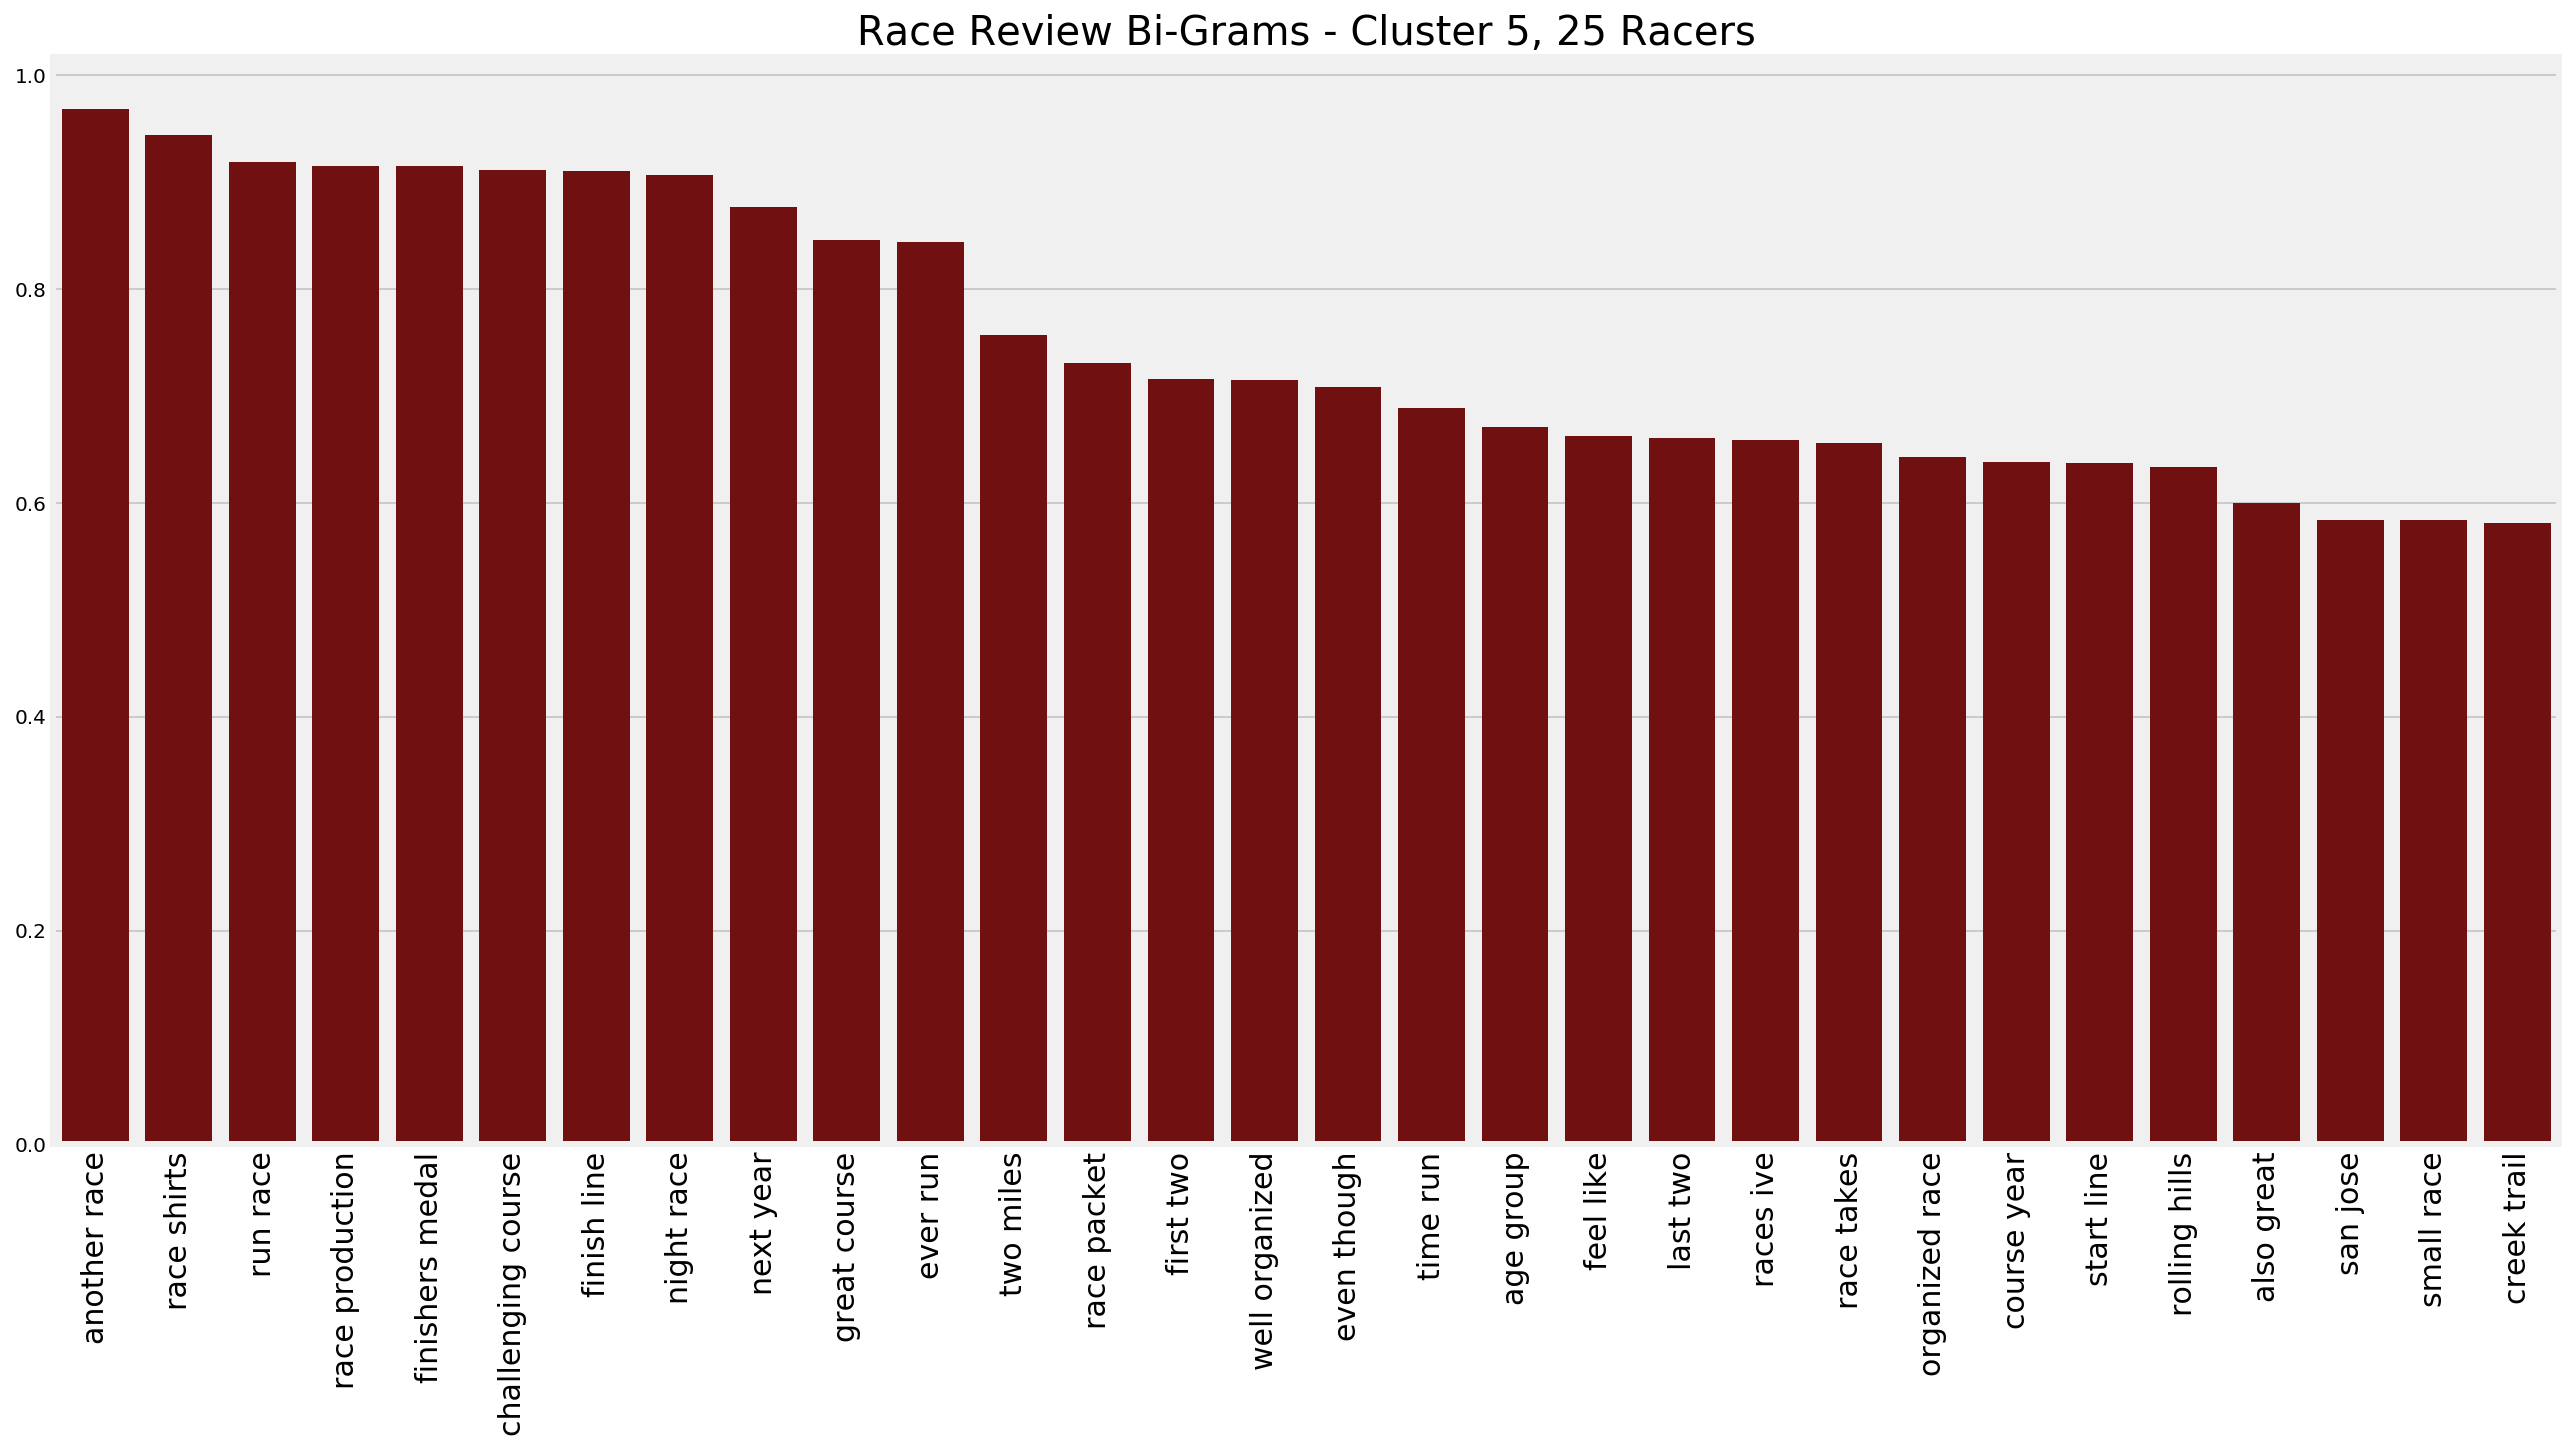

In [117]:
for cluster_num in range(len(set(kmeans.labels_))):
    cluster = cluster_vect[cluster_vect['kmean_clusters'] == cluster_num]
    num_racers = len(cluster)
    cluster = cluster.drop('kmean_clusters', axis=1)
    cluster_sum = cluster.sum(axis=0)
    cluster_top30 = cluster_sum.sort_values(ascending=False).head(30)
    plt.figure(figsize=(20, 10))
    bigram_plot = sns.barplot(cluster_top30.index, \
                              cluster_top30.values, color='maroon')
    bigram_plot.set_title("Race Review Bi-Grams - Cluster {}, {} Racers".format(cluster_num, num_racers), fontsize=20)
    bigram_plot.set_xticklabels(labels=cluster_top30.index, rotation=90, fontsize=15);

In [120]:
race_review_sorted = race_review_df.sort_values('race_name').reset_index(drop=True)
race_review_sorted.head()

date  diff_rating   distance  overall_rating  prod_rating  \
0  Jul 23, 2017          1.0       10K              5.0          5.0   
1  Jan 19, 2015          2.0        5K              3.0          3.0   
2  Aug 13, 2016          1.0       10K              4.0          5.0   
3  Nov 12, 2014          1.0       10K              4.0          5.0   
4  Apr 24, 2017          2.0  10 Miler              5.0          5.0   

                     race_name  scenery_rating  swag_rating  \
0    1/2 Way to Christmas Half             2.0          5.0   
1               10K on the Bay             2.0          1.0   
2               10K on the Bay             5.0          4.0   
3               10K on the Bay             3.0          3.0   
4  20 Mile Drop & 10 Mile Drop             4.0          5.0   

                                                text  \
0   I participated in the Beast challenge  doing ...   
1   I ran the 5K thats held the same morning as t...   
2   The Hayward 10k on the Bay and 5k is so sceni...   
3   1 Run is along East Bay Salt Marsh but not to...   
4   This race is well organized by Geoff and his ...   

                                    title               type      racer_id  \
0          Celebrating Christmas in July!    First-timer '17      cdefonso   
1  Small local race that benefits charity    First-timer '14         Jen_L   
2                Flat, Pretty, PR country    First-timer '15  SelfieRunner   
3          Pleasant 10K yields bird shirt    First-timer '14      Dastaffo   
4         This is a great down hill race.  Repeat Runner '17      biroruns   

  distance_trunc  year  high_overall  
0           10K   2017             1  
1            5K   2015             0  
2           10K   2016             0  
3           10K   2014             0  
4      10 Miler   2017             1

In [121]:
race_combined = {}
previous_race = ''
for i in range(len(race_review_sorted)):
    current_race = race_review_sorted.iloc[i]['race_name']
    distance = race_review_sorted.iloc[i]['distance_trunc']
    text = race_review_sorted.iloc[i]['text']
    if (current_race != previous_race):
        # add previous racer to dictionary
        if i > 0:
            race_combined[previous_race] = {'race_name': previous_race, 'distances': distances, \
                                            'num_distances': len(distances), 'all_reviews': all_texts}
        # reset variables for new racer
        previous_race = current_race
        distances = [distance]
        all_texts = text
        if i == len(race_review_sorted) - 1:
            race_combined[previous_race] = {'racer_id': previous_racer, 'distances': distances, \
                                            'num_distances': len(distances), 'all_reviews': all_texts}
    else:
        if distance not in distances:
            distances.append(distance)
        all_texts + ' ' + text
        
race_combined = pd.DataFrame.from_dict(race_combined, orient='index')
race_combined = race_combined.reset_index(drop=True)
race_combined.head()

race_name         distances  num_distances  \
0    1/2 Way to Christmas Half            [10K ]              1   
1               10K on the Bay       [5K , 10K ]              2   
2  20 Mile Drop & 10 Mile Drop       [10 Miler ]              1   
3            305 Half Marathon  [Half Marathon ]              1   
4             3M Half Marathon  [Half Marathon ]              1   

                                         all_reviews  
0   I participated in the Beast challenge  doing ...  
1   I ran the 5K thats held the same morning as t...  
2   This race is well organized by Geoff and his ...  
3   great course  amazing aid views  RUN FOR BEER...  
4   I loved this race If you are looking for a fl...

In [122]:
race_combined.shape

(2102, 4)

In [123]:
race_ratings_summary = race_review_df.groupby('race_name').mean()
race_ratings_summary = race_ratings_summary.reset_index()
race_combined = pd.merge(left=race_combined, right=race_ratings_summary, on='race_name')
race_combined.head()

race_name         distances  num_distances  \
0    1/2 Way to Christmas Half            [10K ]              1   
1               10K on the Bay       [5K , 10K ]              2   
2  20 Mile Drop & 10 Mile Drop       [10 Miler ]              1   
3            305 Half Marathon  [Half Marathon ]              1   
4             3M Half Marathon  [Half Marathon ]              1   

                                         all_reviews  diff_rating  \
0   I participated in the Beast challenge  doing ...     1.000000   
1   I ran the 5K thats held the same morning as t...     1.333333   
2   This race is well organized by Geoff and his ...     2.000000   
3   great course  amazing aid views  RUN FOR BEER...     1.000000   
4   I loved this race If you are looking for a fl...     1.500000   

   overall_rating  prod_rating  scenery_rating  swag_rating  high_overall  
0        5.000000     5.000000        2.000000     5.000000           1.0  
1        3.666667     4.333333        3.333333     2.666667           0.0  
2        5.000000     5.000000        4.000000     5.000000           1.0  
3        5.000000     5.000000        4.000000     2.000000           1.0  
4        4.500000     4.500000        3.500000     4.500000           0.5

In [124]:
distance_dummies = pd.get_dummies(pd.DataFrame(race_combined['distances'].tolist()).stack()).sum(level=0)
race_combined = pd.merge(left=race_combined, right=distance_dummies,
                         left_index=True, right_index=True, how='left')
race_combined = race_combined.drop('distances', axis=1)
race_combined = race_combined.fillna(0)
race_combined.head()

race_name  num_distances  \
0    1/2 Way to Christmas Half              1   
1               10K on the Bay              2   
2  20 Mile Drop & 10 Mile Drop              1   
3            305 Half Marathon              1   
4             3M Half Marathon              1   

                                         all_reviews  diff_rating  \
0   I participated in the Beast challenge  doing ...     1.000000   
1   I ran the 5K thats held the same morning as t...     1.333333   
2   This race is well organized by Geoff and his ...     2.000000   
3   great course  amazing aid views  RUN FOR BEER...     1.000000   
4   I loved this race If you are looking for a fl...     1.500000   

   overall_rating  prod_rating  scenery_rating  swag_rating  high_overall  \
0        5.000000     5.000000        2.000000     5.000000           1.0   
1        3.666667     4.333333        3.333333     2.666667           0.0   
2        5.000000     5.000000        4.000000     5.000000           1.0   
3        5.000000     5.000000        4.000000     2.000000           1.0   
4        4.500000     4.500000        3.500000     4.500000           0.5   

   10 Miler   ...    5 Miler   50 Miler   50K   5K   8K   Half Marathon   \
0          0  ...           0          0     0    0    0               0   
1          0  ...           0          0     0    1    0               0   
2          1  ...           0          0     0    0    0               0   
3          0  ...           0          0     0    0    0               1   
4          0  ...           0          0     0    0    0               1   

   Half Marathon Relay   Marathon   Marathon Relay   Other  
0                     0          0                0      0  
1                     0          0                0      0  
2                     0          0                0      0  
3                     0          0                0      0  
4                     0          0                0      0  

[5 rows x 25 columns]

In [125]:
X = review_vect.transform(race_combined['all_reviews'])
race_combined_vect = pd.DataFrame(X.toarray(), columns=review_vect_names)
race_topics = pd.DataFrame(lda.transform(race_combined_vect), columns=topic_columns)
race_topics.describe().T

count      mean       std       min       25%       50%       75%  \
Topic_0   2102.0  0.060084  0.116299  0.008102  0.017704  0.022303  0.032309   
Topic_1   2102.0  0.062555  0.121777  0.008102  0.017664  0.022297  0.029171   
Topic_2   2102.0  0.061588  0.118926  0.008588  0.017677  0.022295  0.032309   
Topic_3   2102.0  0.078570  0.144949  0.008588  0.018386  0.022446  0.033333   
Topic_4   2102.0  0.061464  0.119036  0.008588  0.017921  0.022309  0.033333   
Topic_5   2102.0  0.059064  0.114754  0.008102  0.017617  0.022271  0.028143   
Topic_6   2102.0  0.061238  0.115569  0.008102  0.017686  0.022275  0.028666   
Topic_7   2102.0  0.074374  0.140808  0.008102  0.018337  0.022391  0.033333   
Topic_8   2102.0  0.068006  0.132493  0.008102  0.018319  0.022321  0.033333   
Topic_9   2102.0  0.057719  0.107671  0.008588  0.017744  0.022295  0.028226   
Topic_10  2102.0  0.077963  0.143462  0.008102  0.018387  0.022488  0.033333   
Topic_11  2102.0  0.061795  0.122558  0.008102  0.017689  0.022267  0.028005   
Topic_12  2102.0  0.064821  0.123505  0.008102  0.018345  0.022355  0.033333   
Topic_13  2102.0  0.083949  0.152485  0.008102  0.018575  0.022597  0.033333   
Topic_14  2102.0  0.066811  0.128286  0.008700  0.017756  0.022303  0.033333   

               max  
Topic_0   0.764419  
Topic_1   0.765524  
Topic_2   0.753726  
Topic_3   0.864289  
Topic_4   0.755124  
Topic_5   0.789091  
Topic_6   0.741572  
Topic_7   0.771377  
Topic_8   0.797609  
Topic_9   0.752960  
Topic_10  0.794719  
Topic_11  0.788665  
Topic_12  0.772814  
Topic_13  0.805063  
Topic_14  0.815267

In [126]:
race_topics['Max_Topic'] = race_topics.idxmax(axis=1)
race_topics['Max_Topic'].value_counts()

Topic_13    203
Topic_0     199
Topic_3     188
Topic_10    172
Topic_7     162
Topic_14    136
Topic_8     135
Topic_12    127
Topic_11    120
Topic_6     116
Topic_1     114
Topic_2     112
Topic_4     111
Topic_5     108
Topic_9      99
Name: Max_Topic, dtype: int64

In [127]:
race_topics.groupby('Max_Topic')[topic_columns].mean()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5  \
Max_Topic                                                               
Topic_0    0.292095  0.050149  0.048735  0.052146  0.049935  0.050919   
Topic_1    0.035275  0.505380  0.034783  0.031956  0.036898  0.035296   
Topic_10   0.036569  0.029564  0.038609  0.048863  0.035576  0.026396   
Topic_11   0.046060  0.032171  0.034699  0.030657  0.042496  0.034164   
Topic_12   0.034657  0.035429  0.035706  0.042918  0.036104  0.038208   
Topic_13   0.029429  0.038681  0.034794  0.035622  0.033040  0.037932   
Topic_14   0.042965  0.029197  0.035236  0.035656  0.032418  0.036344   
Topic_2    0.034093  0.041848  0.497364  0.037967  0.034154  0.043092   
Topic_3    0.028652  0.033271  0.040519  0.491609  0.032851  0.026042   
Topic_4    0.036550  0.041713  0.031239  0.031056  0.499980  0.041217   
Topic_5    0.052279  0.034463  0.035161  0.031082  0.039392  0.489765   
Topic_6    0.035072  0.036204  0.036326  0.038370  0.035215  0.031673   
Topic_7    0.026012  0.035107  0.038163  0.031797  0.035032  0.033536   
Topic_8    0.036972  0.036814  0.031546  0.035101  0.033894  0.025489   
Topic_9    0.039704  0.045239  0.033916  0.037367  0.040846  0.041620   

            Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
Max_Topic                                                               
Topic_0    0.049051  0.052813  0.046481  0.054447  0.047262  0.051266   
Topic_1    0.031963  0.050698  0.032806  0.033081  0.038414  0.033996   
Topic_10   0.029768  0.032478  0.036330  0.033973  0.499032  0.034673   
Topic_11   0.028021  0.033272  0.037761  0.034965  0.039677  0.498228   
Topic_12   0.038990  0.032187  0.034897  0.033814  0.033462  0.034929   
Topic_13   0.033747  0.041305  0.038433  0.032477  0.041846  0.031333   
Topic_14   0.053443  0.036969  0.031381  0.033214  0.035714  0.027219   
Topic_2    0.031848  0.044804  0.036206  0.038213  0.035584  0.028930   
Topic_3    0.036575  0.031769  0.036146  0.040729  0.047069  0.039150   
Topic_4    0.044271  0.031576  0.036048  0.036064  0.041772  0.031174   
Topic_5    0.047304  0.035651  0.033751  0.034054  0.036336  0.029289   
Topic_6    0.469055  0.037171  0.036390  0.037710  0.038272  0.039963   
Topic_7    0.033947  0.509012  0.042867  0.041039  0.036667  0.035713   
Topic_8    0.031213  0.032300  0.512766  0.034651  0.045609  0.026642   
Topic_9    0.032057  0.035230  0.038301  0.464204  0.040065  0.043679   

           Topic_12  Topic_13  Topic_14  
Max_Topic                                
Topic_0    0.052185  0.052498  0.050017  
Topic_1    0.031110  0.033673  0.034672  
Topic_10   0.037565  0.039311  0.041293  
Topic_11   0.039282  0.041013  0.027533  
Topic_12   0.483432  0.052813  0.032455  
Topic_13   0.035267  0.498169  0.037924  
Topic_14   0.036897  0.038386  0.494961  
Topic_2    0.032498  0.033496  0.029903  
Topic_3    0.033870  0.040544  0.041205  
Topic_4    0.035657  0.030223  0.031459  
Topic_5    0.040668  0.031387  0.029418  
Topic_6    0.040047  0.035832  0.052700  
Topic_7    0.038503  0.036029  0.026576  
Topic_8    0.036626  0.040854  0.039520  
Topic_9    0.034236  0.038483  0.035053

In [128]:
ratings_plus_id = ratings + ['race_name']
race_ratings = race_combined[ratings_plus_id]
race_ratings = race_ratings.reset_index(drop=True)
race_max_topic = pd.concat([race_ratings, race_topics['Max_Topic']], axis=1)
race_max_topic.groupby('Max_Topic')[ratings].describe().T

Max_Topic                Topic_0     Topic_1    Topic_10    Topic_11  \
overall_rating count  199.000000  114.000000  172.000000  120.000000   
               mean     3.998681    4.174456    4.145908    4.064507   
               std      0.790350    0.792309    0.756192    0.774268   
               min      2.000000    1.000000    1.000000    1.000000   
               25%      3.645833    4.000000    4.000000    4.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      4.647619    5.000000    5.000000    4.717532   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  199.000000  114.000000  172.000000  120.000000   
               mean     2.885802    2.708409    2.842269    2.807496   
               std      1.153565    1.184292    1.232496    1.179741   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.000000    2.000000    2.000000    2.000000   
               50%      3.000000    2.875000    3.000000    3.000000   
               75%      4.000000    3.543750    4.000000    3.541667   
               max      5.000000    5.000000    5.000000    5.000000   
scenery_rating count  199.000000  114.000000  172.000000  120.000000   
               mean     3.667944    3.777834    3.825891    3.732875   
               std      1.034523    1.002784    1.051756    1.018542   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.000000    3.000000    3.000000    3.000000   
               50%      4.000000    4.000000    4.000000    3.923077   
               75%      4.500000    4.575000    5.000000    4.958333   
               max      5.000000    5.000000    5.000000    5.000000   
prod_rating    count  199.000000  114.000000  172.000000  120.000000   
               mean     3.978753    4.092849    4.184314    4.081042   
               std      0.913417    0.986674    0.852485    0.871648   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.500000    4.000000    4.000000    3.729167   
               50%      4.000000    4.287921    4.200000    4.000000   
               75%      4.756044    5.000000    5.000000    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
swag_rating    count  199.000000  114.000000  172.000000  120.000000   
               mean     3.584467    3.648241    3.631026    3.722219   
               std      1.040316    1.072063    0.974462    0.997077   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      3.000000    3.000000    3.000000    3.000000   
               50%      3.812500    4.000000    4.000000    4.000000   
               75%      4.414530    4.528846    4.350000    4.500000   
               max      5.000000    5.000000    5.000000    5.000000   

Max_Topic               Topic_12    Topic_13    Topic_14     Topic_2  \
overall_rating count  127.000000  203.000000  136.000000  112.000000   
               mean     4.091005    3.780678    4.012117    4.096478   
               std      0.751770    0.928547    0.754941    0.821649   
               min      2.000000    1.000000    1.200000    1.000000   
               25%      3.763889    3.000000    3.650000    4.000000   
               50%      4.000000    4.000000    4.000000    4.000000   
               75%      4.794444    4.500000    4.573913    5.000000   
               max      5.000000    5.000000    5.000000    5.000000   
diff_rating    count  127.000000  203.000000  136.000000  112.000000   
               mean     2.657407    2.662137    2.658544    2.640205   
               std      1.168006    1.098990    1.189064    1.100100   
               min      1.000000    1.000000    1.000000    1.000000   
               25%      2.000000    2.000000    2.000000    2.000000   
               50%      2.555556    3.0

In [129]:
race_topics.head()

Topic_0   Topic_1   Topic_2   Topic_3   Topic_4   Topic_5   Topic_6  \
0  0.016781  0.406477  0.016781  0.016781  0.016781  0.016781  0.145152   
1  0.016954  0.016954  0.129267  0.016954  0.016954  0.307178  0.016954   
2  0.022488  0.022488  0.022488  0.022488  0.022488  0.685167  0.022488   
3  0.027672  0.027672  0.027672  0.027672  0.027672  0.027672  0.027672   
4  0.018355  0.018355  0.018355  0.018355  0.018355  0.204386  0.018355   

    Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  Topic_12  Topic_13  \
0  0.246999  0.016781  0.016781  0.016781  0.016781  0.016781  0.016781   
1  0.016954  0.016954  0.016954  0.016954  0.016954  0.016954  0.360112   
2  0.022488  0.022488  0.022488  0.022488  0.022488  0.022488  0.022488   
3  0.027672  0.612595  0.027672  0.027672  0.027672  0.027672  0.027672   
4  0.018355  0.018355  0.018355  0.018355  0.018355  0.018355  0.018355   

   Topic_14 Max_Topic  
0  0.016781   Topic_1  
1  0.016954  Topic_13  
2  0.022488   Topic_5  
3  0.027672   Topic_8  
4  0.557003  Topic_14

In [130]:
race_with_topics = pd.concat([race_combined.drop('all_reviews', axis=1), \
                              race_topics[topic_columns]], axis=1)
race_with_topics.head()

race_name  num_distances  diff_rating  overall_rating  \
0    1/2 Way to Christmas Half              1     1.000000        5.000000   
1               10K on the Bay              2     1.333333        3.666667   
2  20 Mile Drop & 10 Mile Drop              1     2.000000        5.000000   
3            305 Half Marathon              1     1.000000        5.000000   
4             3M Half Marathon              1     1.500000        4.500000   

   prod_rating  scenery_rating  swag_rating  high_overall  10 Miler   10K   \
0     5.000000        2.000000     5.000000           1.0          0     1   
1     4.333333        3.333333     2.666667           0.0          0     1   
2     5.000000        4.000000     5.000000           1.0          1     0   
3     5.000000        4.000000     2.000000           1.0          0     0   
4     4.500000        3.500000     4.500000           0.5          0     0   

     ...      Topic_5   Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  \
0    ...     0.016781  0.145152  0.246999  0.016781  0.016781  0.016781   
1    ...     0.307178  0.016954  0.016954  0.016954  0.016954  0.016954   
2    ...     0.685167  0.022488  0.022488  0.022488  0.022488  0.022488   
3    ...     0.027672  0.027672  0.027672  0.612595  0.027672  0.027672   
4    ...     0.204386  0.018355  0.018355  0.018355  0.018355  0.018355   

   Topic_11  Topic_12  Topic_13  Topic_14  
0  0.016781  0.016781  0.016781  0.016781  
1  0.016954  0.016954  0.360112  0.016954  
2  0.022488  0.022488  0.022488  0.022488  
3  0.027672  0.027672  0.027672  0.027672  
4  0.018355  0.018355  0.018355  0.557003  

[5 rows x 39 columns]

In [131]:
sim_matrix = cosine_similarity(racer_with_topics.drop('racer_id', axis=1), racer_with_topics.drop('racer_id', axis=1))

In [132]:
print(sim_matrix.mean())
print(sim_matrix.std())

0.8455292589187026
0.14490794570854137


In [133]:
X = race_with_topics.drop('race_name', axis=1)

ss = StandardScaler()
X_scaled = ss.fit_transform(X)

In [134]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(X_scaled)
race_with_topics['kmean_clusters'] = kmeans.labels_
race_with_topics['kmean_clusters'].value_counts()

2    690
0    635
5    401
1    351
4     14
3     11
Name: kmean_clusters, dtype: int64

In [135]:
race_with_topics.groupby('kmean_clusters').mean().T

kmean_clusters               0         1         2         3         4  \
num_distances         1.176378  1.347578  1.044928  1.090909  2.785714   
diff_rating           3.231309  2.211580  2.724083  2.661616  3.186456   
overall_rating        4.790003  3.793060  3.487373  3.974747  4.240146   
prod_rating           4.723327  3.741218  3.538056  3.984848  4.087591   
scenery_rating        4.356516  3.213975  3.342458  3.045455  3.614210   
swag_rating           4.249308  3.309331  3.120191  3.444444  3.861376   
high_overall          0.800417  0.188274  0.030327  0.313131  0.505149   
10 Miler              0.034646  0.008547  0.034783  0.000000  0.000000   
10K                   0.151181  0.153846  0.155072  0.000000  0.214286   
12K                   0.007874  0.005698  0.000000  0.000000  0.000000   
15K                   0.028346  0.017094  0.023188  0.000000  0.000000   
25K                   0.014173  0.000000  0.011594  0.000000  0.000000   
4 Miler               0.017323  0.000000  0.011594  0.000000  0.000000   
5 Miler               0.003150  0.000000  0.004348  0.000000  0.000000   
50 Miler              0.026772  0.000000  0.005797  0.000000  0.071429   
50K                   0.067717  0.000000  0.059420  0.000000  0.000000   
5K                    0.103937  0.997151  0.000000  0.090909  0.357143   
8K                    0.000000  0.000000  0.000000  1.000000  0.000000   
Half Marathon         0.428346  0.139601  0.615942  0.000000  0.428571   
Half Marathon Relay   0.012598  0.002849  0.001449  0.000000  0.000000   
Marathon              0.037795  0.002849  0.015942  0.000000  0.714286   
Marathon Relay        0.000000  0.000000  0.000000  0.000000  1.000000   
Other                 0.242520  0.019943  0.105797  0.000000  0.000000   
Topic_0               0.058819  0.059235  0.066233  0.035084  0.034320   
Topic_1               0.064463  0.049356  0.061083  0.023650  0.045908   
Topic_2               0.065702  0.063390  0.063894  0.070977  0.052157   
Topic_3               0.085173  0.069448  0.080493  0.040519  0.067801   
Topic_4               0.064200  0.064542  0.054397  0.118399  0.067570   
Topic_5               0.057542  0.060058  0.058152  0.149654  0.025962   
Topic_6               0.066266  0.071616  0.055120  0.040612  0.071418   
Topic_7               0.094691  0.077761  0.061631  0.159518  0.065271   
Topic_8               0.058372  0.060613  0.080110  0.060114  0.091793   
Topic_9               0.059646  0.049991  0.061061  0.023650  0.050525   
Topic_10              0.087640  0.069987  0.070348  0.080519  0.083034   
Topic_11              0.062214  0.055654  0.067396  0.023650  0.035092   
Topic_12              0.061762  0.056073  0.065001  0.023650  0.119654   
Topic_13              0.056609  0.105604  0.093899  0.085681  0.071810   
Topic_14              0.056903  0.086672  0.061182  0.064319  0.117686   

kmean_clusters               5  
num_distances         1.561097  
diff_rating           2.876722  
overall_rating        4.018066  
prod_rating           4.069554  
scenery_rating        3.852924  
swag_rating           3.525556  
high_overall          0.299915  
10 Miler              0.007481  
10K                   0.044888  
12K                   0.000000  
15K                   0.000000  
25K                   0.000000  
4 Miler               0.000000  
5 Miler               0.059850  
50 Miler              0.000000  
50K                   0.009975  
5K                    0.049875  
8K                    0.000000  
Half Marathon         0.408978  
Half Marathon Relay   0.004988  
Marathon              0.945137  
Marathon Relay        0.000000  
Other                 0.029925  
Topic_0               0.053836  
Topic_1               0.075268  
Topic_2               0.049600  
Topic_3               0.074208  
Topic_4               0.064820  
Topic_5               0.060843  
Topic_6               0.054926  
Topic_7               0.059147  
Topic_8               0.068293  
Topic_9               0.

In [136]:
print(race_combined_vect.shape)
race_combined_vect.head()

(2102, 768)


able run  age group  ahead time  aid aid  aid bottle  aid bottles  \
0       0.0        0.0         0.0      0.0         0.0          0.0   
1       0.0        0.0         0.0      0.0         0.0          0.0   
2       0.0        0.0         0.0      0.0         0.0          0.0   
3       0.0        0.0         0.0      0.0         0.0          0.0   
4       0.0        0.0         0.0      0.0         0.0          0.0   

   aid gatorade  aid sports  aid stations  aid stop    ...      year course  \
0           0.0         0.0           0.0       0.0    ...              0.0   
1           0.0         0.0           0.0       0.0    ...              0.0   
2           0.0         0.0           0.0       0.0    ...              0.0   
3           0.0         0.0           0.0       0.0    ...              0.0   
4           0.0         0.0           0.0       0.0    ...              0.0   

   year race  year ran  year run  year since  year year  years ago  \
0        0.0       0.0       0.0         0.0        0.0        0.0   
1        0.0       0.0       0.0         0.0        0.0        0.0   
2        0.0       0.0       0.0         0.0        0.0        0.0   
3        0.0       0.0       0.0         0.0        0.0        0.0   
4        0.0       0.0       0.0         0.0        0.0        0.0   

   years race  youre looking  youre run  
0         0.0            0.0        0.0  
1         0.0            0.0        0.0  
2         0.0            0.0        0.0  
3         0.0            0.0        0.0  
4         0.0            0.0        0.0  

[5 rows x 768 columns]

In [137]:
print(race_with_topics.shape)
race_with_topics.head()

(2102, 40)


race_name  num_distances  diff_rating  overall_rating  \
0    1/2 Way to Christmas Half              1     1.000000        5.000000   
1               10K on the Bay              2     1.333333        3.666667   
2  20 Mile Drop & 10 Mile Drop              1     2.000000        5.000000   
3            305 Half Marathon              1     1.000000        5.000000   
4             3M Half Marathon              1     1.500000        4.500000   

   prod_rating  scenery_rating  swag_rating  high_overall  10 Miler   10K   \
0     5.000000        2.000000     5.000000           1.0          0     1   
1     4.333333        3.333333     2.666667           0.0          0     1   
2     5.000000        4.000000     5.000000           1.0          1     0   
3     5.000000        4.000000     2.000000           1.0          0     0   
4     4.500000        3.500000     4.500000           0.5          0     0   

        ...         Topic_6   Topic_7   Topic_8   Topic_9  Topic_10  Topic_11  \
0       ...        0.145152  0.246999  0.016781  0.016781  0.016781  0.016781   
1       ...        0.016954  0.016954  0.016954  0.016954  0.016954  0.016954   
2       ...        0.022488  0.022488  0.022488  0.022488  0.022488  0.022488   
3       ...        0.027672  0.027672  0.612595  0.027672  0.027672  0.027672   
4       ...        0.018355  0.018355  0.018355  0.018355  0.018355  0.018355   

   Topic_12  Topic_13  Topic_14  kmean_clusters  
0  0.016781  0.016781  0.016781               0  
1  0.016954  0.360112  0.016954               1  
2  0.022488  0.022488  0.022488               0  
3  0.027672  0.027672  0.027672               0  
4  0.018355  0.018355  0.557003               0  

[5 rows x 40 columns]

In [138]:
race_cluster_vect = pd.concat([race_with_topics['kmean_clusters'], race_combined_vect], axis=1)
race_cluster_vect.head()

kmean_clusters  able run  age group  ahead time  aid aid  aid bottle  \
0               0       0.0        0.0         0.0      0.0         0.0   
1               1       0.0        0.0         0.0      0.0         0.0   
2               0       0.0        0.0         0.0      0.0         0.0   
3               0       0.0        0.0         0.0      0.0         0.0   
4               0       0.0        0.0         0.0      0.0         0.0   

   aid bottles  aid gatorade  aid sports  aid stations    ...      \
0          0.0           0.0         0.0           0.0    ...       
1          0.0           0.0         0.0           0.0    ...       
2          0.0           0.0         0.0           0.0    ...       
3          0.0           0.0         0.0           0.0    ...       
4          0.0           0.0         0.0           0.0    ...       

   year course  year race  year ran  year run  year since  year year  \
0          0.0        0.0       0.0       0.0         0.0        0.0   
1          0.0        0.0       0.0       0.0         0.0        0.0   
2          0.0        0.0       0.0       0.0         0.0        0.0   
3          0.0        0.0       0.0       0.0         0.0        0.0   
4          0.0        0.0       0.0       0.0         0.0        0.0   

   years ago  years race  youre looking  youre run  
0        0.0         0.0            0.0        0.0  
1        0.0         0.0            0.0        0.0  
2        0.0         0.0            0.0        0.0  
3        0.0         0.0            0.0        0.0  
4        0.0         0.0            0.0        0.0  

[5 rows x 769 columns]

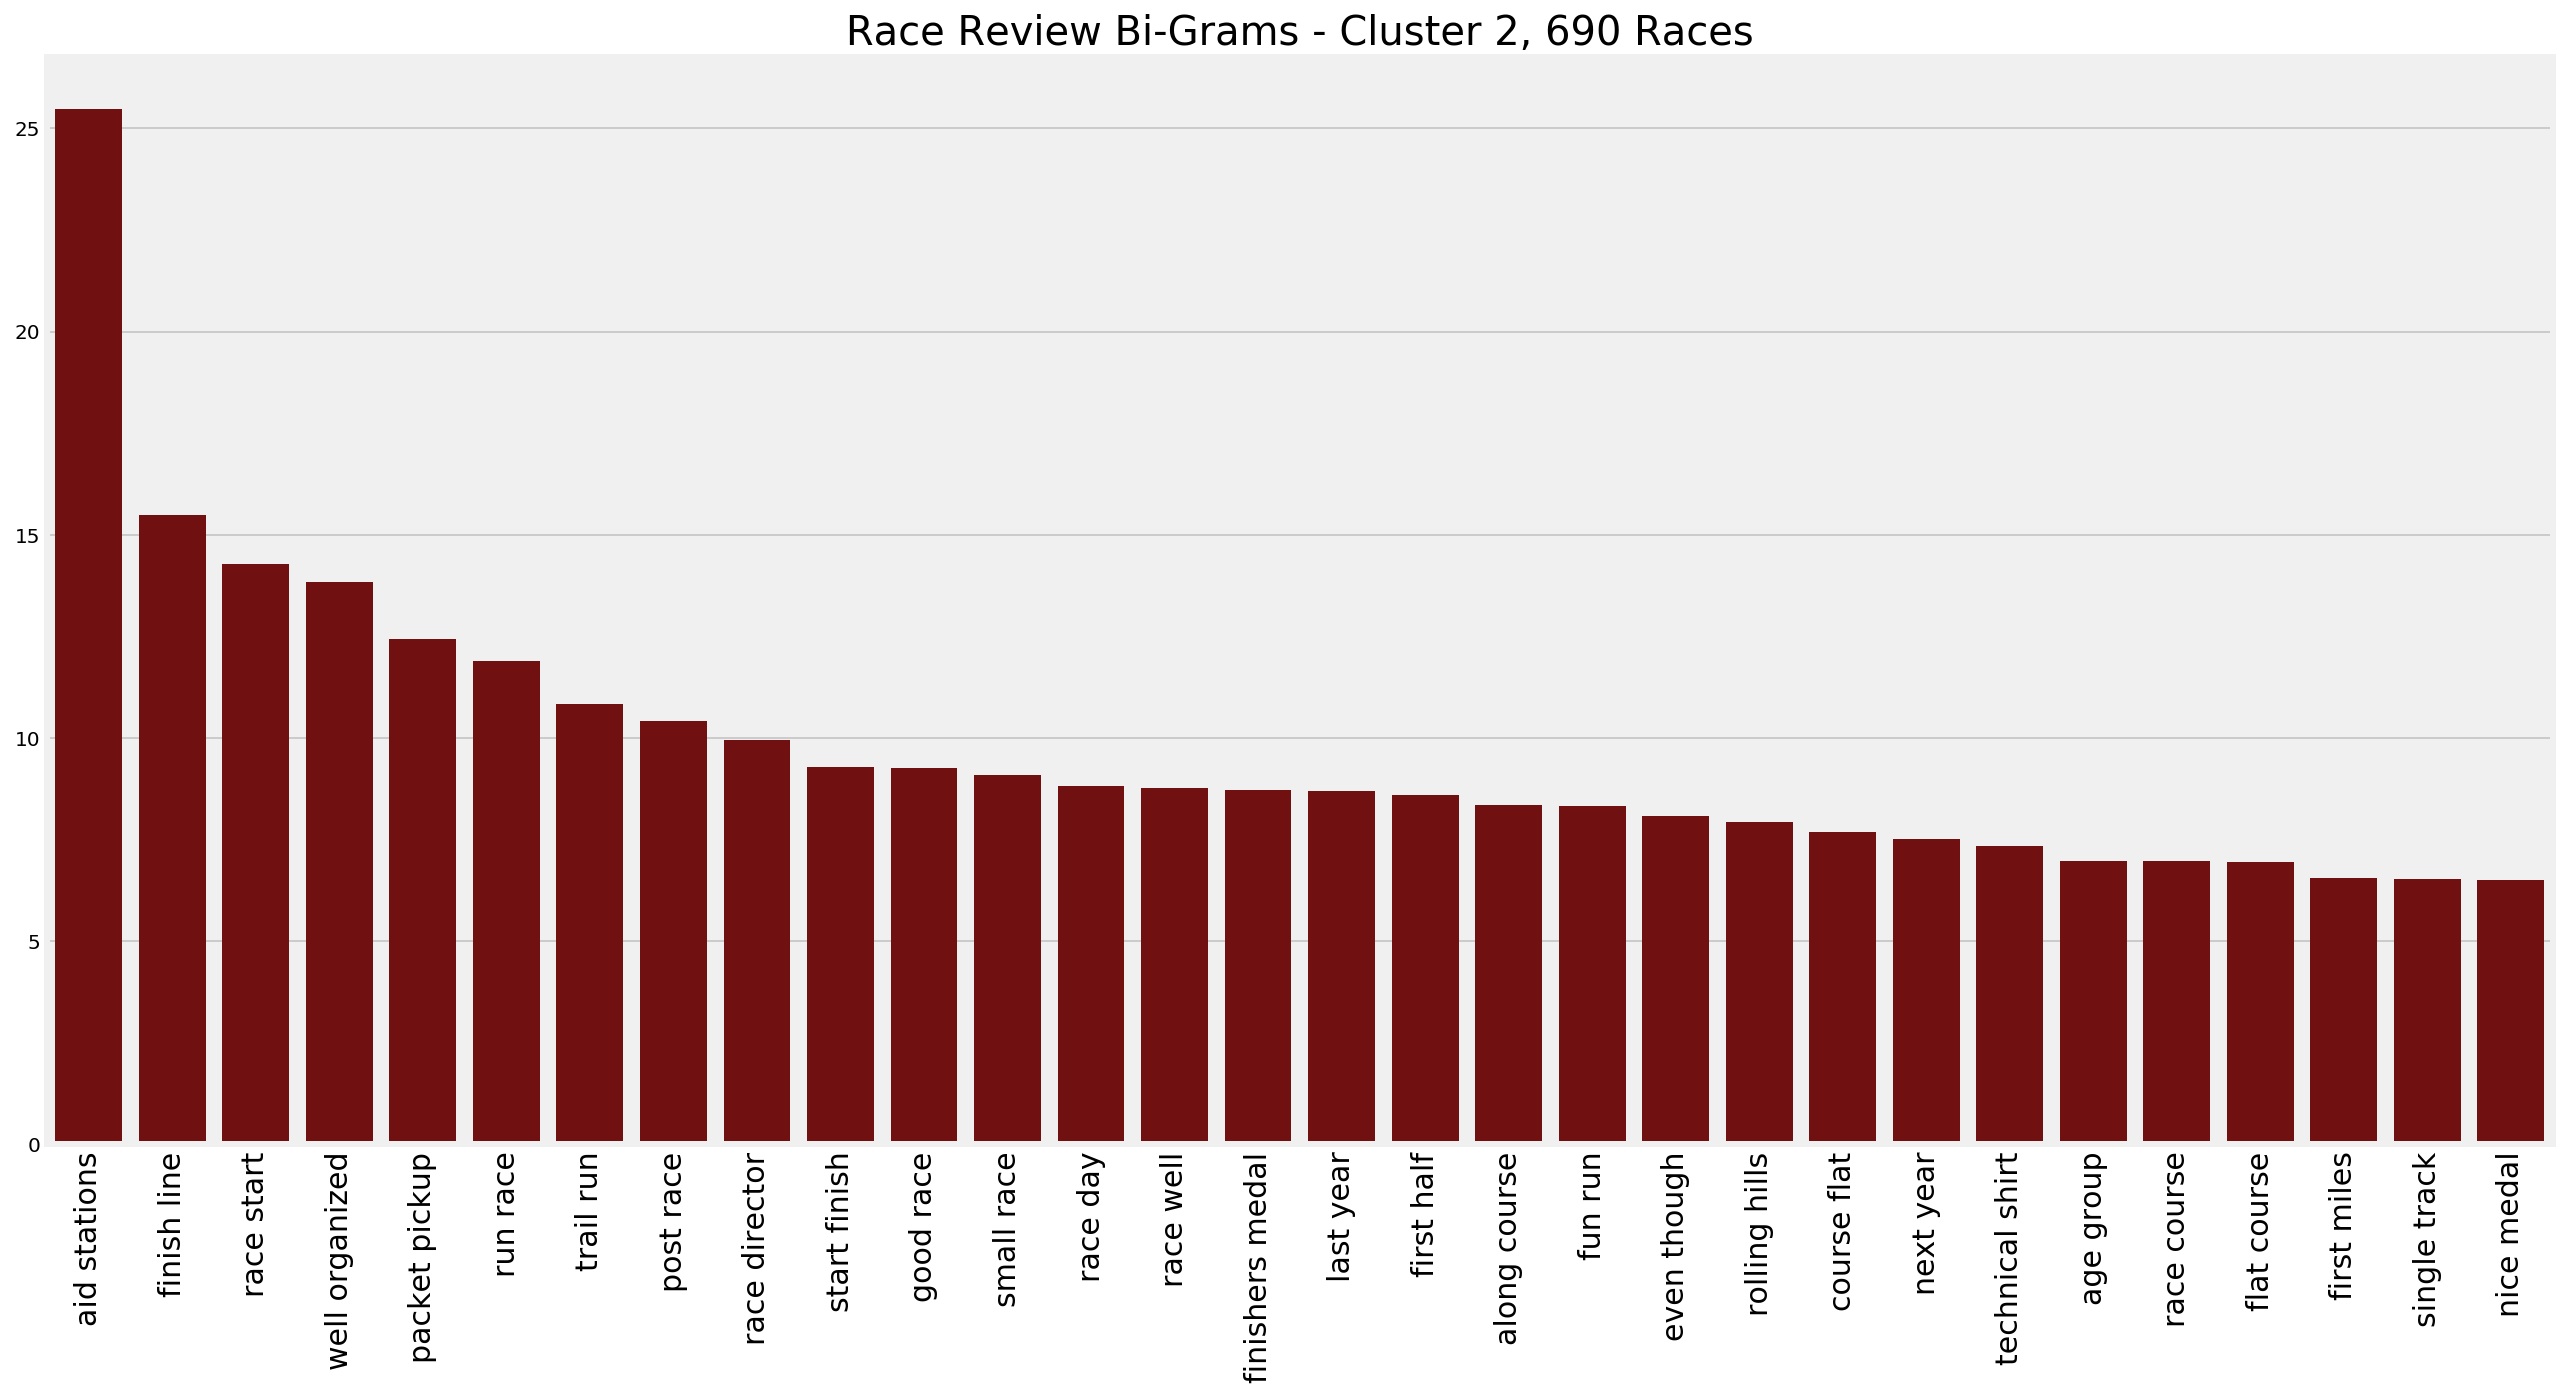

In [139]:
cluster_num = 2
cluster = race_cluster_vect[race_cluster_vect['kmean_clusters'] == cluster_num]
num_racers = len(cluster)
cluster = cluster.drop('kmean_clusters', axis=1)
cluster_sum = cluster.sum(axis=0)
cluster_top30 = cluster_sum.sort_values(ascending=False).head(30)
plt.figure(figsize=(20, 10))
bigram_plot = sns.barplot(cluster_top30.index, \
                          cluster_top30.values, color='maroon')
bigram_plot.set_title("Race Review Bi-Grams - Cluster {}, {} Races".format(cluster_num, num_racers), fontsize=20)
bigram_plot.set_xticklabels(labels=cluster_top30.index, rotation=90, fontsize=15);

In [140]:
race_with_topics.columns

Index(['race_name', 'num_distances', 'diff_rating', 'overall_rating',
       'prod_rating', 'scenery_rating', 'swag_rating', 'high_overall',
       '10 Miler ', '10K ', '12K ', '15K ', '25K ', '4 Miler ', '5 Miler ',
       '50 Miler ', '50K ', '5K ', '8K ', 'Half Marathon ',
       'Half Marathon Relay ', 'Marathon ', 'Marathon Relay ', 'Other',
       'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5',
       'Topic_6', 'Topic_7', 'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11',
       'Topic_12', 'Topic_13', 'Topic_14', 'kmean_clusters'],
      dtype='object')

In [141]:
racer_with_topics.columns

Index(['racer_id', 'num_races', 'num_distances', 'diff_rating',
       'overall_rating', 'prod_rating', 'scenery_rating', 'swag_rating',
       'high_overall', '10 Miler ', '10K ', '12K ', '15K ', '25K ', '4 Miler ',
       '5 Miler ', '50 Miler ', '50K ', '5K ', '8K ', 'Half Marathon ',
       'Half Marathon Relay ', 'Marathon ', 'Marathon Relay ', 'Other',
       '100 Half Marathons Club', '50 states aspirant/finisher',
       'Boston Marathon finisher', 'Half Fanatic', 'Ironman',
       'Marathon Maniac', 'Seven Continents Club', 'Topic_0', 'Topic_1',
       'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7',
       'Topic_8', 'Topic_9', 'Topic_10', 'Topic_11', 'Topic_12', 'Topic_13',
       'Topic_14', 'kmean_clusters', 'agg_clusters'],
      dtype='object')

In [142]:
matched_columns = ['num_distances', 'diff_rating', '10 Miler ', '10K ', '12K ', '15K ', '25K ', 
                   '4 Miler ', '5 Miler ', '50 Miler ', '50K ', '5K ', '8K ', 'Half Marathon ', 
                   'Half Marathon Relay ', 'Marathon ', 'Marathon Relay ', 'Other'] + topic_columns

racers_for_scoring = racer_with_topics[matched_columns]
races_for_scoring = race_with_topics[matched_columns]

racers_scaled = ss.fit_transform(racers_for_scoring)
races_scaled = ss.fit_transform(races_for_scoring)

racers_scored = []
for i in range(len(racers_scaled)):
    racer_scored = []
    for j in range(len(races_scaled)):
        total_diff = 0.0
        for k in range(len(matched_columns)):
            total_diff += (float(racers_scaled[i, k]) - float(races_scaled[j, k])) * \
                          (float(racers_scaled[i, k]) - float(races_scaled[j, k]))
        racer_scored.append(np.sqrt(total_diff))
    racers_scored.append(racer_scored)

racers_scored_df = pd.DataFrame(racers_scored, 
                                index=racer_with_topics.index, columns=race_with_topics['race_name'])
racers_scored_df.head()

race_name  1/2 Way to Christmas Half  10K on the Bay  \
0                           7.197486        7.066305   
1                           7.021324        7.392832   
2                           7.525077        6.574185   
3                           6.494892        7.063493   
4                           3.623299        6.252280   

race_name  20 Mile Drop & 10 Mile Drop  305 Half Marathon  3M Half Marathon  \
0                            10.518283           7.446972          7.372002   
1                             9.909786           6.260400          7.092998   
2                            11.212504           4.467123          8.208774   
3                             9.844303           2.240593          6.170024   
4                             9.936221           7.202383          7.130350   

race_name  4 Miles 4 Water  \
0                12.280698   
1                12.175805   
2                13.409989   
3                12.225911   
4                12.197676   

race_name  5-3-1 Run! July 4th Woodland Schools Foundation Run  \
0                                                  11.398567     
1                                                  10.836846     
2                                                  12.039104     
3                                                  10.433992     
4                                                  10.862366     

race_name  5K Chilly Chili Race  6 Stones Run For Hope  \
0                      7.404270               6.395007   
1                      6.543596               6.738531   
2                      3.597475               8.058949   
3                      3.815562               7.312167   
4                      7.561155               5.462951   

race_name  7 Bridges Marathon & 4 Bridges Half Marathon  \
0                                              6.630225   
1                                              5.599457   
2                                              5.539238   
3                                              3.677861   
4                                              6.352941   

race_name               ...                 ZombieRunner Vasona Lake Run  \
0                       ...                                    11.287967   
1                       ...                                    10.726085   
2                       ...                                    12.109039   
3                       ...                                    10.764863   
4                       ...                                    10.749929   

race_name  Zoom Ayala Cove Run  Zoom Point Pinole  Zoom Quarry Lakes (Summer)  \
0                     9.750692           8.071780                    7.966025   
1                     9.150680           8.002831                    7.892364   
2                    10.318059           7.912746                    7.971980   
3                     9.003195           6.231459                    7.063639   
4                     9.277589           6.960335                    6.835352   

race_name  Zoom Turkey Trot  Zoom! Yah! Yah! Indoor Marathon  Zot Trot  \
0                  7.962032                         6.988441  6.343743   
1                  7.144854                         5.033186  6.475752   
2                  7.902436                         8.054426  7.954624   
3                  6.179969                         5.573105  7.122949   
4                  5.953106                         5.762640  6.520108   

race_name  Zurich Marathon  Zydeco Marathon & Half Marathon  \
0                 8.614919                         7.593250   
1                 7.123495                         6.745556   
2                 9.230723                         8.356809   
3                 7.432323                         6.685466   
4                 7.892717                         7.552956   

race_name  eDreams Barcelona Half Marathon  
0                                 5.874736  
1                                 5.505703  
2  

In [143]:
racers_scored_df.shape

(2009, 2102)

In [144]:
racers_scored_df.iloc[10][racers_scored_df.iloc[10].nsmallest(5).index].index

Index(['Love Run San Diego 5K', 'Silverado Days 5K Fun Run/Walk', 'RaceWay 5K',
       'Bracket Busters 5K', 'WetNWild5K'],
      dtype='object', name='race_name')

In [145]:
recommended_races = []
for i in range(len(racers_scored_df)):
    races = racers_scored_df.iloc[i][racers_scored_df.iloc[i].nsmallest(5).index].index
    recommended_races.append(races)
recommended_races = pd.DataFrame(recommended_races, columns=['Race1', 'Race2', 'Race3', 'Race4', 'Race5'])
recommended_races = pd.concat([racer_with_topics['racer_id'], recommended_races], axis=1)
recommended_races.head()

racer_id                                           Race1  \
0  090775candice                            Critz Tybee Run Fest   
1     16490derek  Wabash Trace Marathon, Half Marathon and Relay   
2        18anjel                     Windsor Green Half Marathon   
3     1FlyMother            American River Parkway Half Marathon   
4  1ladybugangel                            Phoenix Women’s Half   

                                   Race2  \
0                        Run for a Claus   
1  Standard Chartered Hong Kong Marathon   
2                        The Coaster Run   
3                      305 Half Marathon   
4          Run the Road to Super Bowl 50   

                                         Race3                        Race4  \
0                         Autumn Trails 5K Run                Chocolatathon   
1             Hyannis Marathon & Half Marathon             Rotorua Marathon   
2                         5K Chilly Chili Race  Santa Run Silicon Valley 5K   
3                            Belgrade Marathon      C&D Canal Half Marathon   
4  Bald Head Island Maritime Classic Road Race                Beartooth Run   

                                             Race5  
0                              Yeti Chase 5K & 10K  
1                                Grand Teton Races  
2                    The Town’s Half Marathon & 5K  
3                         Gutenberg Marathon Mainz  
4  Lake Tahoe Marathon & Emerald Bay Half Marathon

In [146]:
# recommended_race = pd.DataFrame(racers_scored_df.idxmin(axis=1), columns=['race_name'])
# recommended = pd.concat([racer_with_topics['racer_id'], recommended_race], axis=1)
# recommended

In [147]:
# recommended.to_csv('./Recommendations2.csv', index=False)

In [148]:
melted_races = pd.melt(recommended_races, id_vars=['racer_id'])
melted_races.head()

racer_id variable                                           value
0  090775candice    Race1                            Critz Tybee Run Fest
1     16490derek    Race1  Wabash Trace Marathon, Half Marathon and Relay
2        18anjel    Race1                     Windsor Green Half Marathon
3     1FlyMother    Race1            American River Parkway Half Marathon
4  1ladybugangel    Race1                            Phoenix Women’s Half

In [149]:
hits = pd.merge(left=melted_races[melted_races['variable'] == 'Race1'], right=race_review_df, 
# hits = pd.merge(left=melted_races[melted_races['variable'] in ['Race1', 'Race2', 'Race3']], right=race_review_df, 
# hits = pd.merge(left=melted_races, right=race_review_df, 
                left_on=['racer_id', 'value'], right_on=['racer_id', 'race_name'])
len(hits['racer_id'].unique())

# 10 LDA Topics = 134 (6.7%) / 281 (14.0%)
# 12 LDA Topics = 153 (7.6%) / 282 (14.0%)
# 15 LDA Topics = 168 (8.4%) / 310 (15.4%) <==
# 20 LDA Topics = 183 (9.1%) / 313 (15.6%)
# 25 LDA Topics = 222 (11.1%) / 333 (16.6%)

168

In [150]:
hits['overall_rating'].describe(percentiles=[0.05, 0.1, 0.2, 0.21, 0.25, 0.5, 0.59, 0.75]).T
# 10 LDA Topics = 4.14, 83% 4+ & 43% 5
# 12 LDA Topics = 4.06, 78% 4+ & 45% 5
# 15 LDA Topics = 4.07, 80% 4+ & 42% 5 <==
# 20 LDA Topics = 4.07, 79% 4+ & 42% 5
# 25 LDA Topics = 4.05, 79% 4+ & 42% 5

count    168.000000
mean       4.071429
std        1.075427
min        1.000000
5%         1.000000
10%        3.000000
20%        3.000000
21%        4.000000
25%        4.000000
50%        4.000000
59%        5.000000
75%        5.000000
max        5.000000
Name: overall_rating, dtype: float64

In [151]:
race_with_topics['overall_rating'].describe(percentiles=[0.05, 0.1, 0.2, 0.25, 0.26, 0.5, 0.75, 0.77]).T
# 4.04, 75% 4+ & 24% 5

count    2102.000000
mean        4.040738
std         0.829540
min         1.000000
5%          3.000000
10%         3.000000
20%         3.400000
25%         3.833333
26%         4.000000
50%         4.000000
75%         4.750000
77%         5.000000
max         5.000000
Name: overall_rating, dtype: float64

In [152]:
random_assigned = {}
for i in range(len(racers_scaled)):
    racer_id = racer_with_topics.iloc[i]['racer_id']
    j = int(np.random.uniform(0, len(race_with_topics)))
    race_name = race_with_topics.iloc[j]['race_name']
    random_assigned[racer_id] = race_name

random_assigned = pd.DataFrame.from_dict(random_assigned, orient='index')
random_assigned = random_assigned.reset_index()
random_assigned.columns = ['racer_id', 'race_name']
random_assigned.head()

racer_id                                   race_name
0  090775candice                      FOURmidable Trail Runs
1     16490derek                          Cherry Creek Sneak
2        18anjel                   Napoli City Half Marathon
3     1FlyMother  Barnum Rail Trail Marathon & Half Marathon
4  1ladybugangel                             Tucson Marathon

In [153]:
pd.merge(left=random_assigned, right=race_review_df, on=['racer_id', 'race_name'])

racer_id                                          race_name  \
0         RGarrett  Chevron Houston Marathon & Aramco Houston Half...   
1  pollygolightly2                   Bank of America Chicago Marathon   

           date  diff_rating   distance  overall_rating  prod_rating  \
0   May 8, 2017          2.0  Marathon              3.0          4.0   
1  Jan 17, 2018          1.0  Marathon              5.0          5.0   

   scenery_rating  swag_rating  \
0             2.0          2.0   
1             3.0          5.0   

                                                text                  title  \
0   This race has amazing community support and p...          Hometown Race   
1   Words cannot begin to describe The Chicago Ma...  The Chicago Marathon!   

                type distance_trunc  year  high_overall  
0  Repeat Runner '15      Marathon   2017             0  
1    First-timer '17      Marathon   2018             1

In [154]:
top_word_list = []
for topic_idx, topic in enumerate(lda.components_):
    word_dict = {}
    for i in topic.argsort()[:-20 - 1:-1]:
        word_dict[review_vect_names[i]] = round(topic[i],0) 
    top_word_list.append(word_dict)

top_word_list[0]

{'age group': 26.0,
 'awesome race': 19.0,
 'cant beat': 14.0,
 'course hilly': 18.0,
 'forward run': 12.0,
 'good race': 24.0,
 'group awards': 13.0,
 'ive run': 18.0,
 'made race': 12.0,
 'make sure': 13.0,
 'new york': 12.0,
 'overall good': 16.0,
 'pr course': 13.0,
 'previous years': 14.0,
 'race every': 14.0,
 'race support': 12.0,
 'run race': 24.0,
 'well run': 19.0,
 'wine country': 16.0,
 'wine tasting': 15.0}

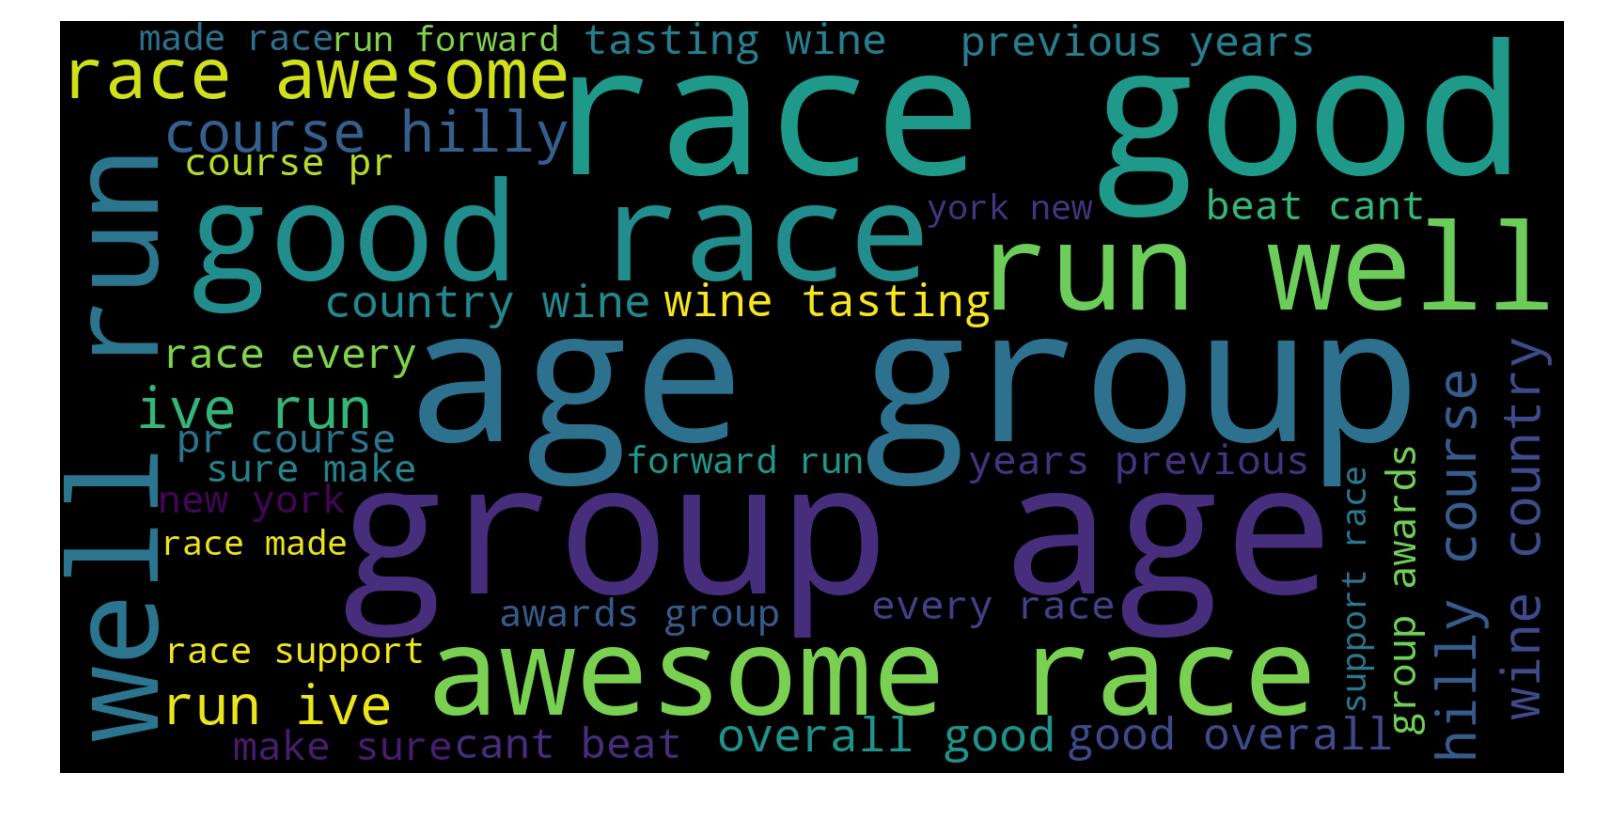

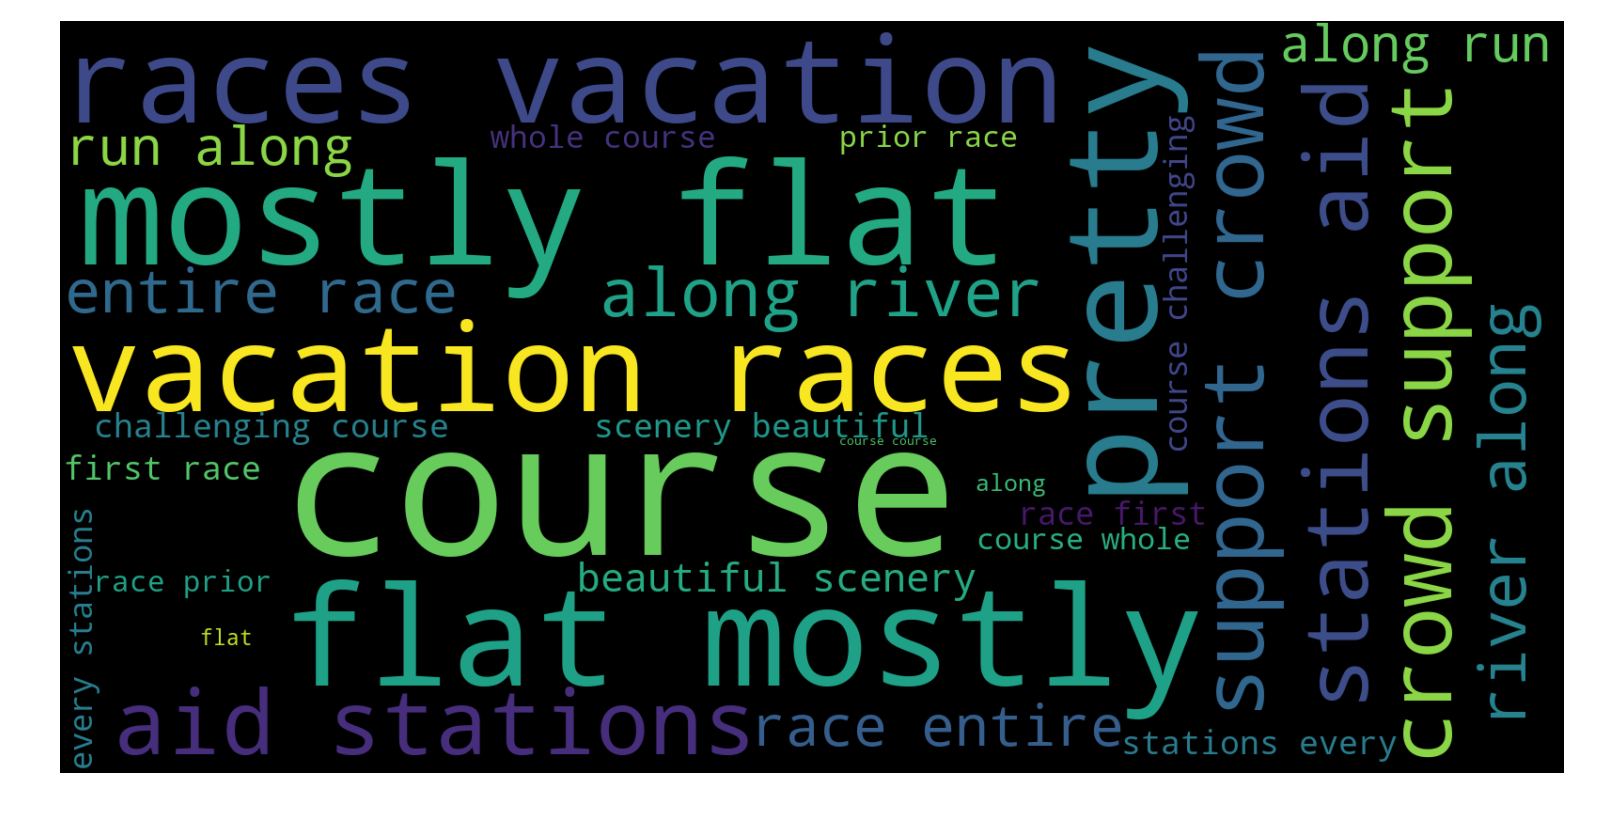

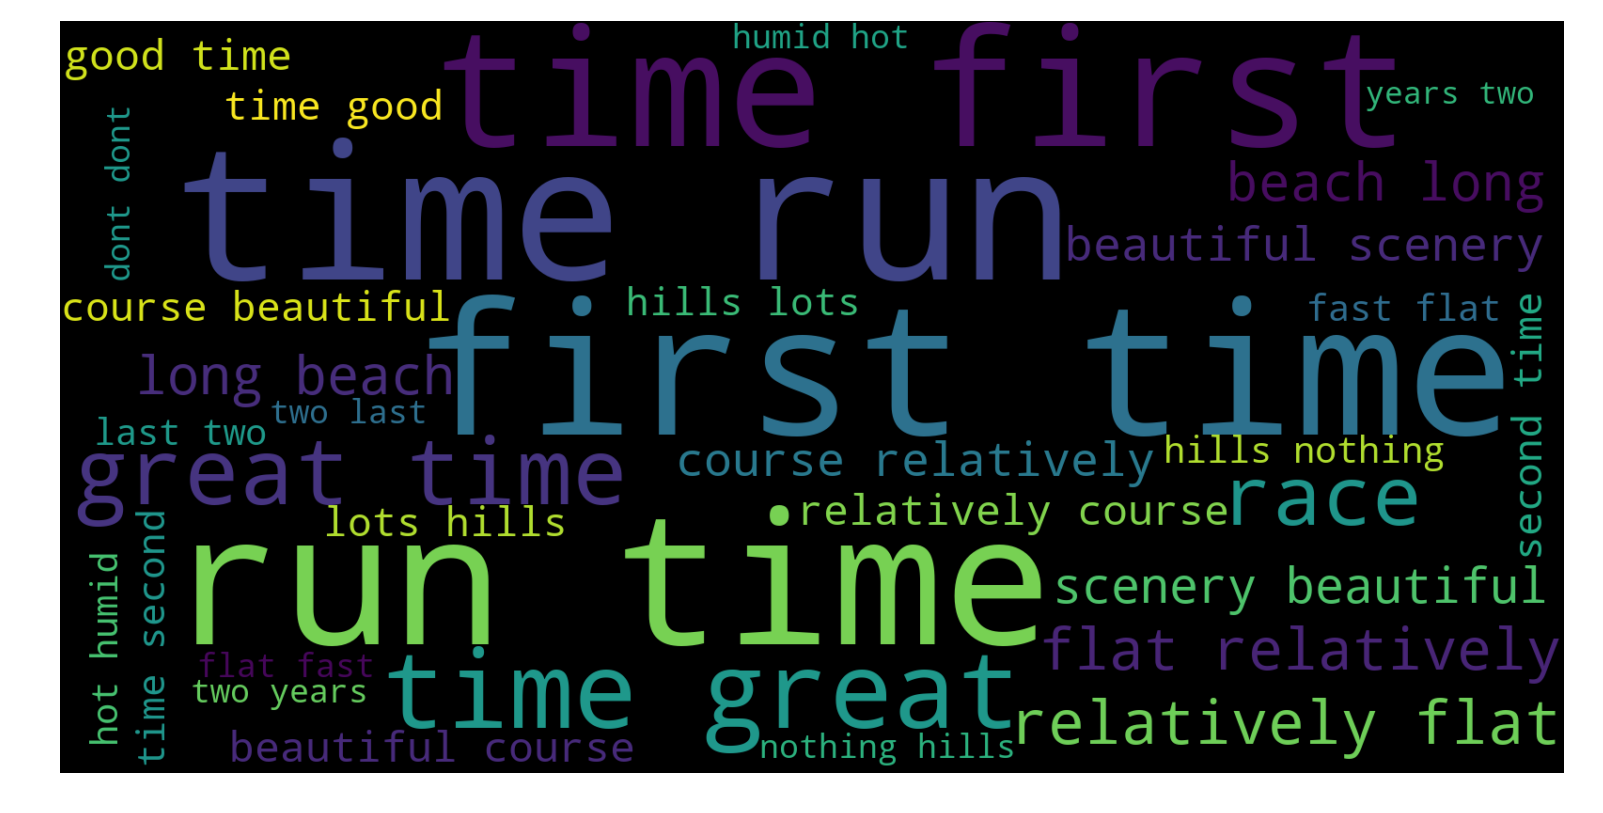

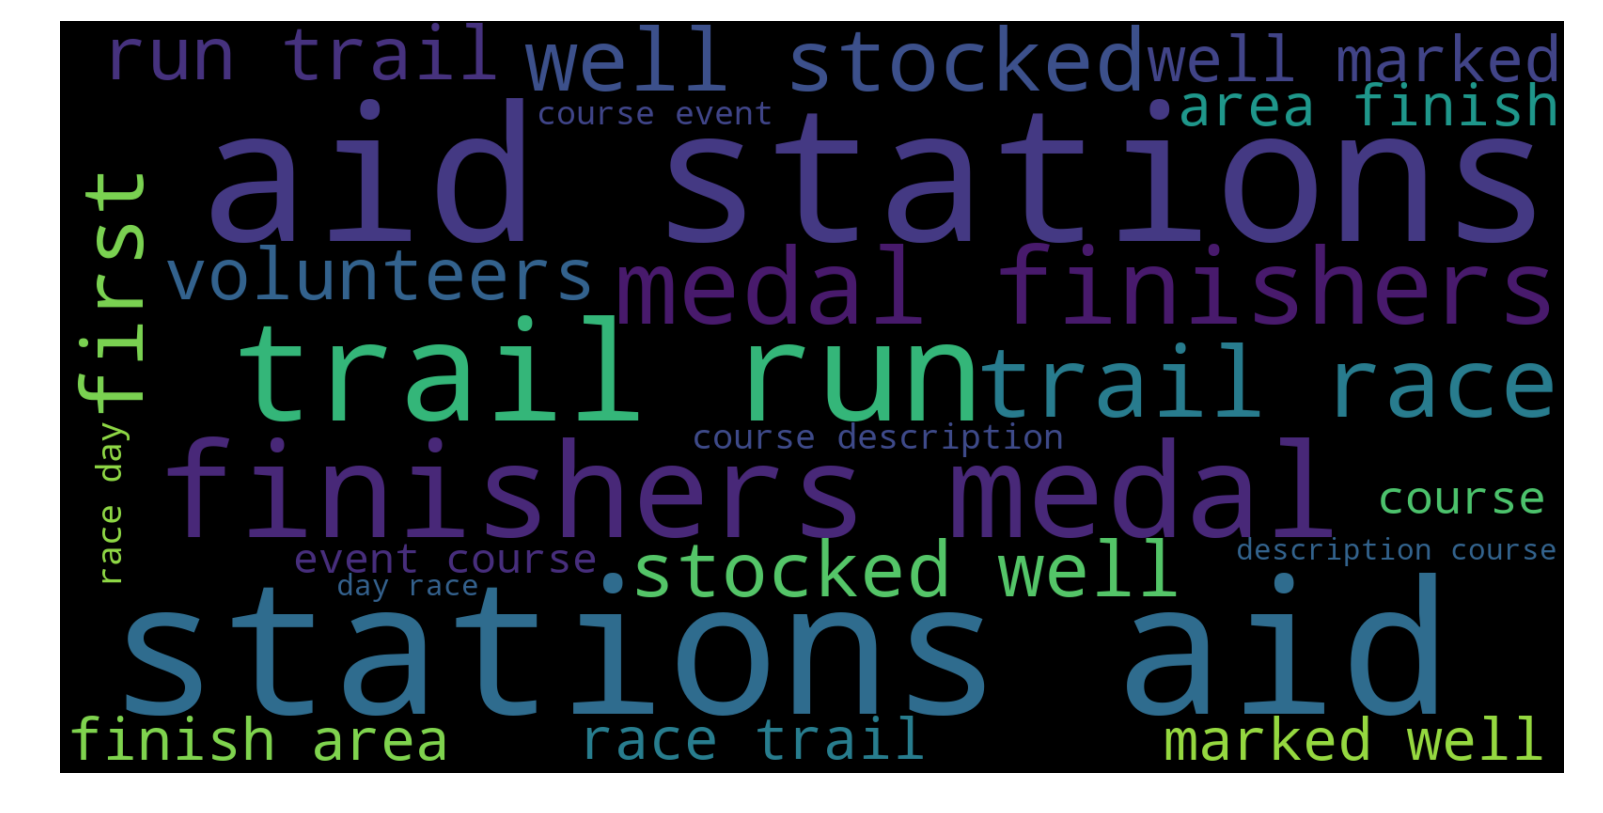

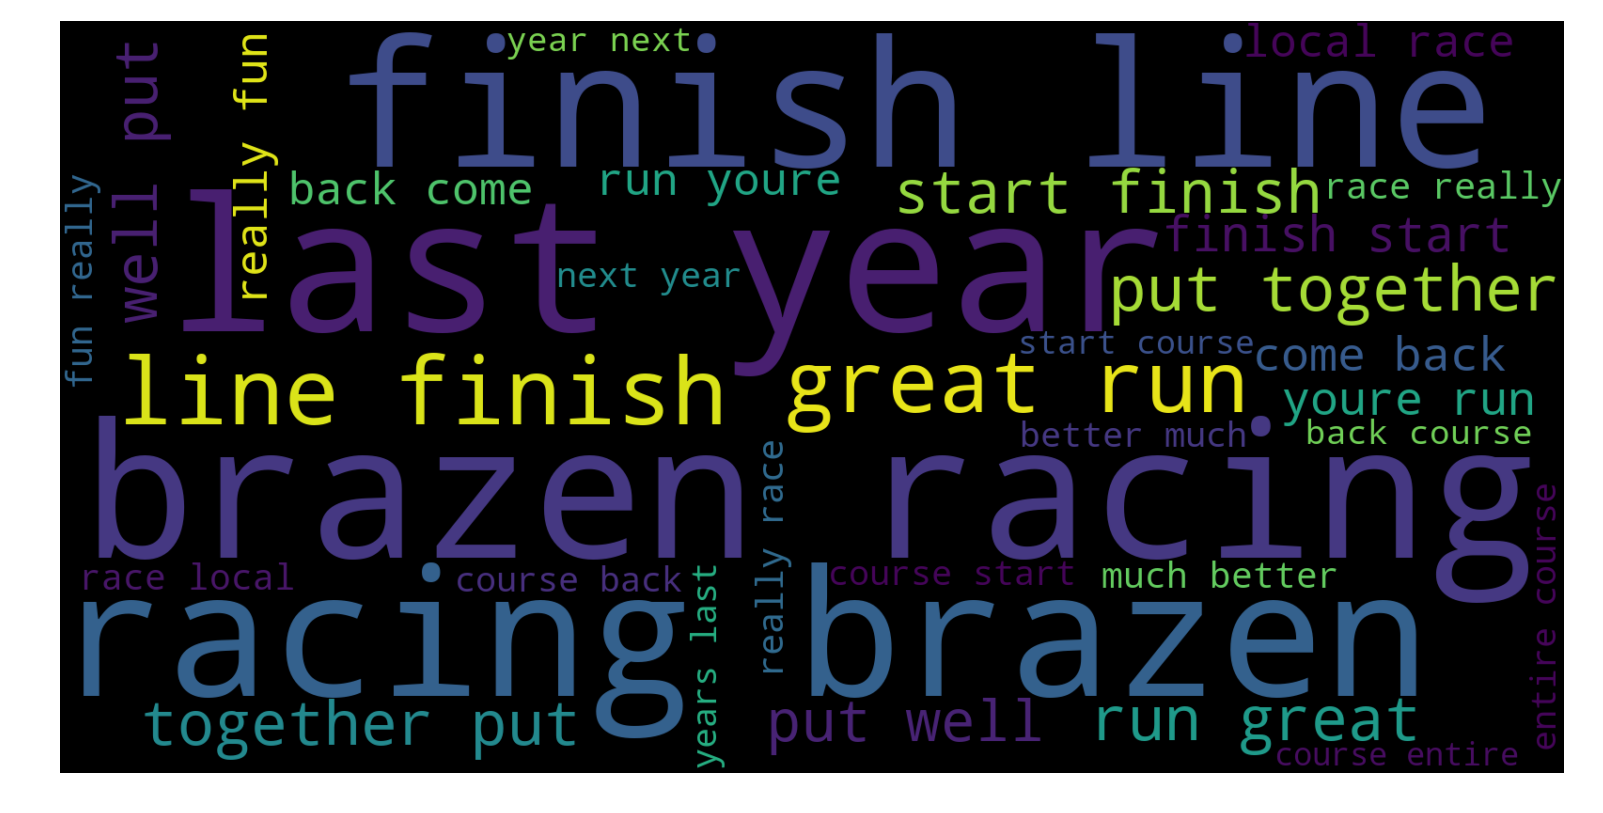

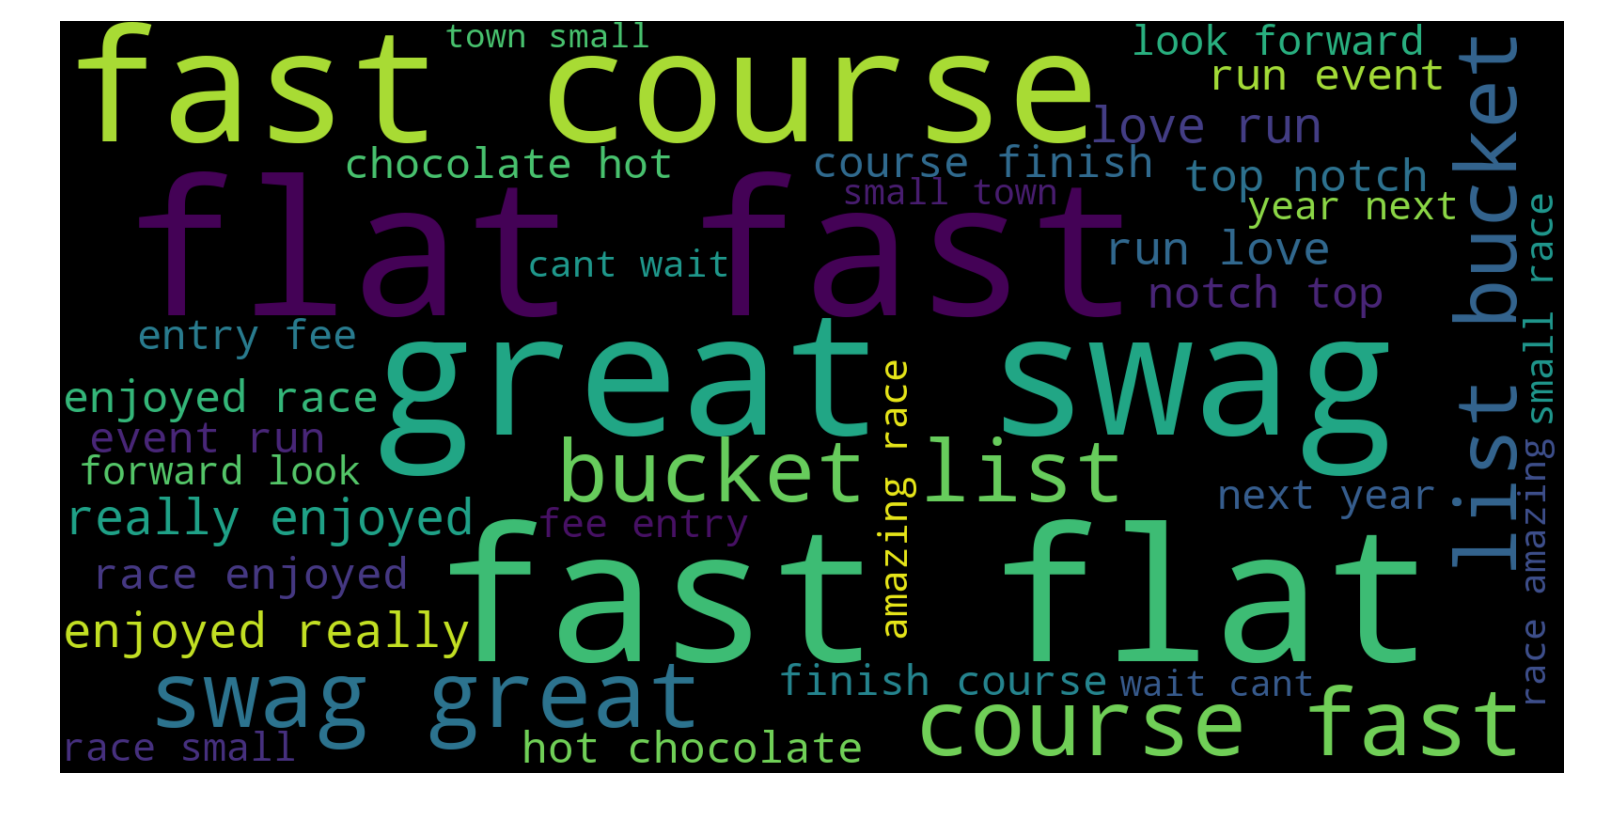

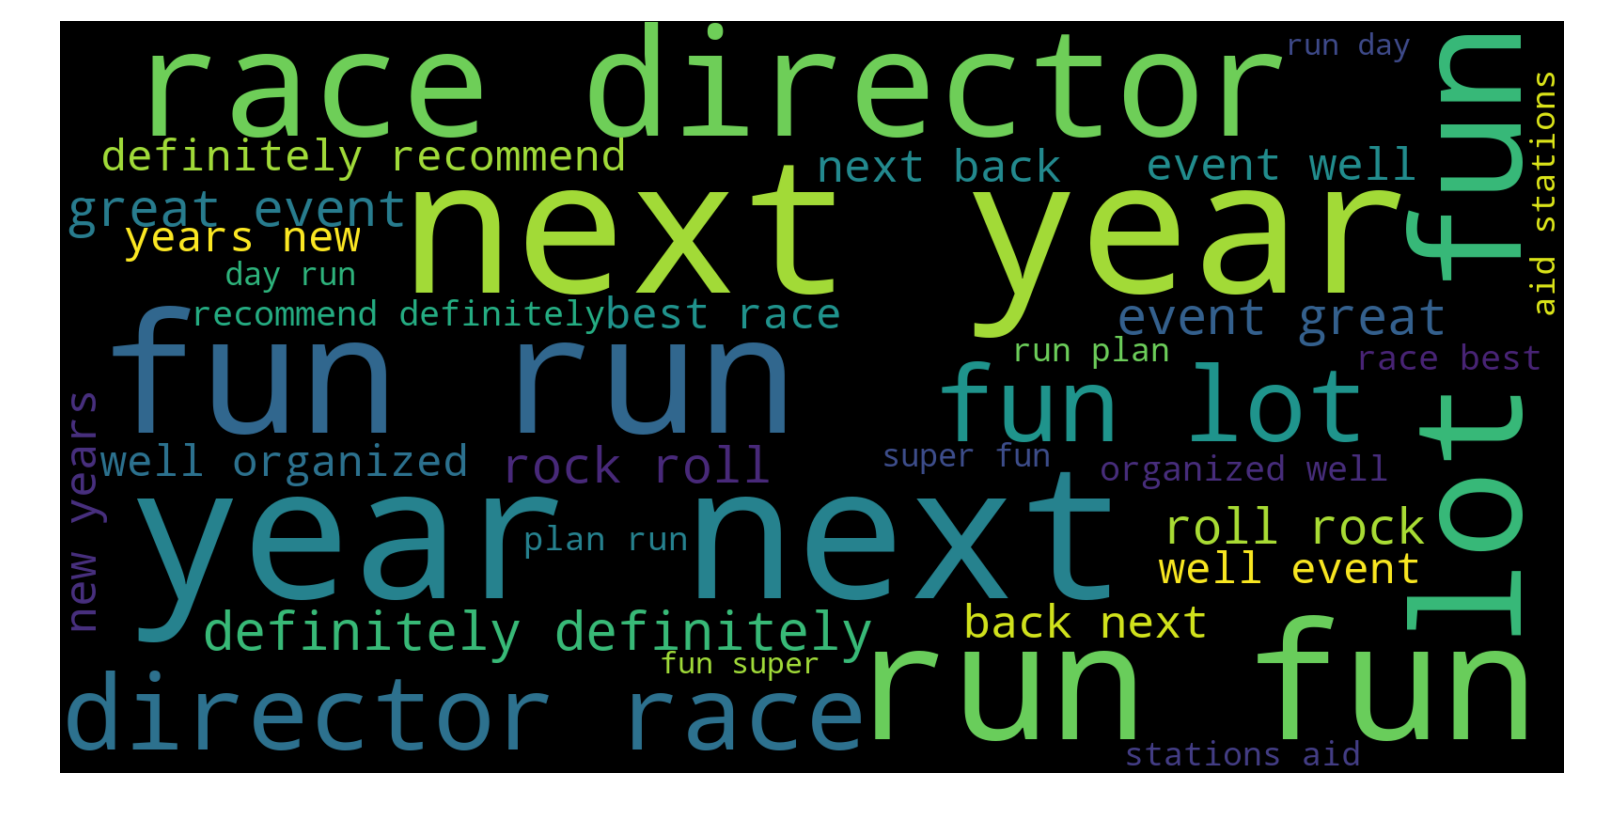

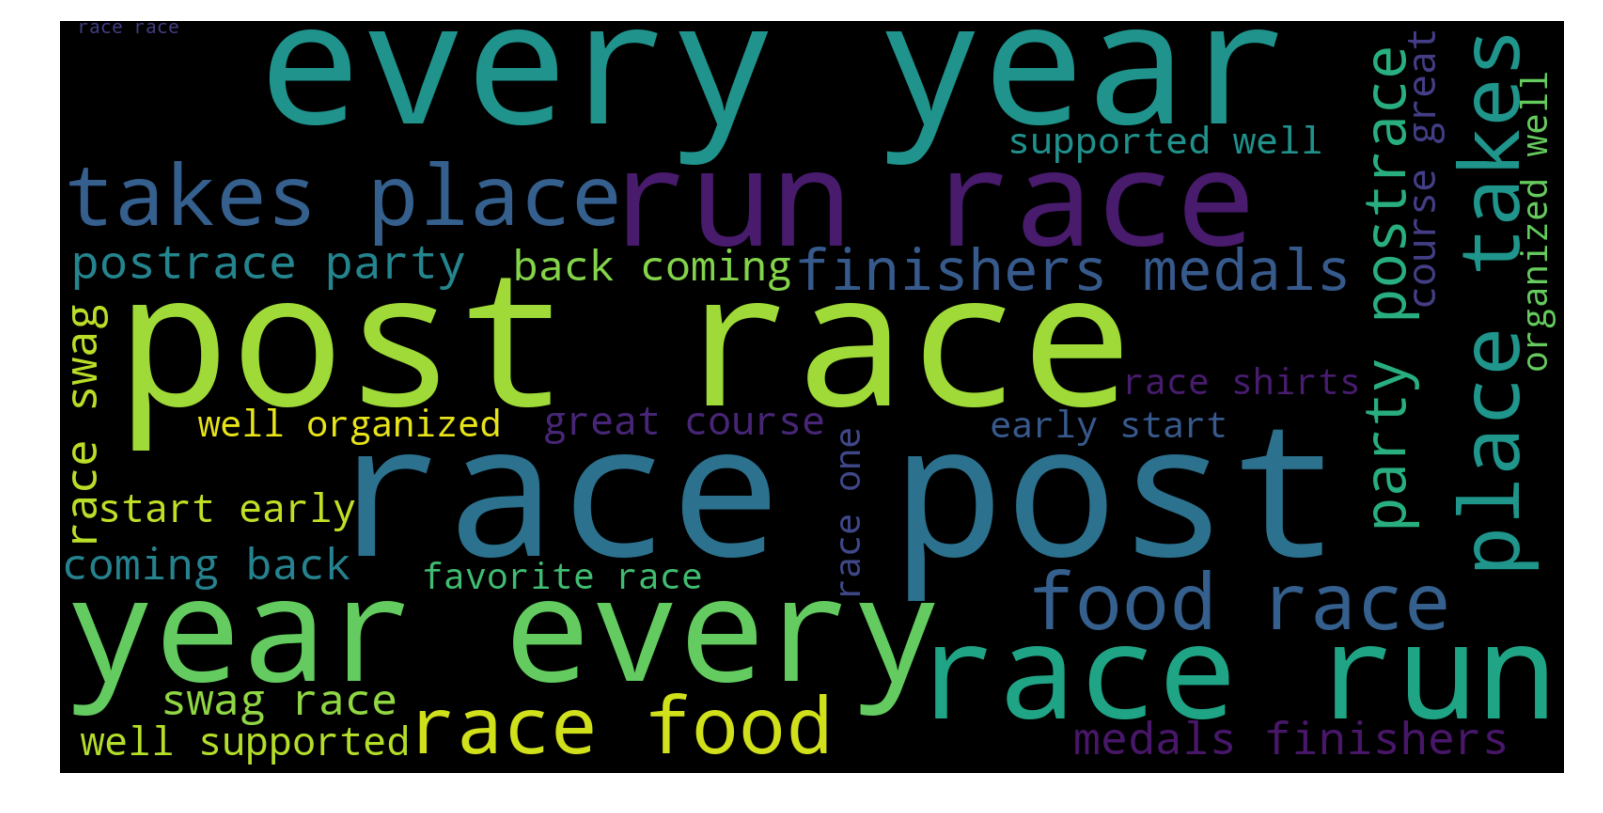

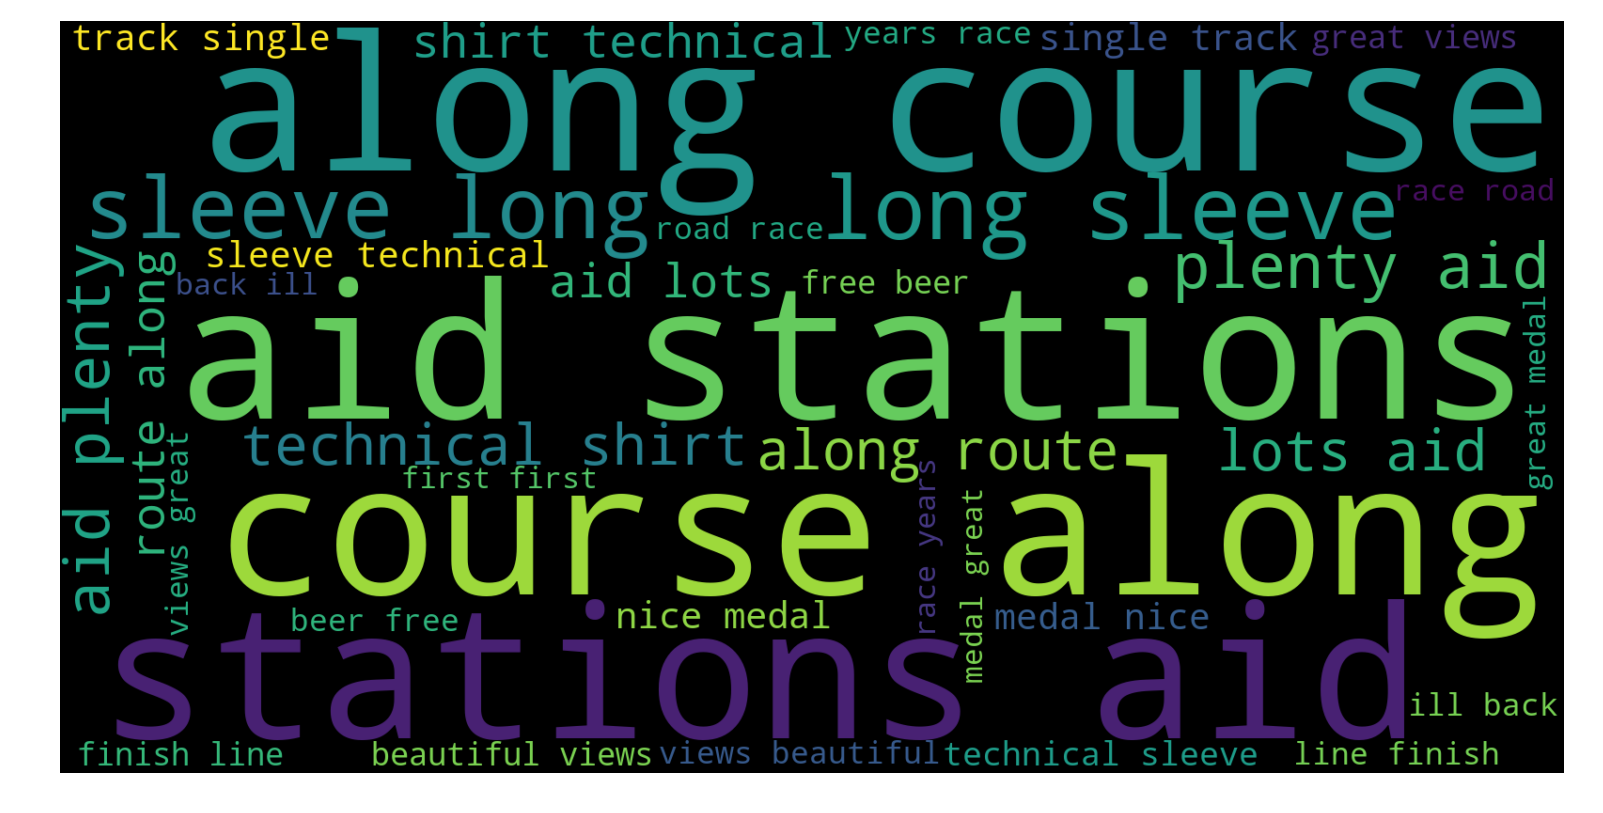

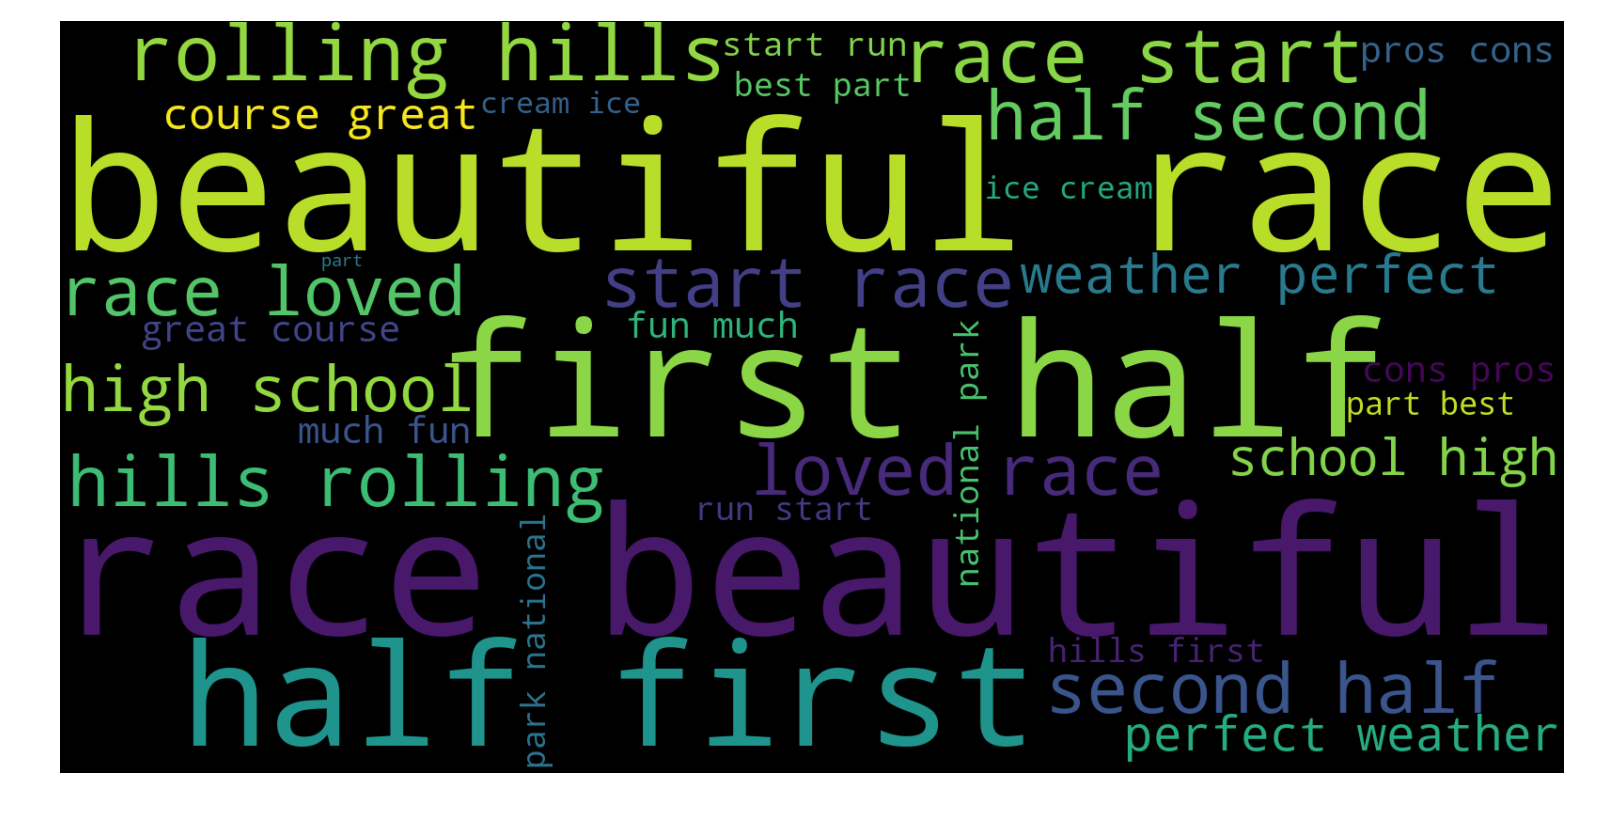

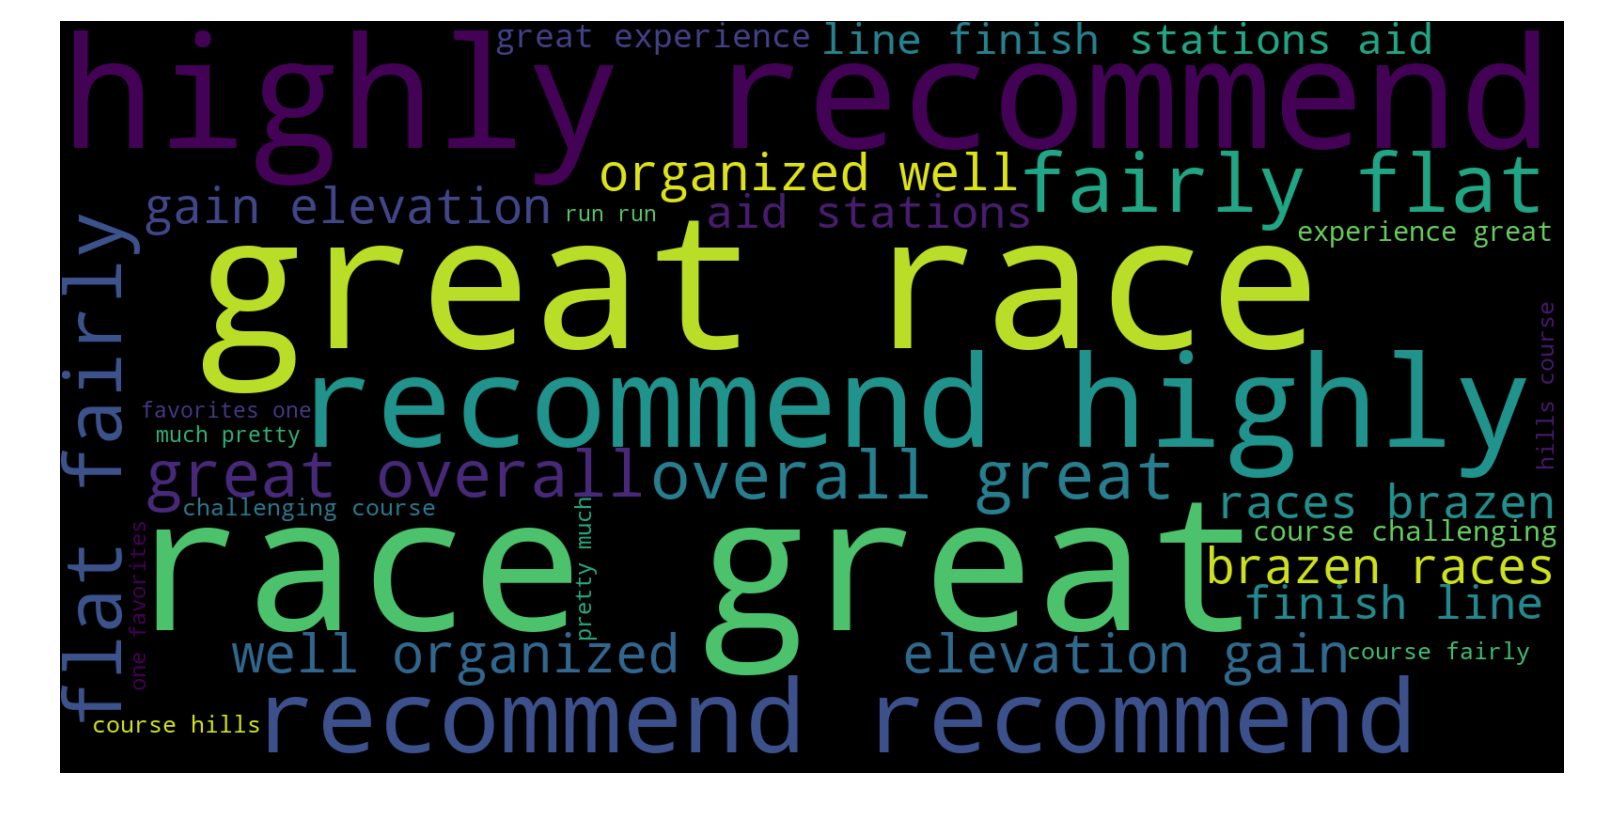

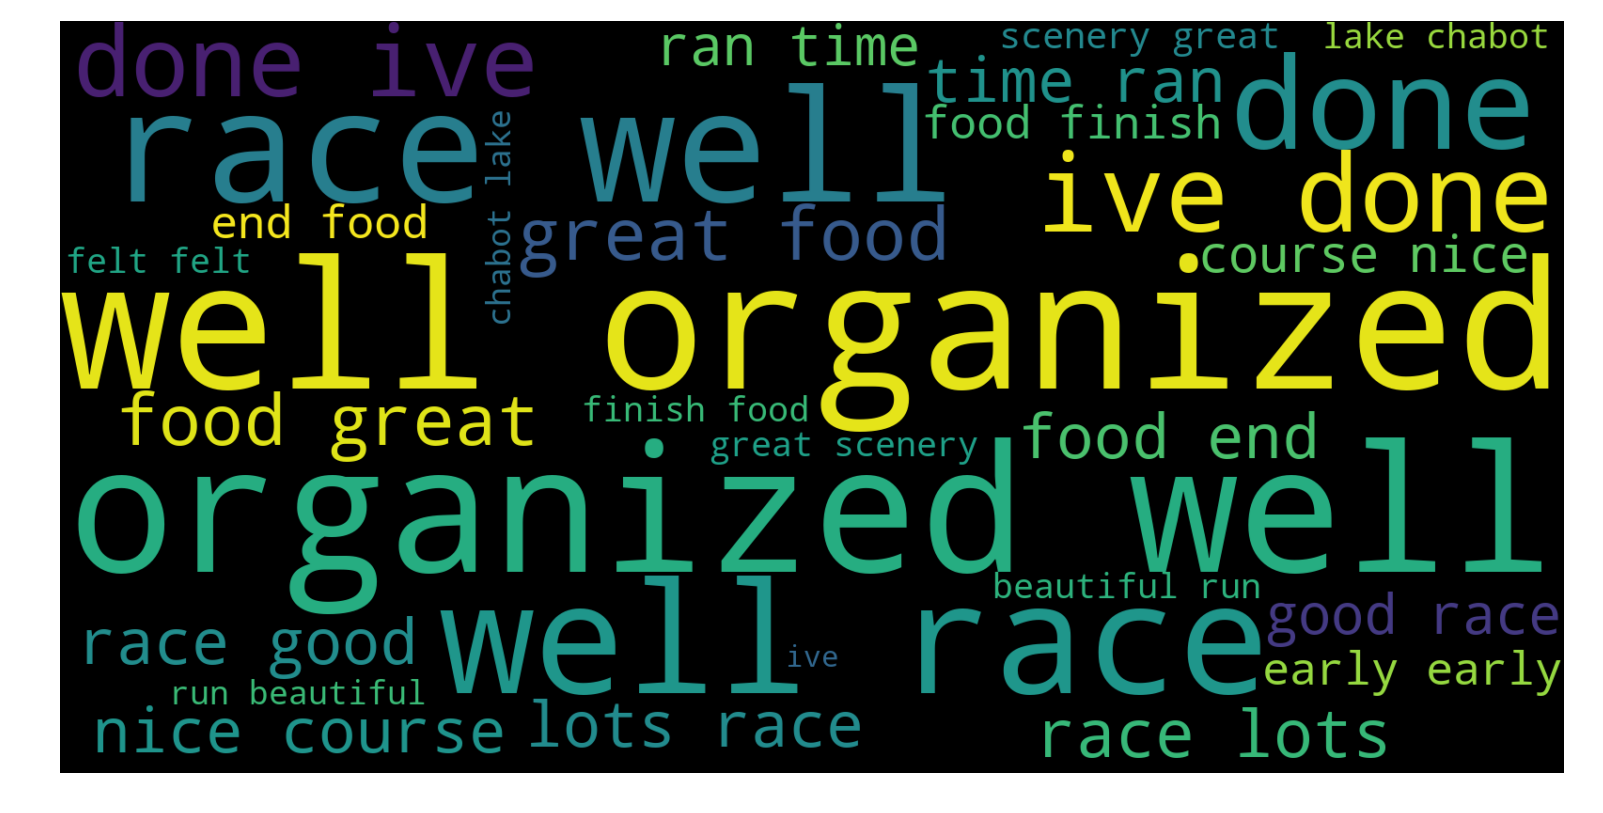

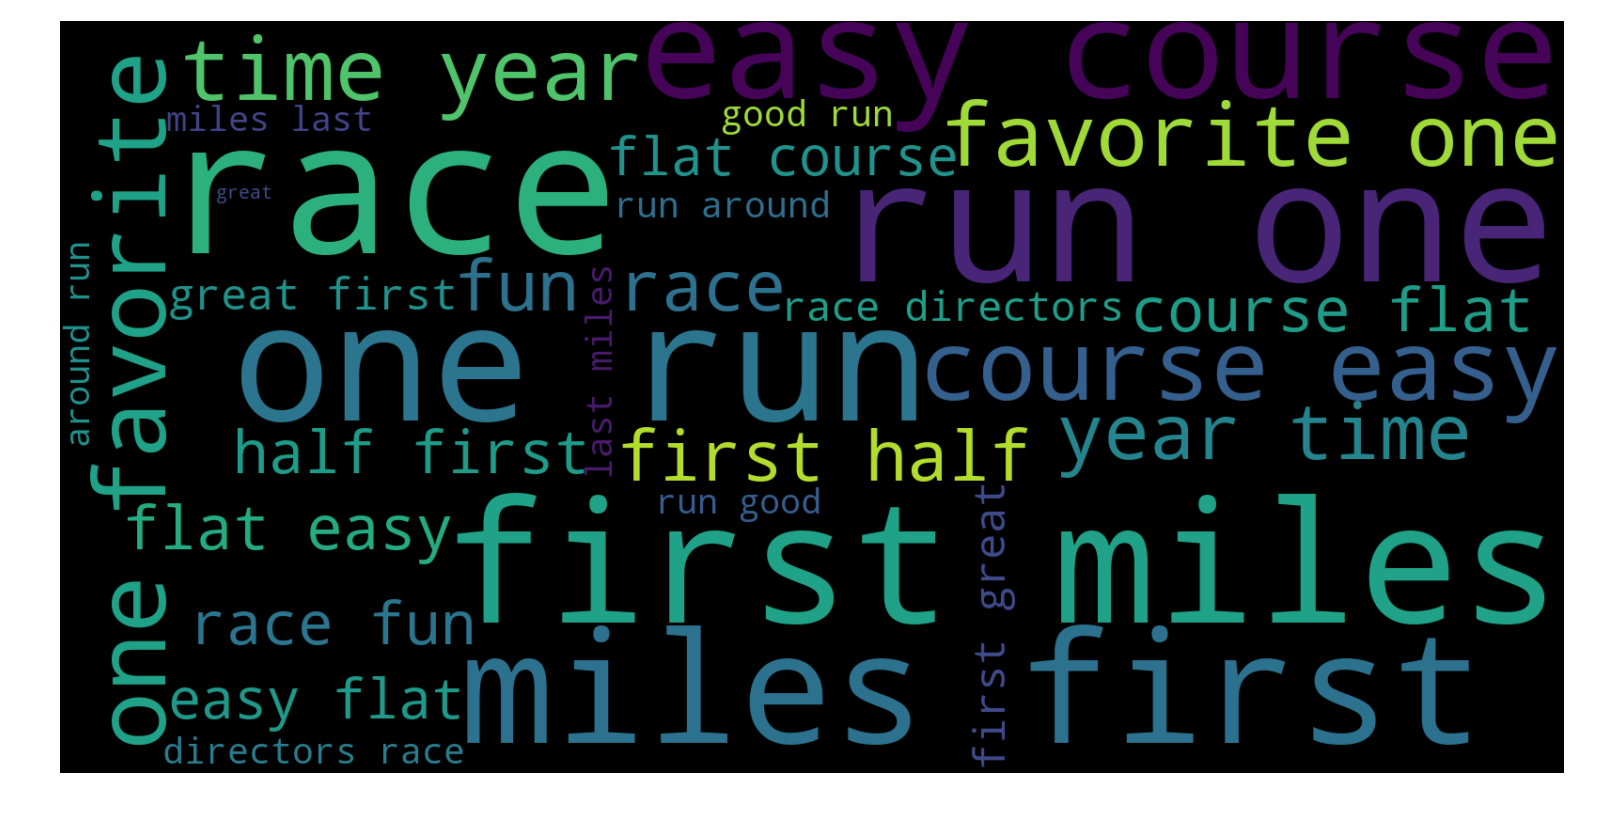

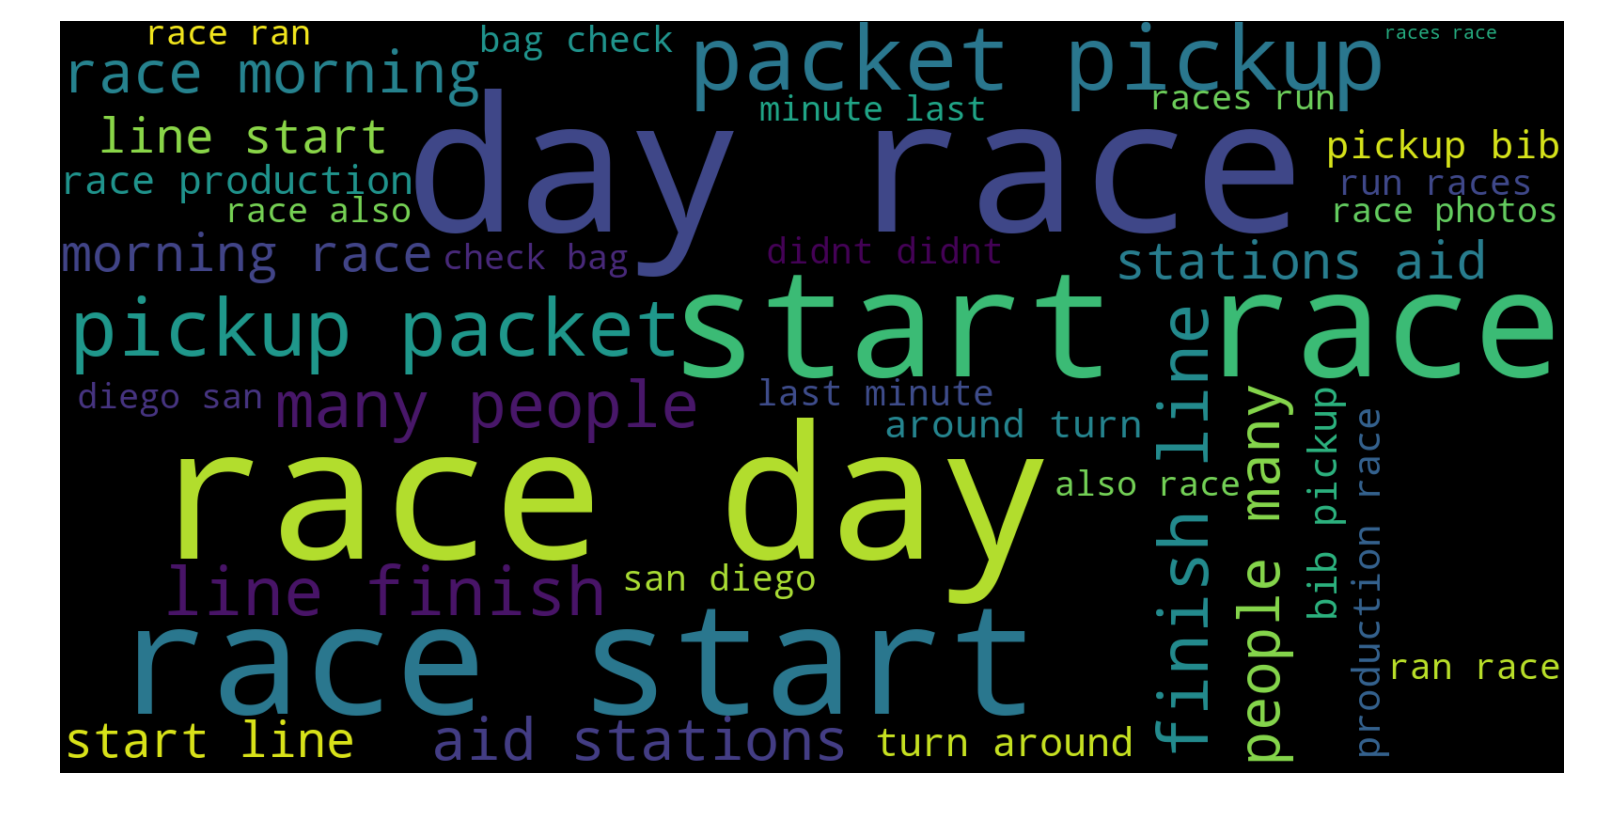

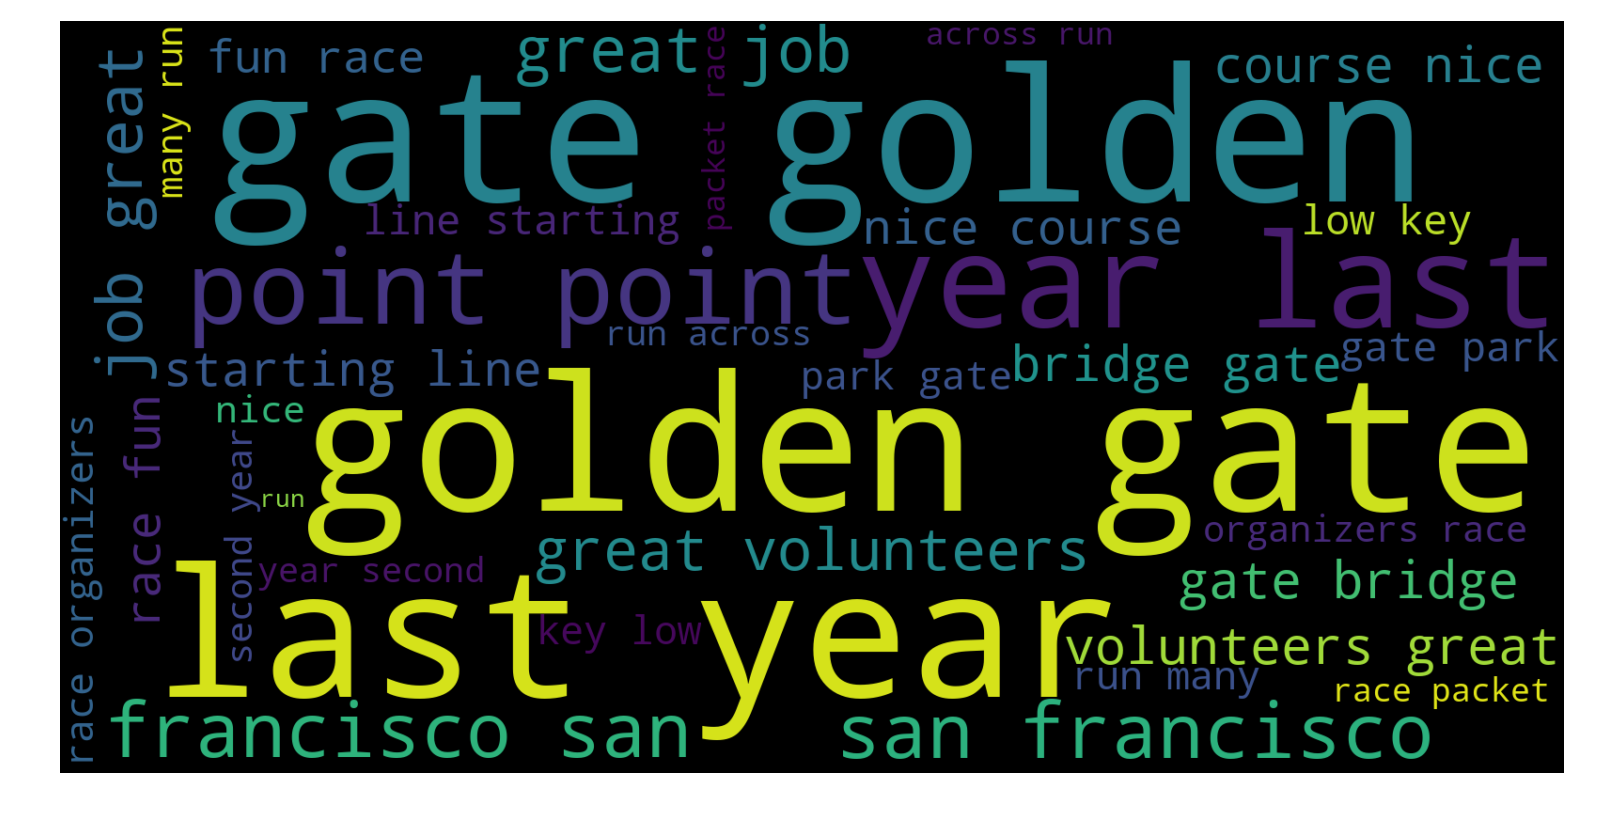

In [155]:
from wordcloud import WordCloud

for topic in range(15):
    top_words = top_word_list[topic]
    top_words_list = ''
    for key, value in top_words.items():
        for i in range(int(value)):
            top_words_list += ' ' + key
    top_words_list

    wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(top_words_list)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()